# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue            
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def load_medical_terms_with_noise(json_file, num_samples, noise_threshold):
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    med_terms = list(med_terms_dict.keys())
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
    return input_texts, target_texts, gt_texts, med_terms_dict

In [10]:
def load_accidents_terms_with_noise(file_name, limit, num_samples, noise_threshold):

    f = open(file_name, encoding='utf8')
    line = 0    
    med_terms = []
    try:
        for r in f:
            if(line < limit):

                med_terms.extend(r.split('|'))
                line += 1
    except:
        print('finished')
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
                
    return input_texts, target_texts, gt_texts

In [11]:
def load_procedures_tests_with_noise(file_name, num_samples, noise_threshold):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                
                input_text = noise_maker(row, noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + row + '\n'            

                cnt += 1
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [12]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [13]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [14]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [15]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [17]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

# Load data

In [18]:
data_path = '../../dat/'

In [19]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [20]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [21]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [22]:
input_texts = []
target_texts = []

In [23]:
num_samples = 1000000
input_texts = []
target_texts = []
#files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_22.txt', 'field_class_23.txt', 'field_class_24.txt', 'field_class_25.txt', 'field_class_26.txt', 'field_class_27.txt', 'field_class_28.txt', 'field_class_29.txt', 'field_class_30.txt', 'field_class_31.txt', 'field_class_32.txt', 'field_class_33.txt', 'field_class_34.txt', 'NL-14622714.txt', 'NL-14627449.txt', 'NL-14628986.txt', 'NL-14631911.txt', 'NL-14640007.txt']
#desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
desired_file_sizes = []
for i in range(len(files_list)):
    desired_file_sizes.append(num_samples)
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    print(file_name)
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_file_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

    

all_ocr_data_2.txt
field_class_21.txt
field_class_22.txt
field_class_23.txt
field_class_24.txt
field_class_25.txt
field_class_26.txt
field_class_27.txt
field_class_28.txt
field_class_29.txt
field_class_30.txt
field_class_31.txt
field_class_32.txt
field_class_33.txt
field_class_34.txt
NL-14622714.txt
NL-14627449.txt
NL-14628986.txt
NL-14631911.txt
NL-14640007.txt


In [24]:
len(input_texts)

8813

In [25]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

8813
Claim Type: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Pol inyhold elm-Chm er [11 form arlon 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Middle Nameﬂnitial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Social S ecurity Number: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Language Preference: 
 	Language Preference:


Address Line 1: 
 	Address Line 1:




## Build vocab

In [26]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [27]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [28]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 8813
Number of unique input tokens: 126
Number of unique output tokens: 126
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [29]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 '\x0c': 120,
 ' ': 1,
 '!': 111,
 '"': 95,
 '#': 67,
 '$': 79,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 61,
 ')': 62,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 54,
 '/': 29,
 '0': 63,
 '1': 43,
 '2': 53,
 '3': 52,
 '4': 66,
 '5': 74,
 '6': 65,
 '7': 70,
 '8': 58,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 105,
 '=': 94,
 '>': 106,
 '?': 56,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 57,
 'I': 22,
 'J': 68,
 'K': 49,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 48,
 'UNK': 0,
 'V': 14,
 'W': 50,
 'X': 80,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 102,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 55,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 51,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 59,
 'y': 10,
 'z': 60,
 '{': 113,
 '|': 82,
 '}': 104,
 '~': 110,
 '¢': 121,
 '£

In [30]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: 'U',
 49: 'K',
 50: 'W',
 51: 'q',
 52: '3',
 53: '2',
 54: '.',
 55: 'k',
 56: '?',
 57: 'H',
 58: '8',
 59: 'x',
 60: 'z',
 61: '(',
 62: ')',
 63: '0',
 64: '’',
 65: '6',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: '$',
 80: 'X',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: '☐',
 99: '☒',
 100:

In [31]:
len(int_to_vocab)

126

# Prepare training data

## Train/test split

In [32]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [33]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [34]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(7491, 49)
(7491, 49, 126)


## Test data

In [35]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [36]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [37]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 126)    15876       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [38]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [39]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [40]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [41]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [42]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [43]:
#callbacks_list.append(lrate)

In [44]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 7491 samples, validate on 1322 samples
Epoch 1/20
7491/7491 [==============================] - 25s 3ms/step - loss: 2.5944 - categorical_accuracy: 0.3016 - val_loss: 1.5039 - val_categorical_accuracy: 0.5546

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55460, saving model to best_model-50.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.6230 - categorical_accuracy: 0.8093 - val_loss: 0.3500 - val_categorical_accuracy: 0.8811

Epoch 00002: val_categorical_accuracy improved from 0.55460 to 0.88110, saving model to best_model-50.hdf5
Epoch 3/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.2909 - categorical_accuracy: 0.8902 - val_loss: 0.2958 - val_categorical_accuracy: 0.8934

Epoch 00003: val_categorical_accuracy improved from 0.88110 to 0.89335, saving model to best_model-50.hdf5
Epoch 4/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.2092 - categorical_accuracy: 0.9079 - val_loss: 0.2711 - val_categorical_accuracy: 0.8969

Epoch 00004: val_categorical_accuracy improved from 0.89335 to 0.89690, saving model to best_model-50.hdf5
Epoch 5/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.1666 - categorical_accuracy: 0.9168 - val_loss: 0.2608 - val_categorical_accuracy: 0.9007


KeyboardInterrupt: 

In [ ]:
encoder_model.save('encoder_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_model-{}.hdf5'.format(max_sent_len))

In [45]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:
-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:
-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.
-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: roup and insuring subsidiariaries.
-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported
-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)
-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment
-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St
-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J Dewint, ..:

-
Input sentence: Date Signed
GT sentence: Date Signed

Decoded sentence: Date Signed
-
Input sentence: treating phye.clan telephone number
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treating Phys.cian Telephone Number
-
Input sentence: Time ofAceident:
GT sentence: Time of Accident:

Decoded sentence: Time of Acciden:
-
Input sentence: Patient #:
GT sentence: Patient #: 

Decoded sentence: Patient #: 
-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage
-
Input sentence: Event dates: unknown rtw
GT sentence: Event dates: unknown rtw

Decoded sentence: Event dates: Unknown rtw
-
Input sentence: Bradycardia
GT sentence: Bradycardia

Decoded sentence: Bradycardia
-
Input sentence: Diagnosis 72 a itd alozhs :
GT sentence: Diagnosis: 722.211A

Decoded sentence: Diagnosis 72stitd Alozhed
-
Input sentence: (Name) {Telephone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (Name) {T

# Visualize attention

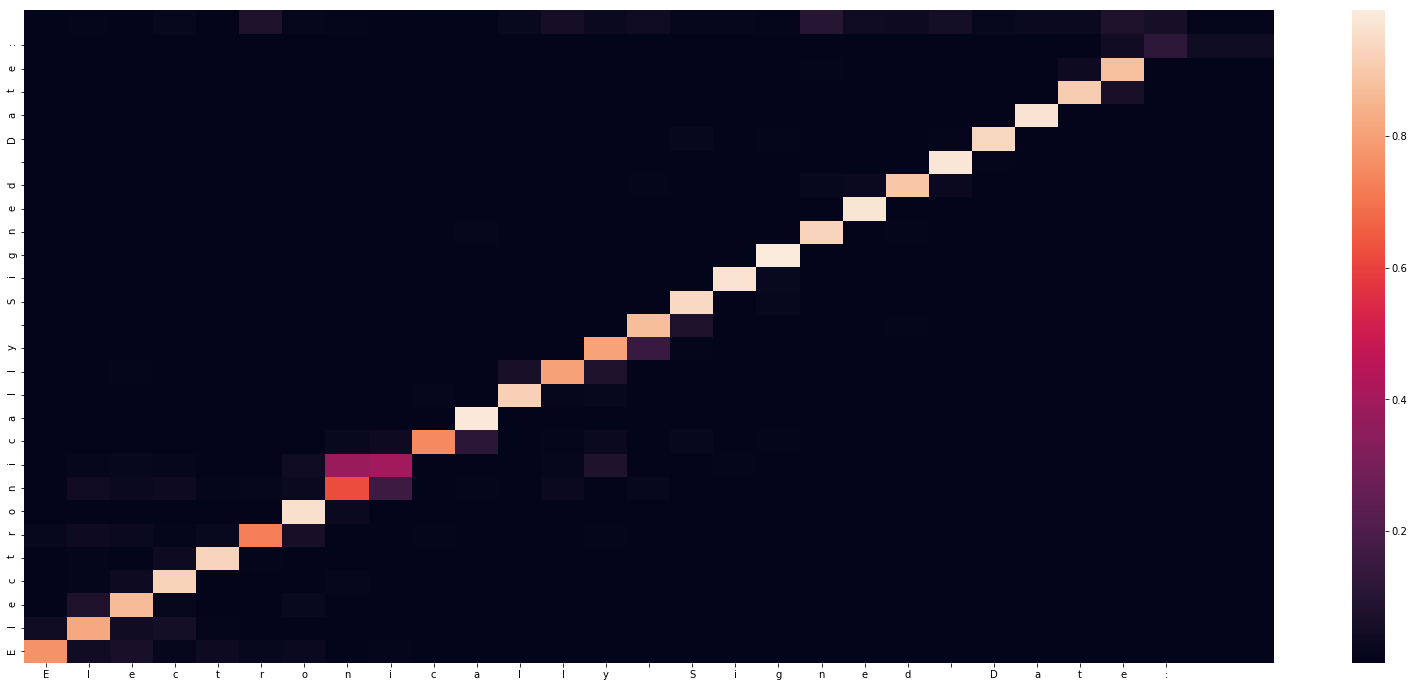

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:


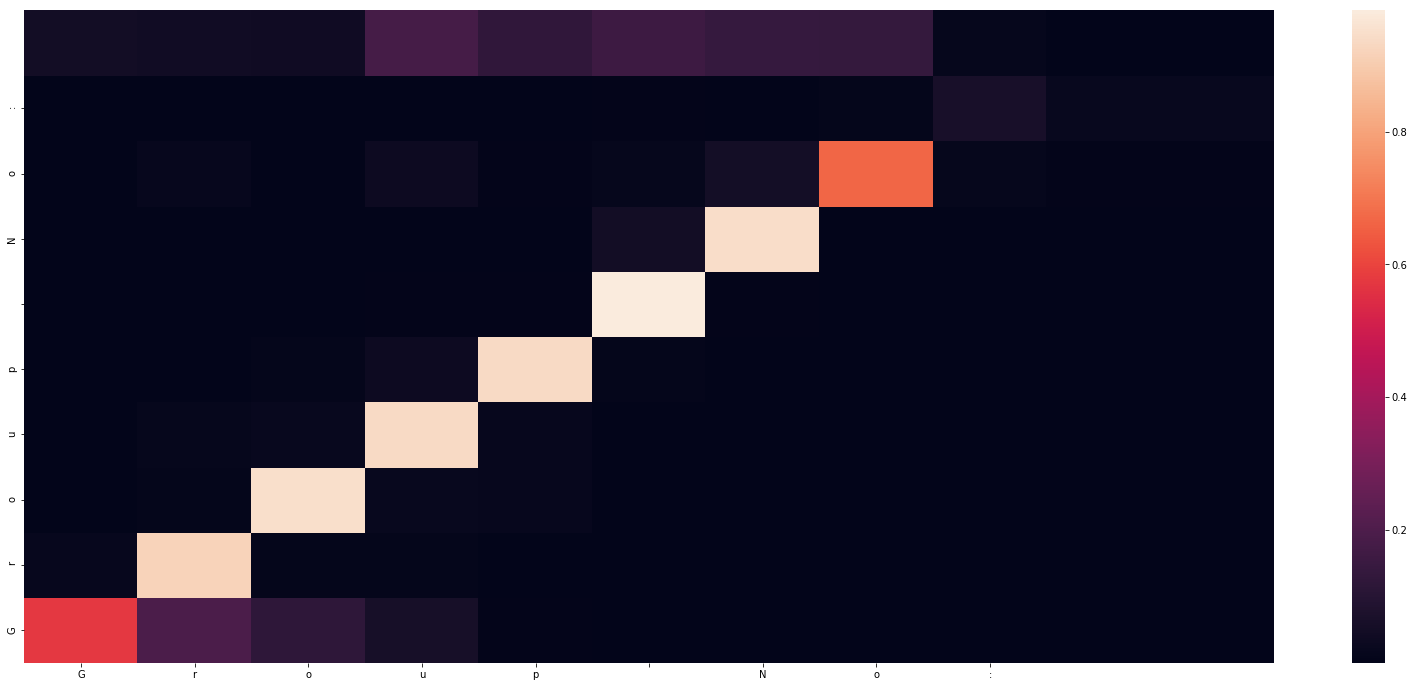

-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:


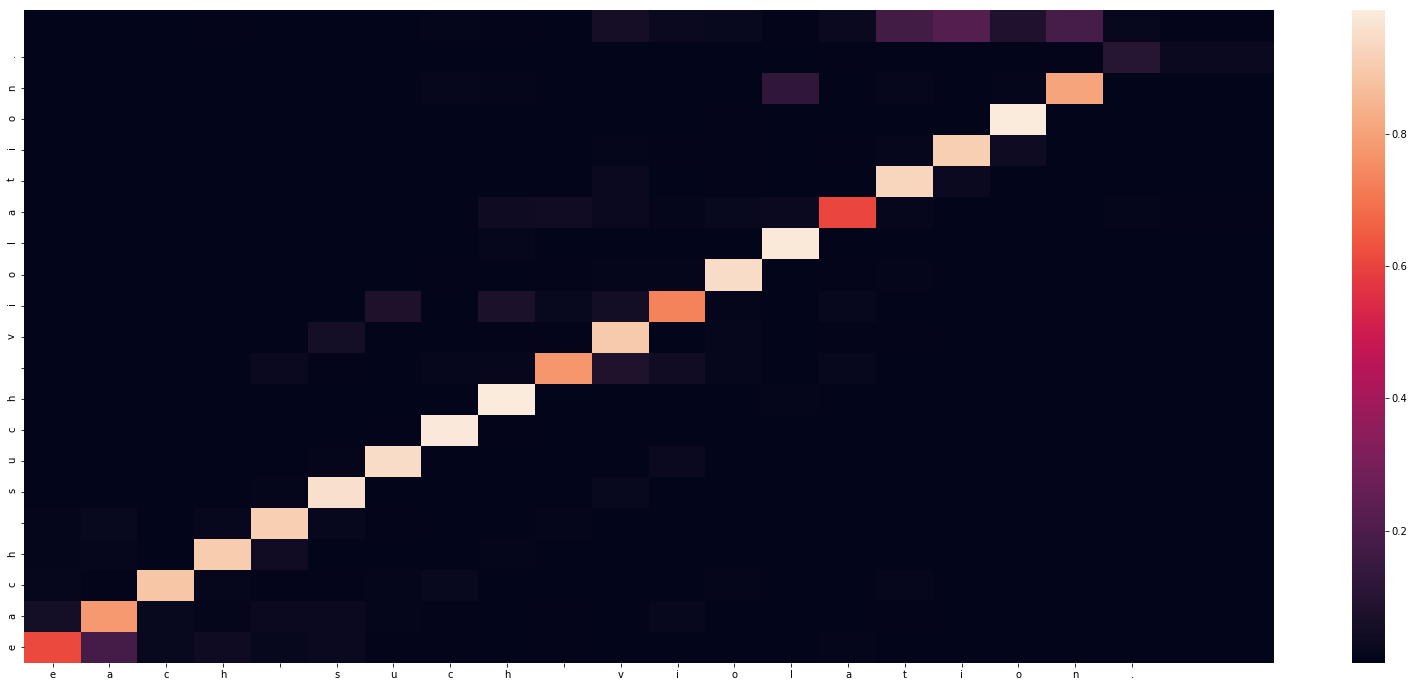

-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.


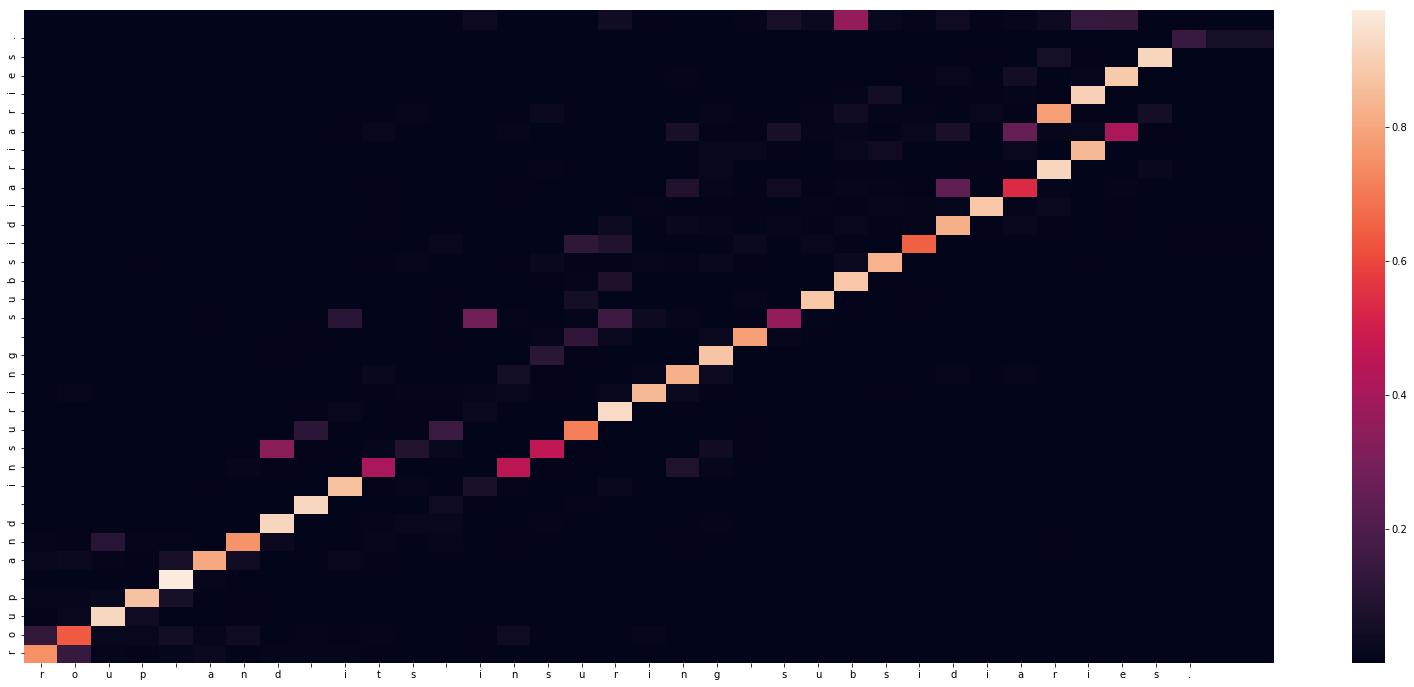

-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: roup and insuring subsidiariaries.


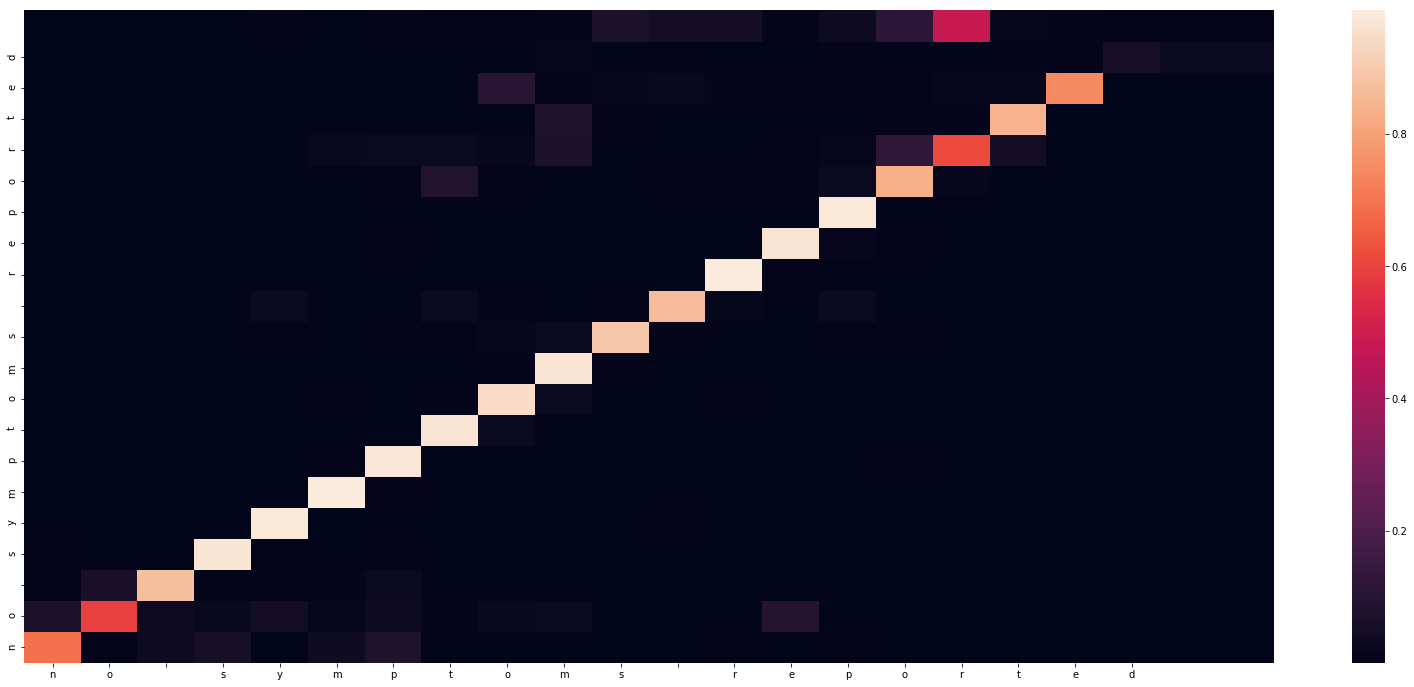

-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported


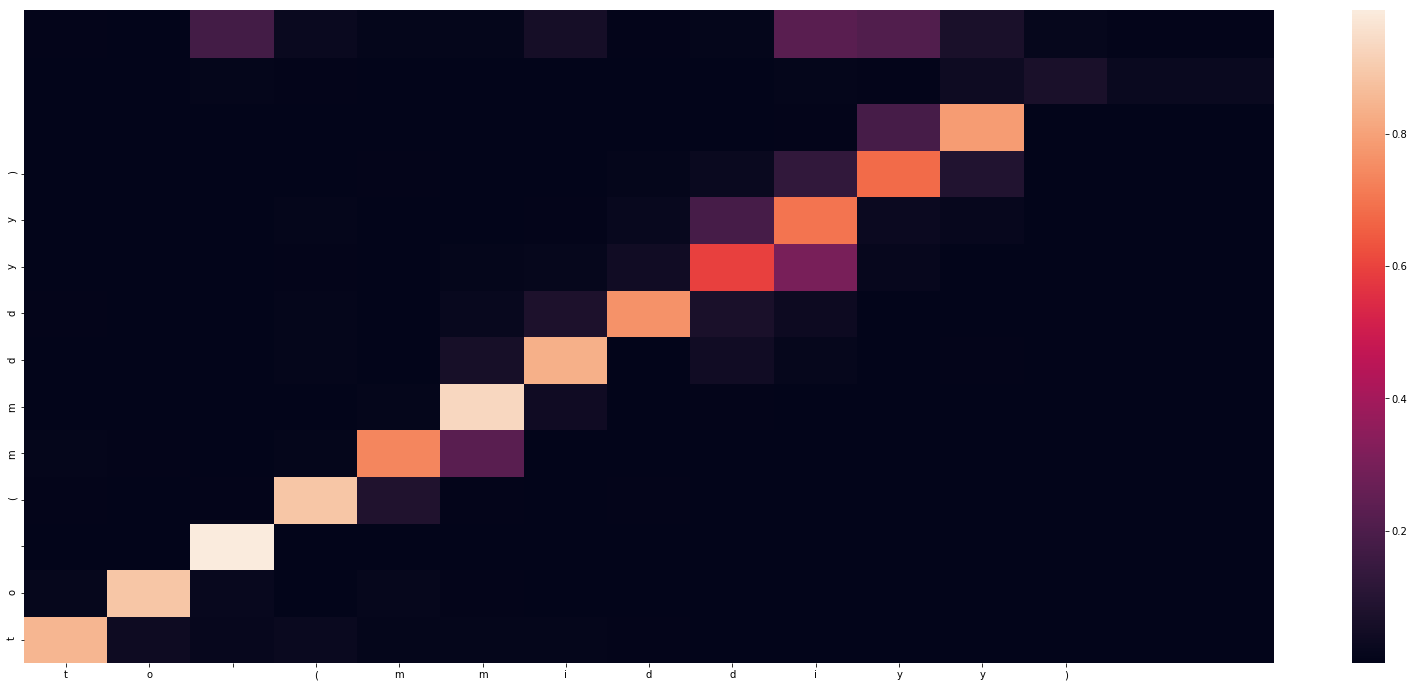

-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)


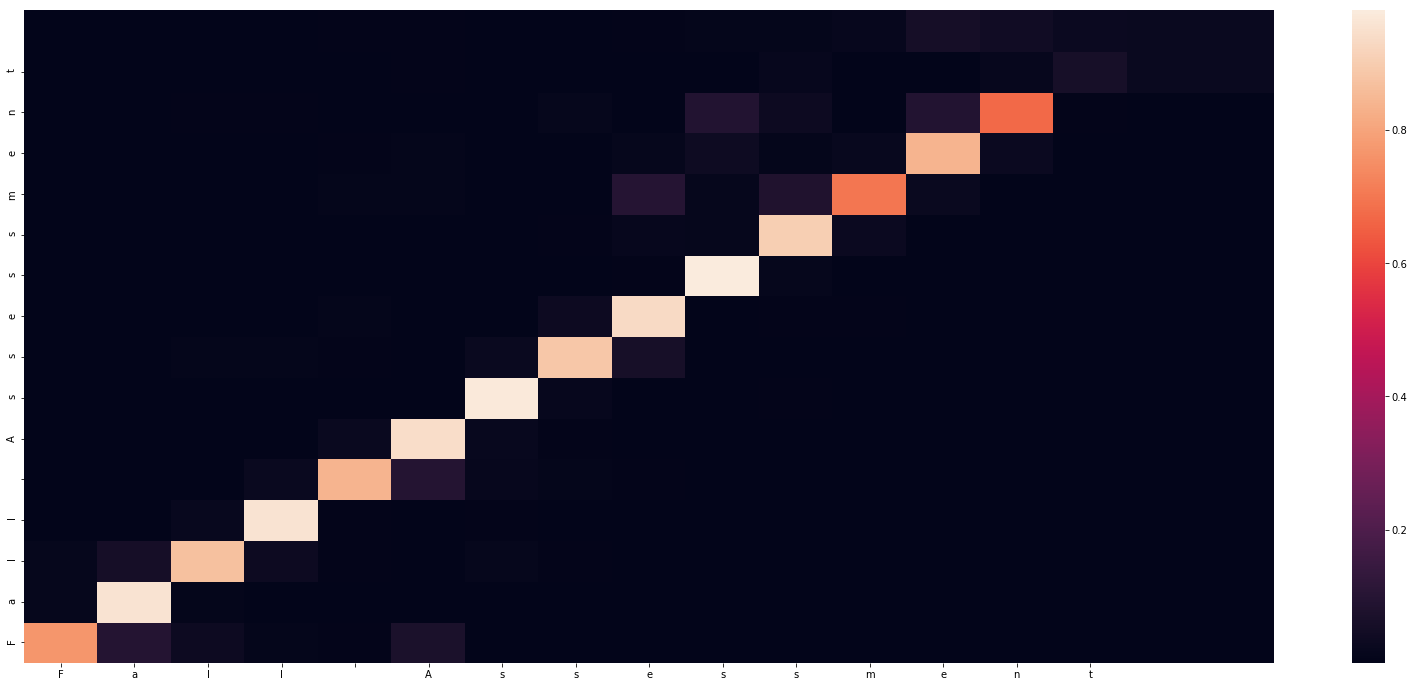

-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment


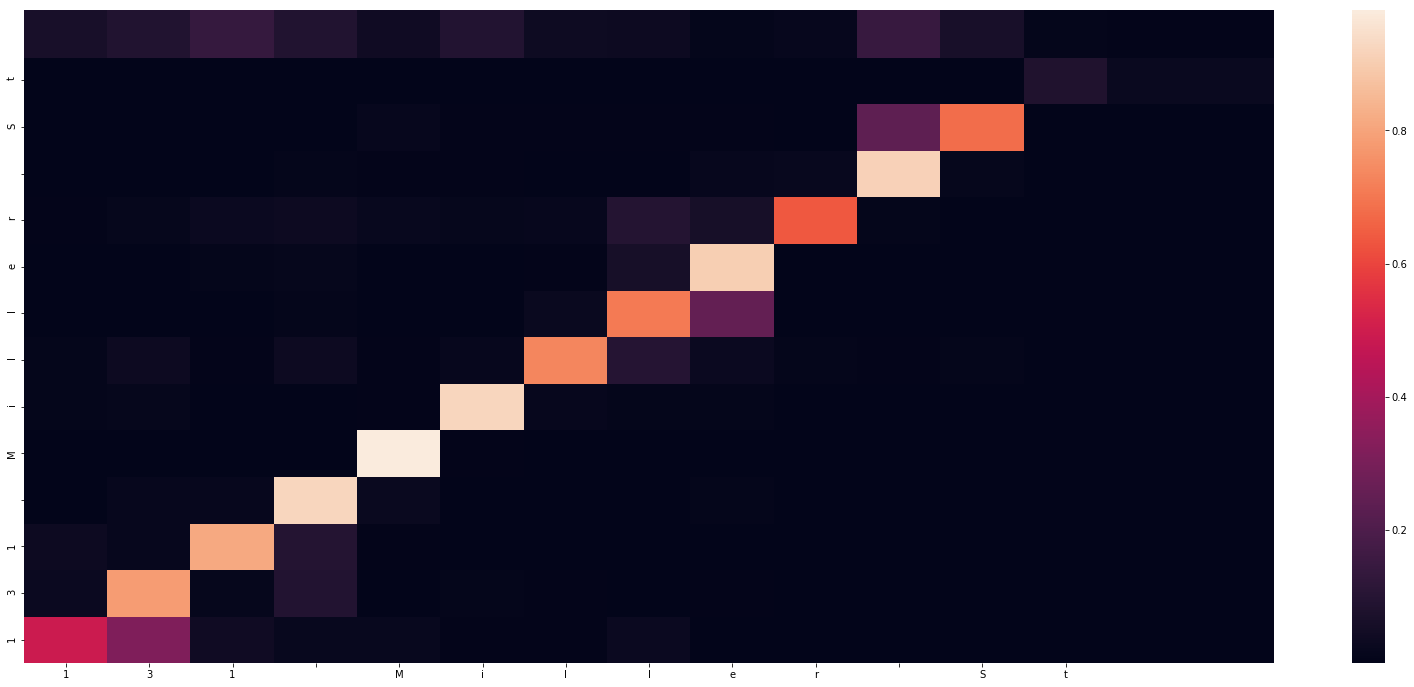

-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St


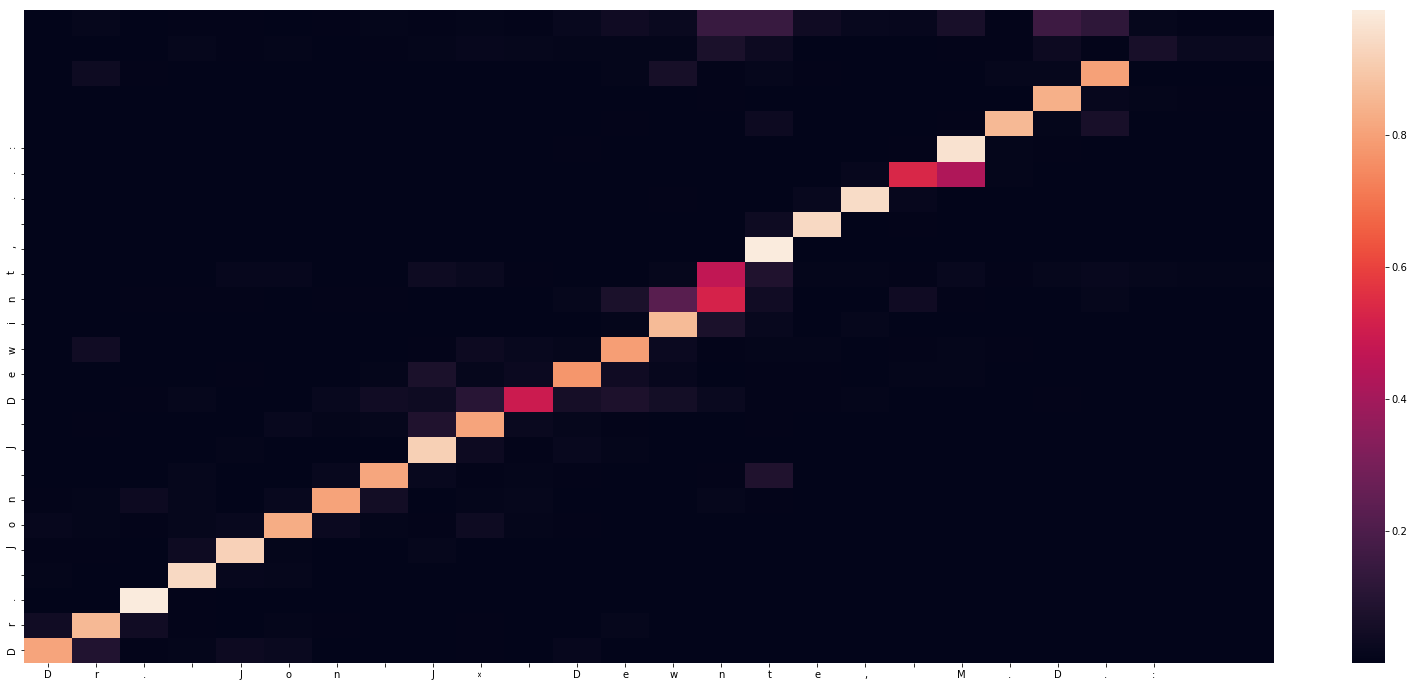

-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J Dewint, ..:


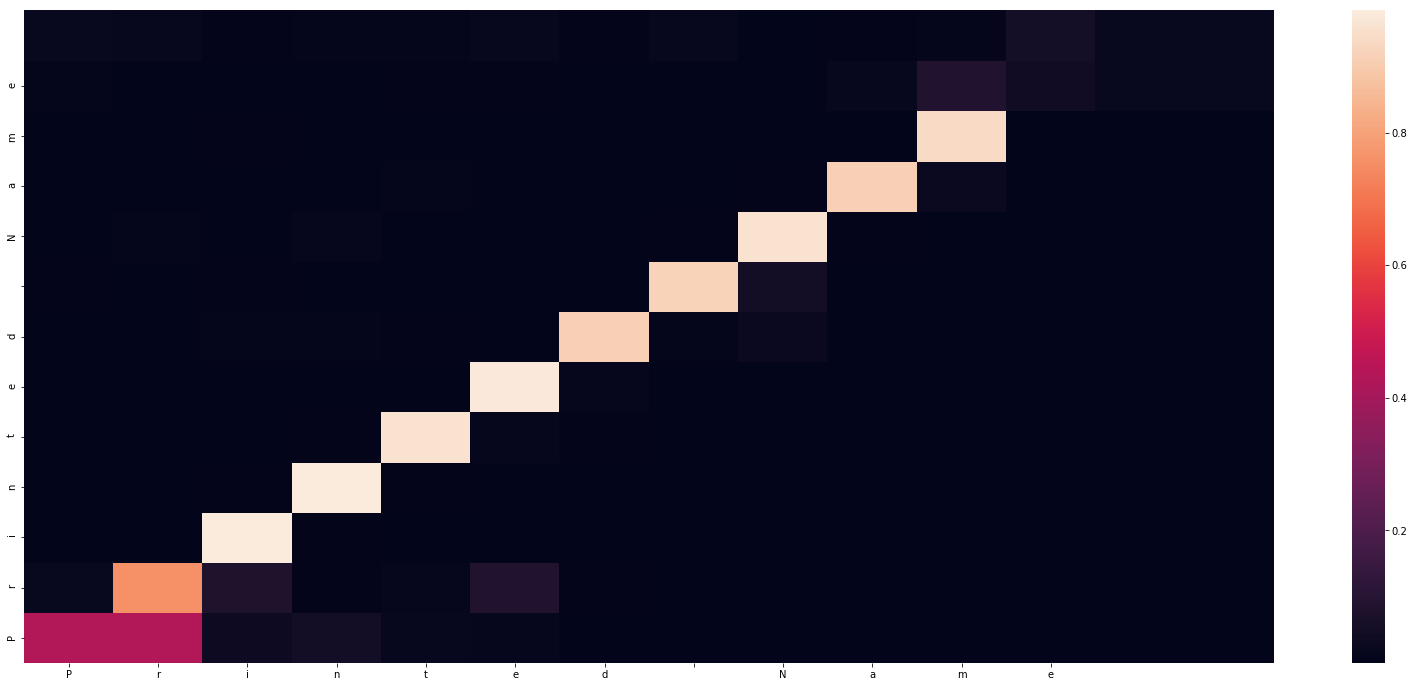

-
Input sentence: Printed Name
GT sentence: Printed Name

Decoded sentence: Printed Name


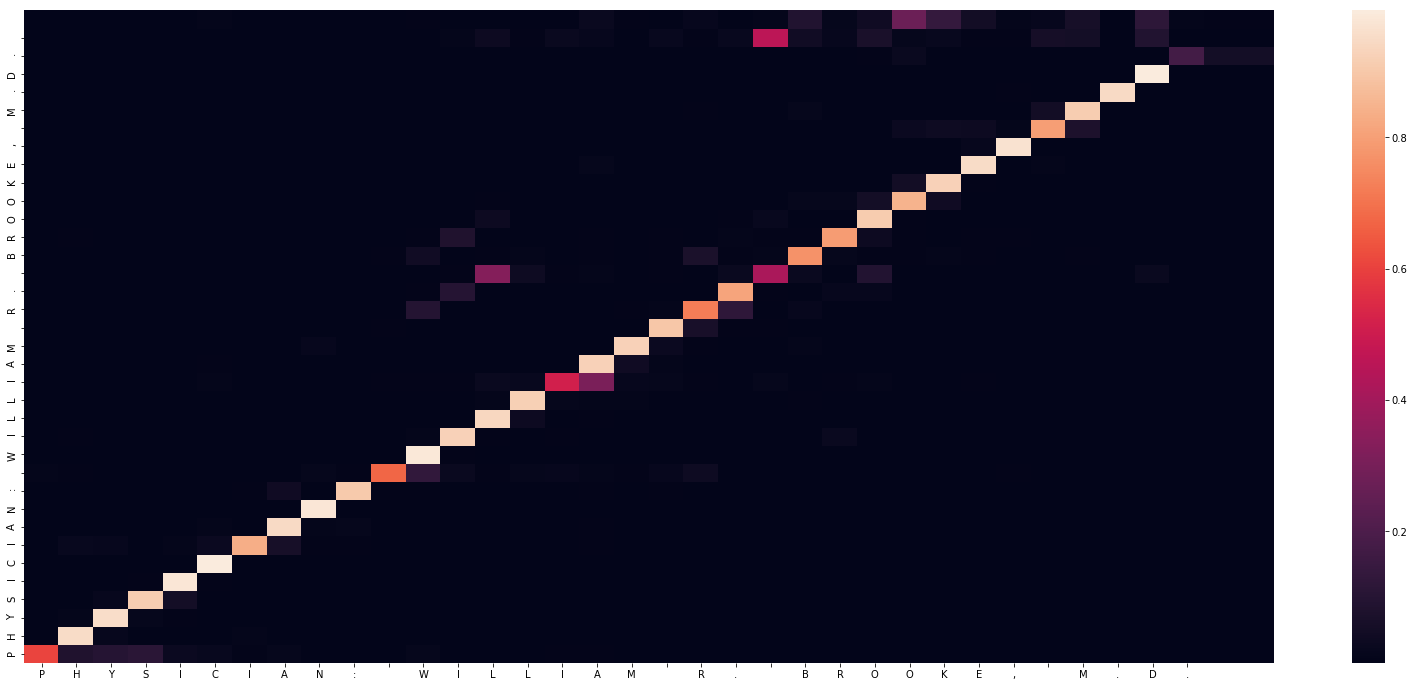

-
Input sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D.
GT sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D. 

Decoded sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D. 


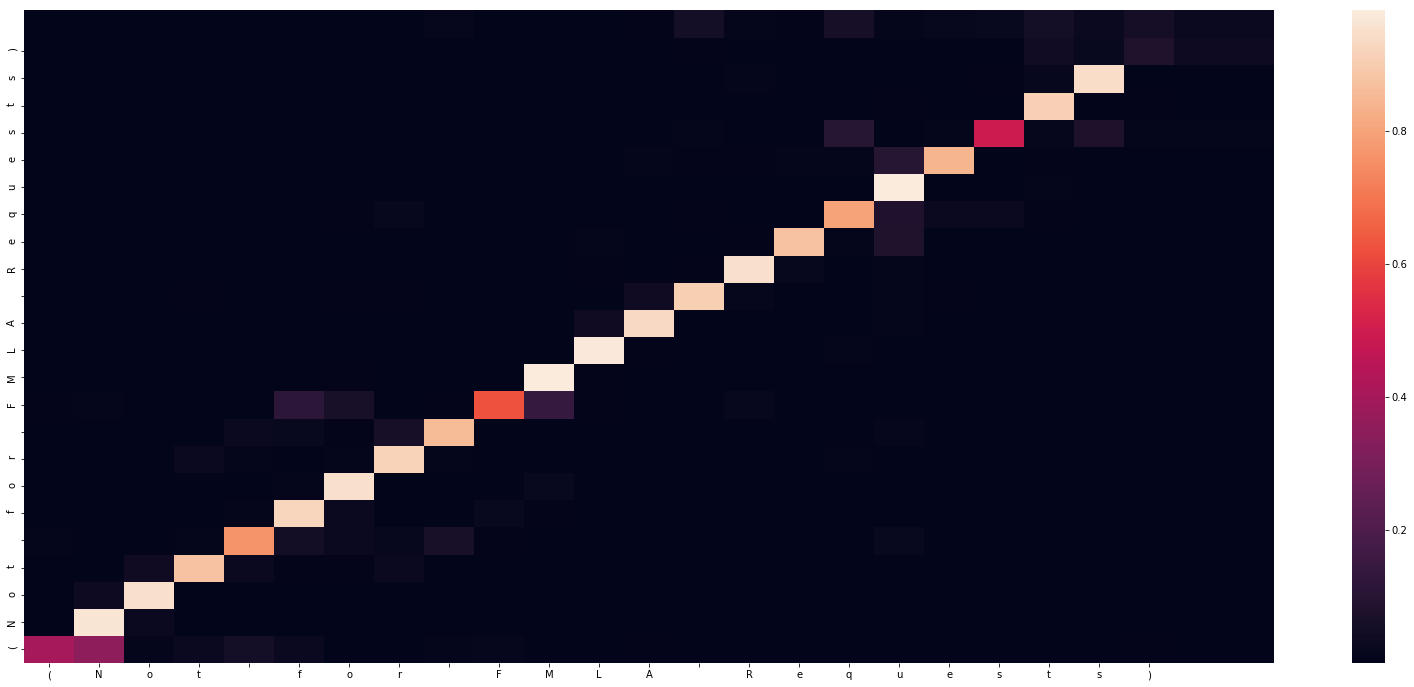

-
Input sentence: (Not for FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)


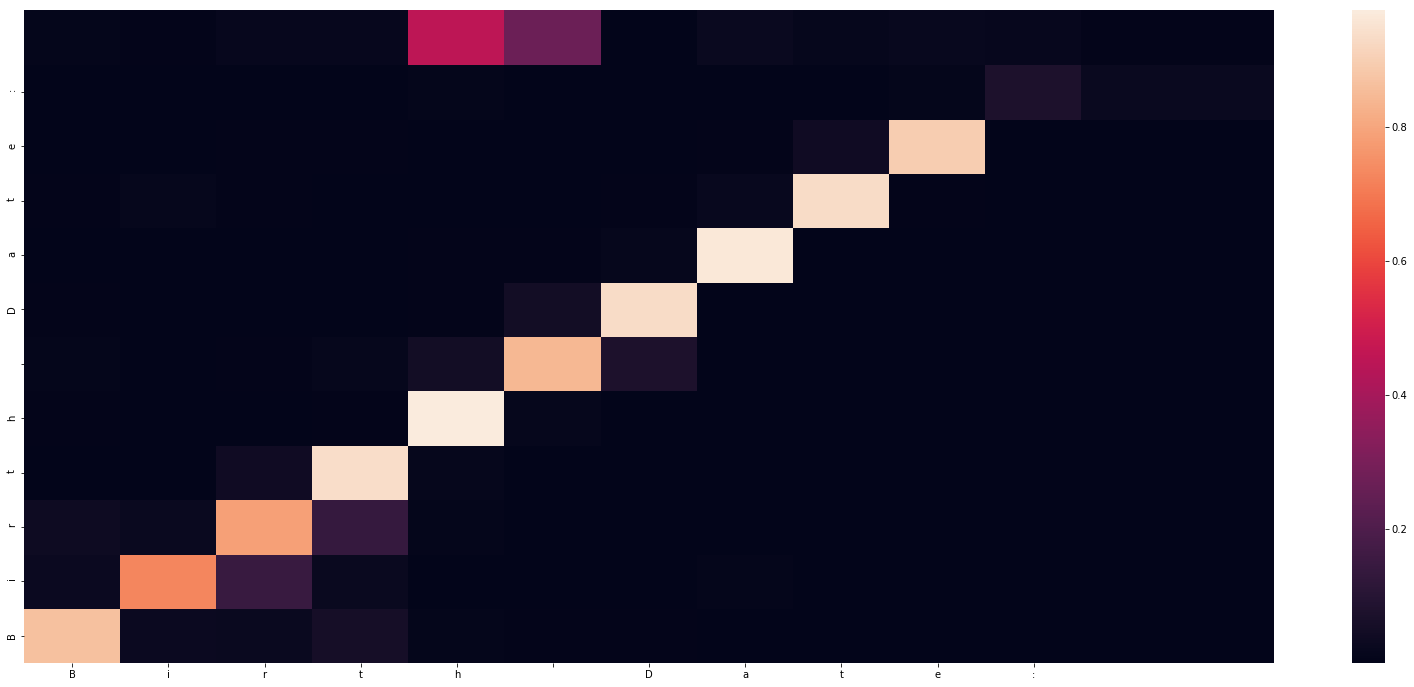

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:


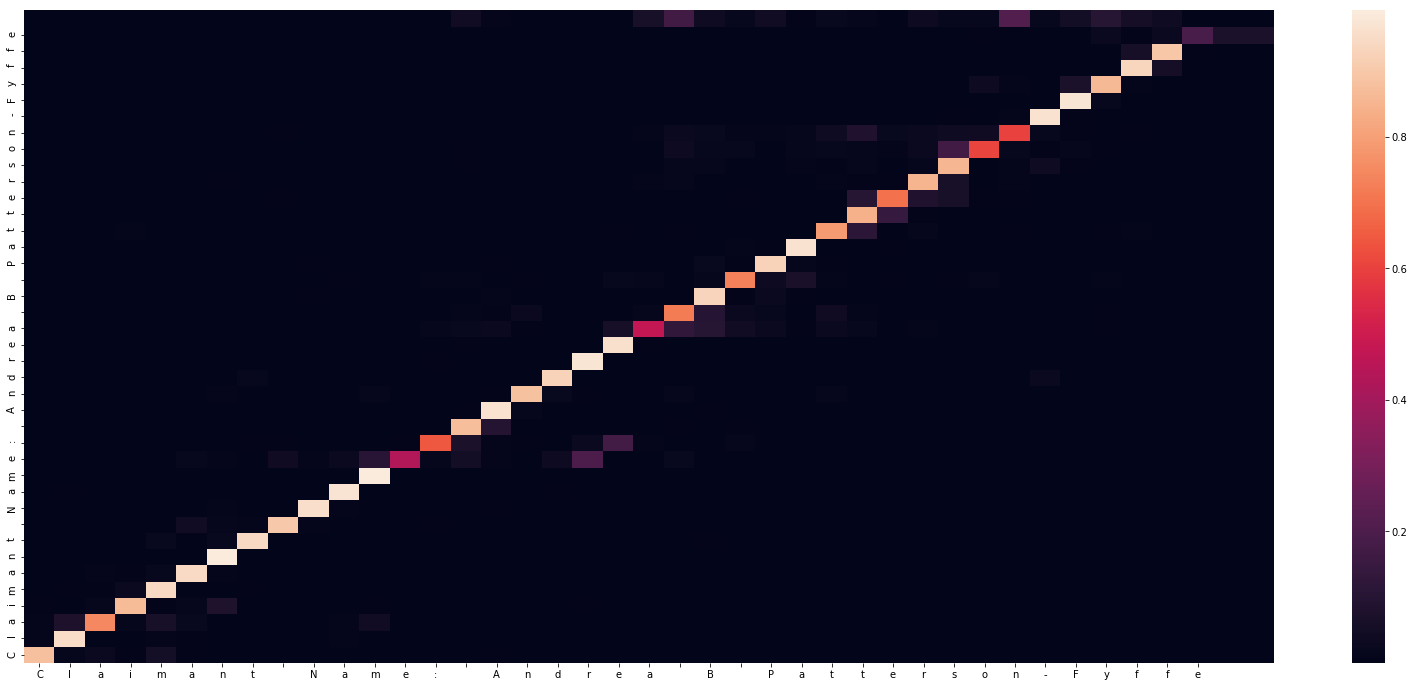

-
Input sentence: Claimant Name: Andrea B Patterson-Fyffe
GT sentence: Claimant Name: Andrea B Patterson-Fyffe

Decoded sentence: Claimant Name: Andrea B Patterson-Fyffe


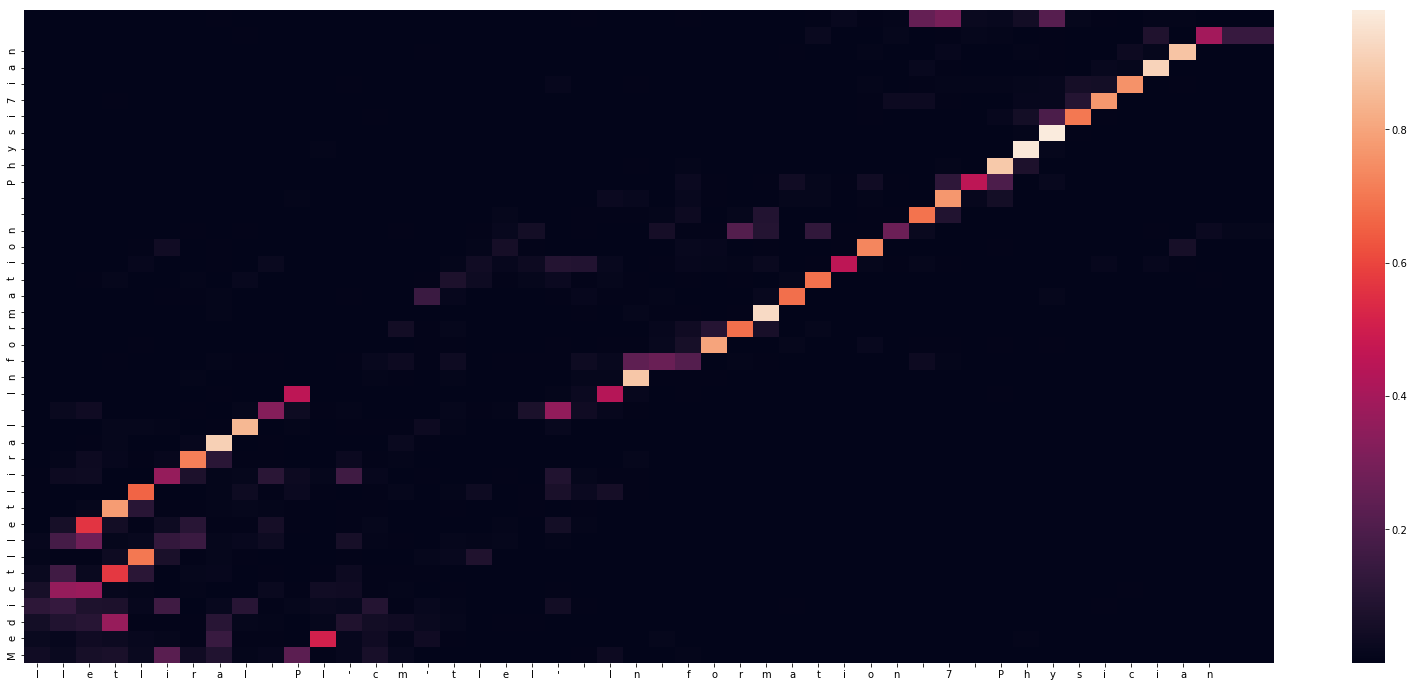

-
Input sentence: lletliral Pl'cm'tlel' In formation 7 Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medictlletliral Information  Physi7ian


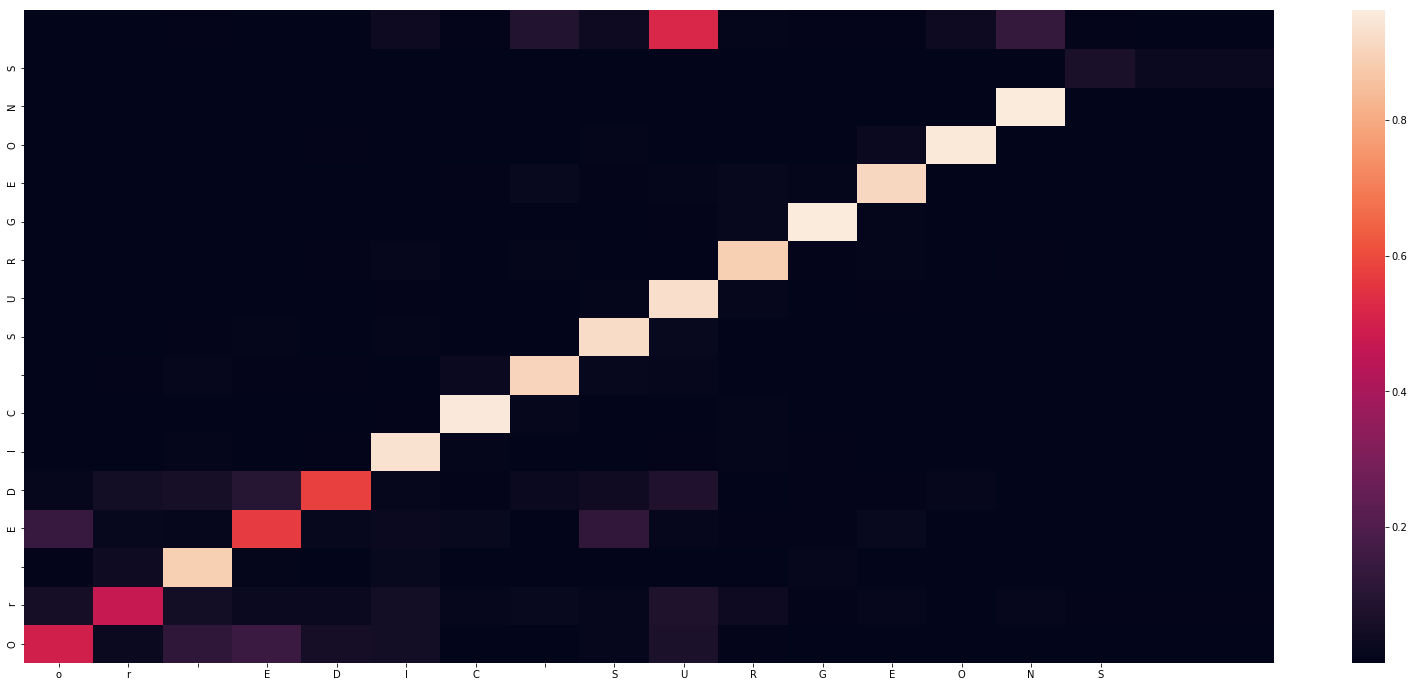

-
Input sentence: or EDIC SURGEONS
GT sentence: ORTHOPAEDIC SURGEONS

Decoded sentence: Or EDIC SURGEONS


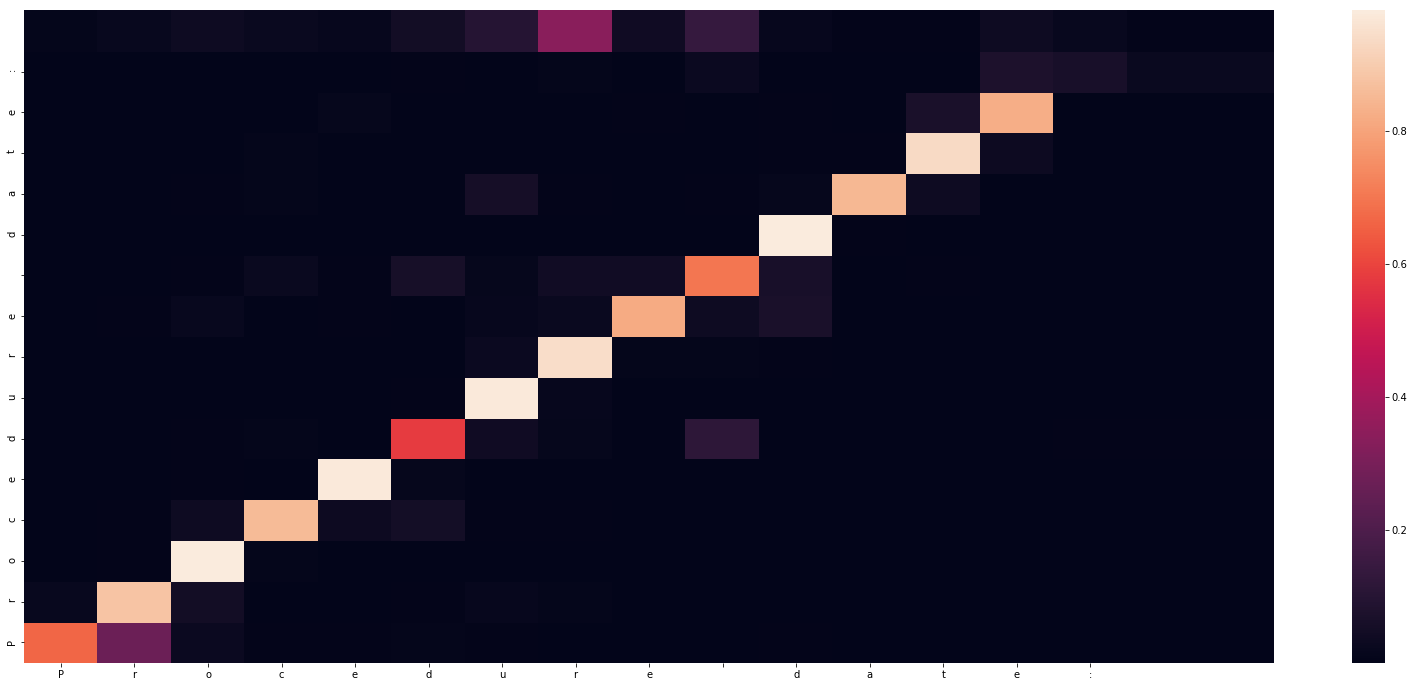

-
Input sentence: Procedure date:
GT sentence: Procedure date:

Decoded sentence: Procedure date:


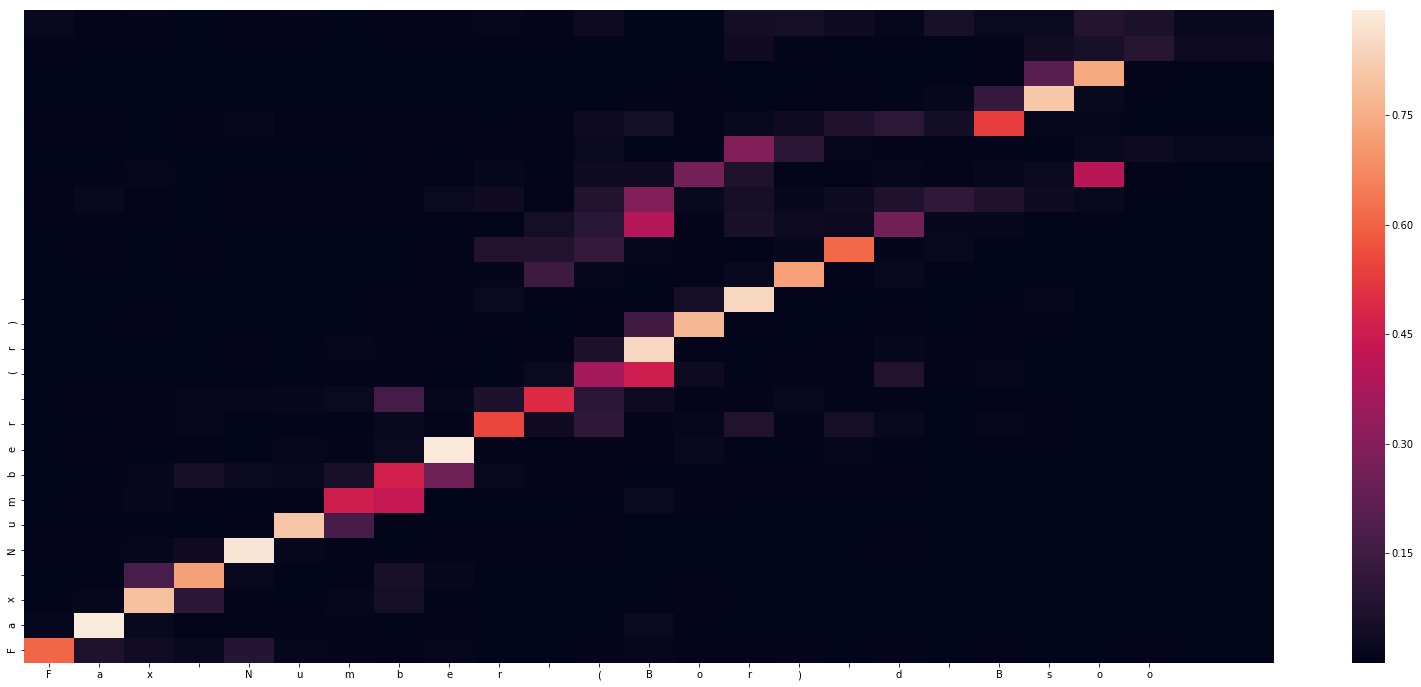

-
Input sentence: Fax Number (Bor) d Bsoo
GT sentence: Fax Number (308) 728-3500

Decoded sentence: Fax Number (r) 


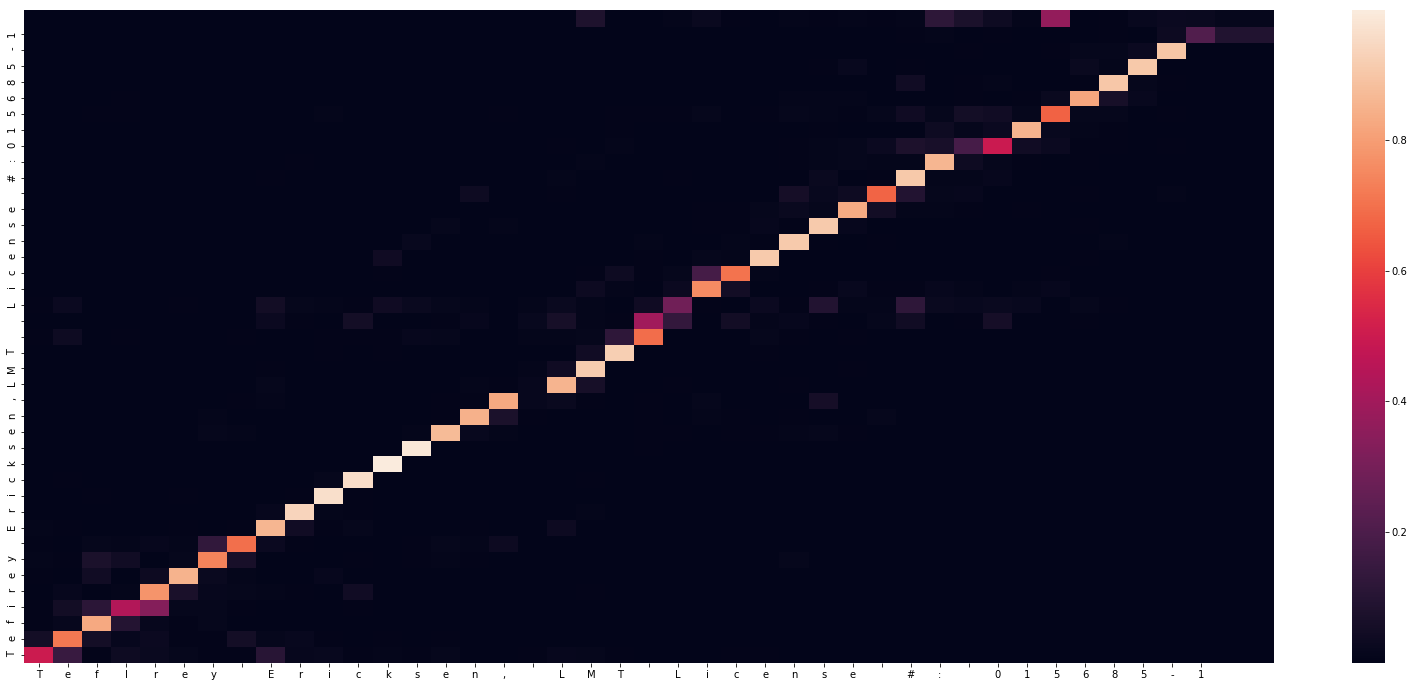

-
Input sentence: Teflrey Ericksen, LMT License #: 015685-1
GT sentence: Jeffrey Ericksen,LMT  License #:015685-1

Decoded sentence: Tefirey Ericksen,LMT  License #:015685-1


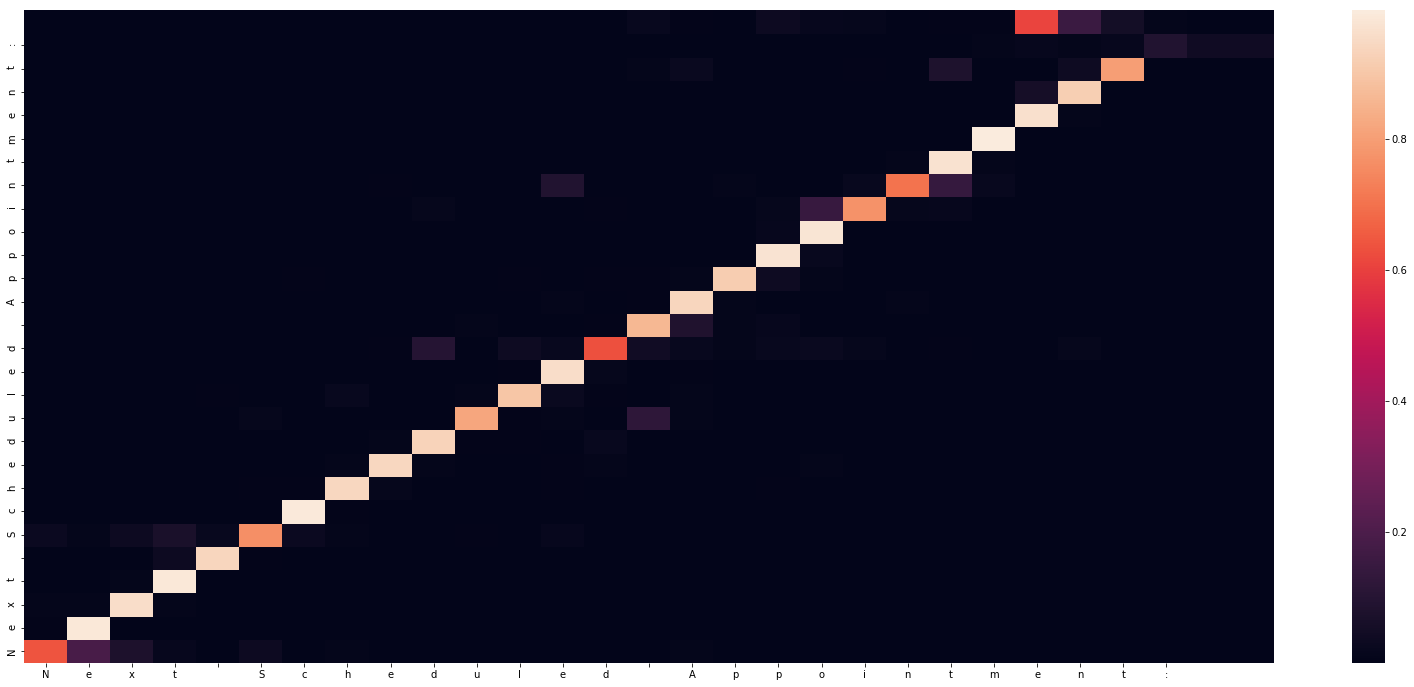

-
Input sentence: Next Scheduled Appointment:
GT sentence: Next Scheduled Appointment:

Decoded sentence: Next Scheduled Appointment:


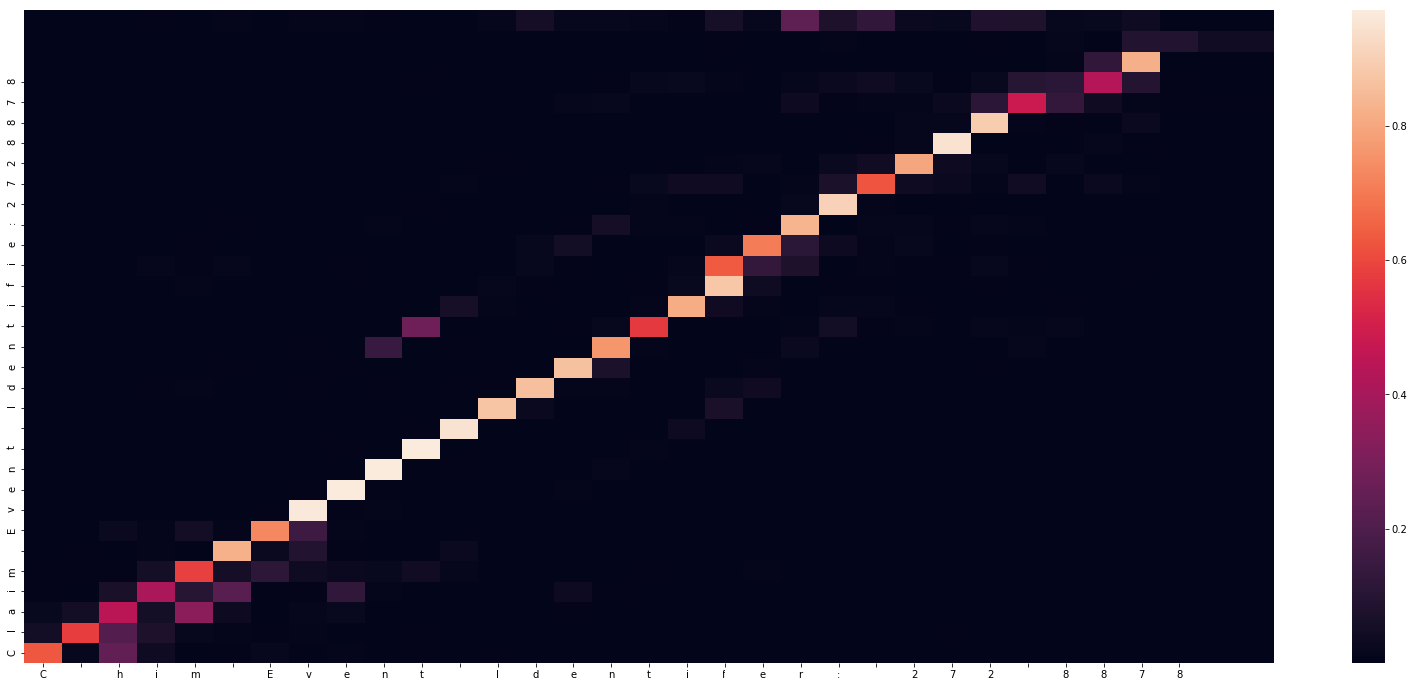

-
Input sentence: C him Event Identiﬁer: 272 8878
GT sentence: Claim Event Identifier: 2728878

Decoded sentence: Claim Event Identifie:2728878


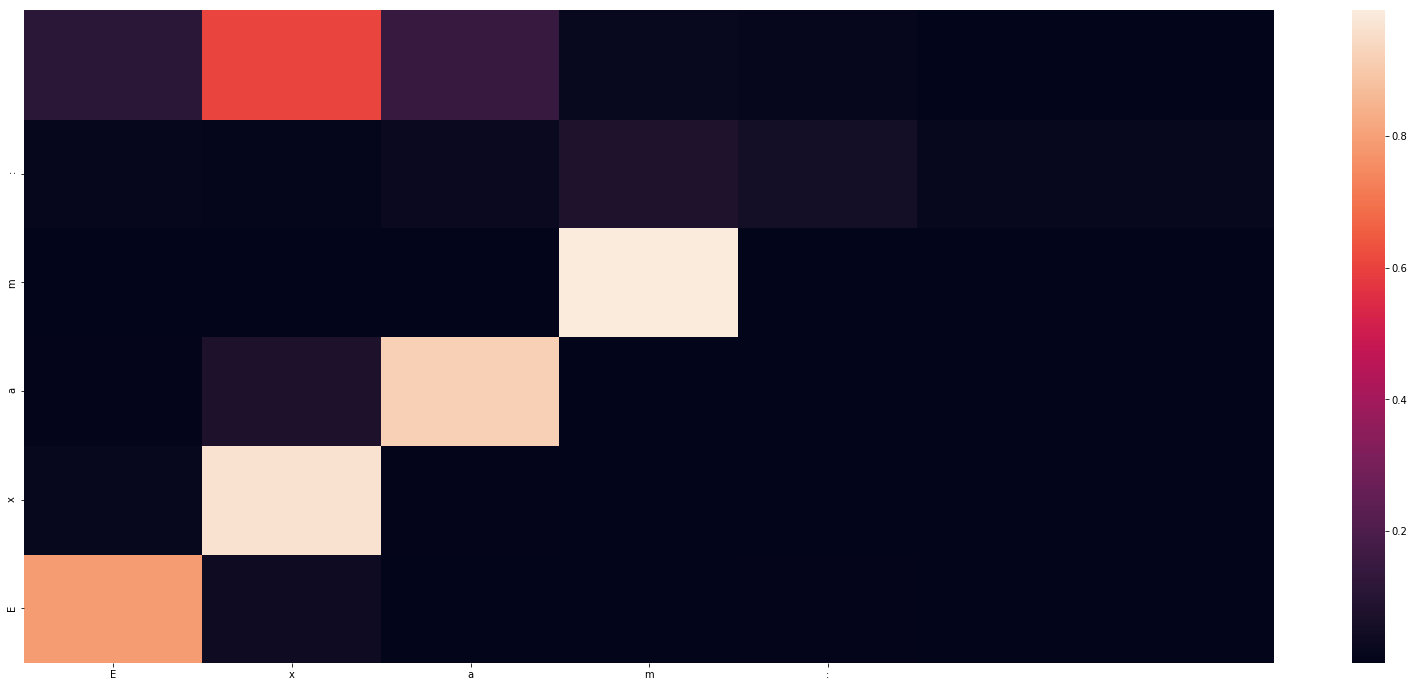

-
Input sentence: Exam:
GT sentence: Exam:

Decoded sentence: Exam:


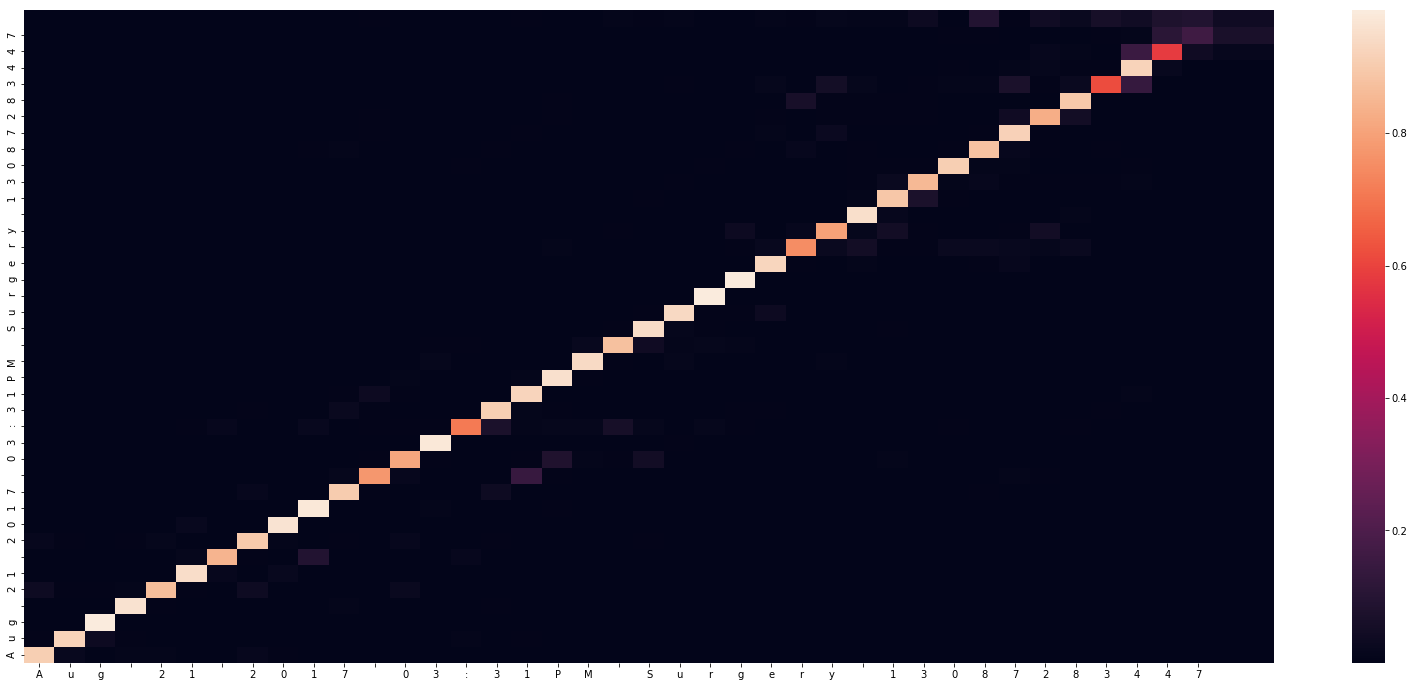

-
Input sentence: Aug 21 2017 03:31PM Surgery 13087283447
GT sentence: Aug 21 2017 03:31PM Surgery 13087283447

Decoded sentence: Aug 21 2017 03:31PM Surgery 13087283447


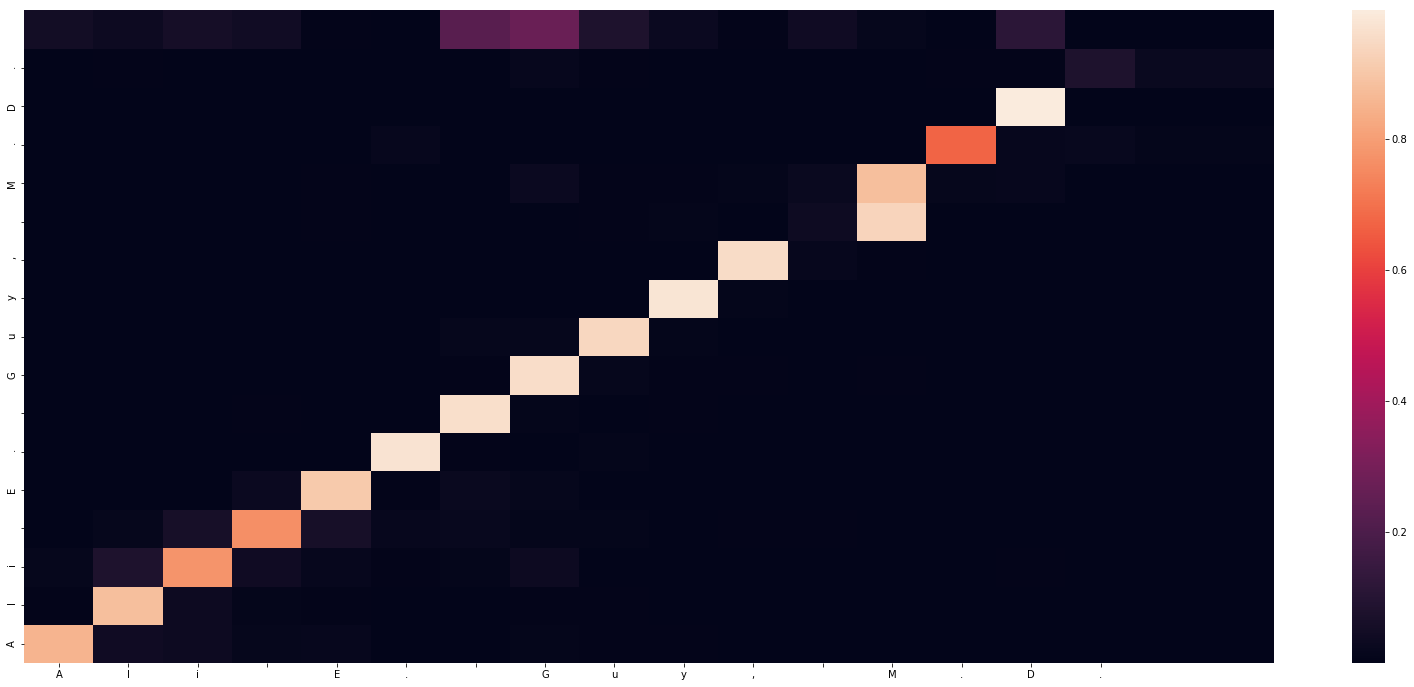

-
Input sentence: Ali E. Guy, M.D.
GT sentence: Ali E. Guy,M.D.

Decoded sentence: Ali E. Guy, M.D.


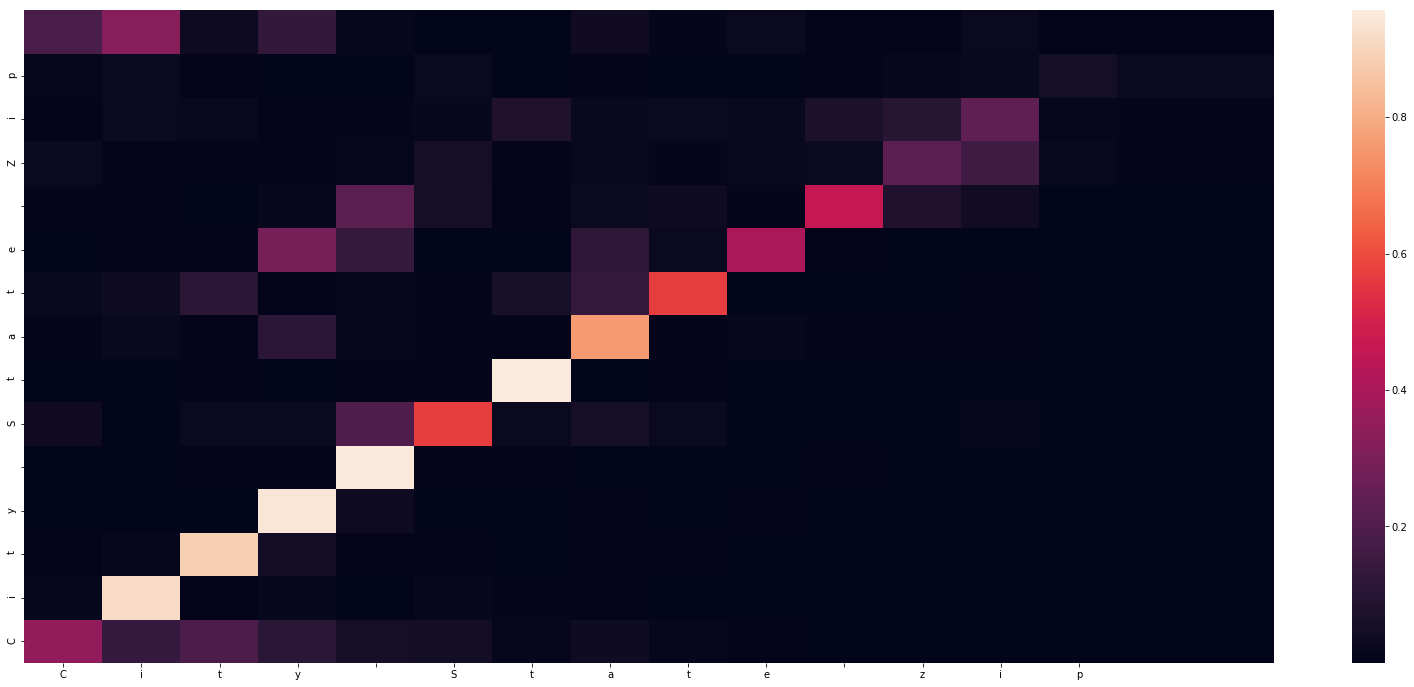

-
Input sentence: City State zip
GT sentence: City State Zip

Decoded sentence: City State Zip


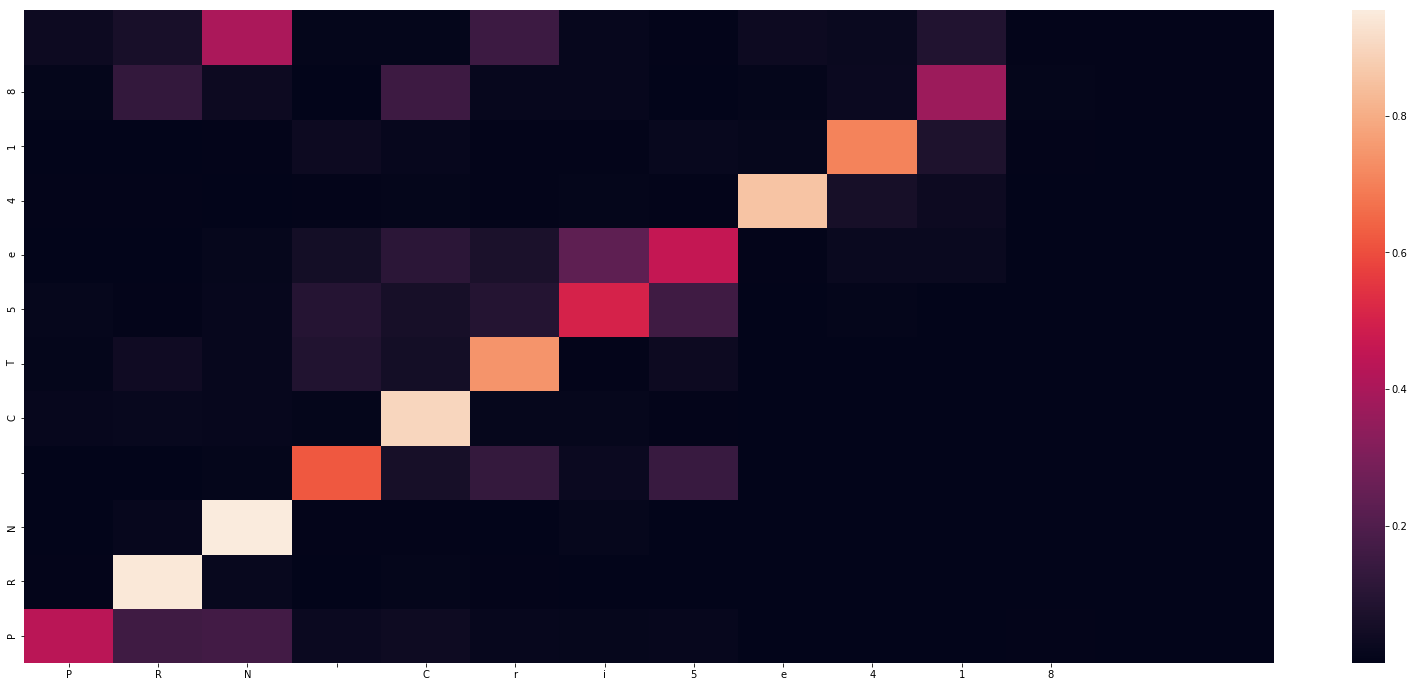

-
Input sentence: PRN Cri5e418
GT sentence: PRN CT156418

Decoded sentence: PRN CT5e418


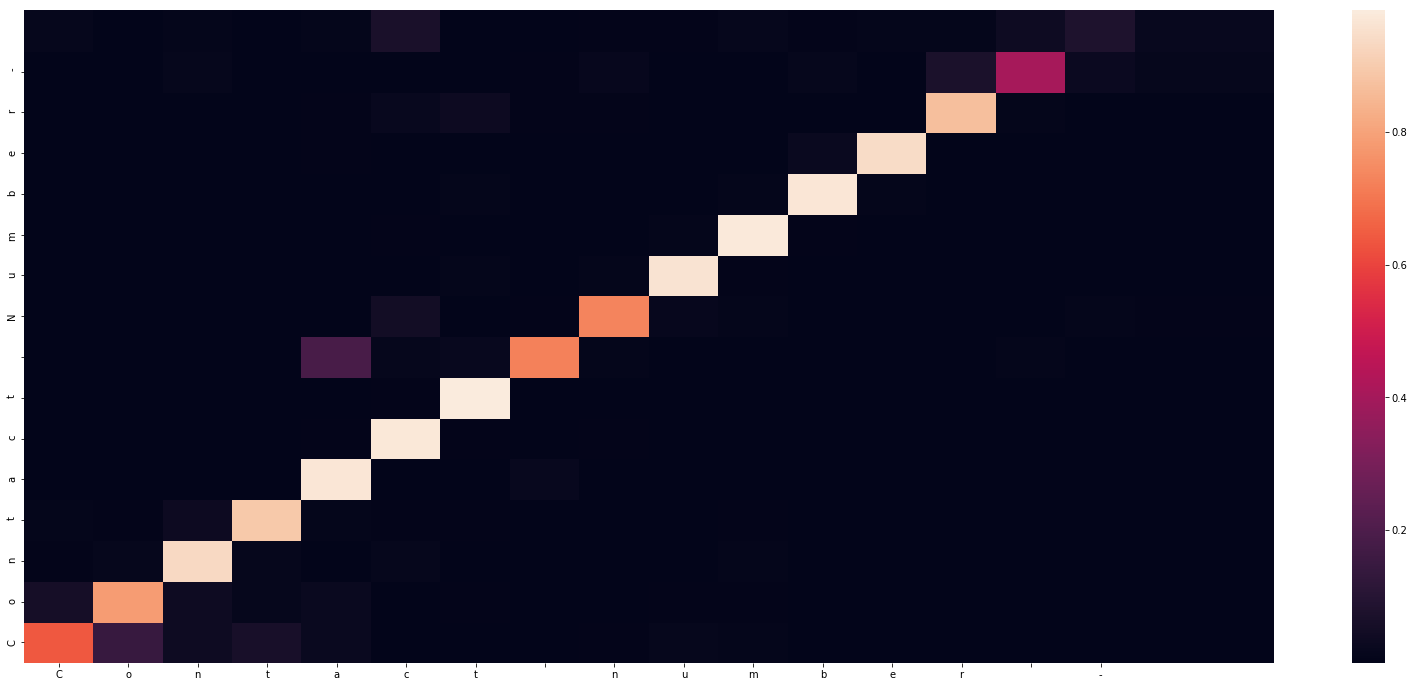

-
Input sentence: Contact number -
GT sentence: Contact number -

Decoded sentence: Contact Number-


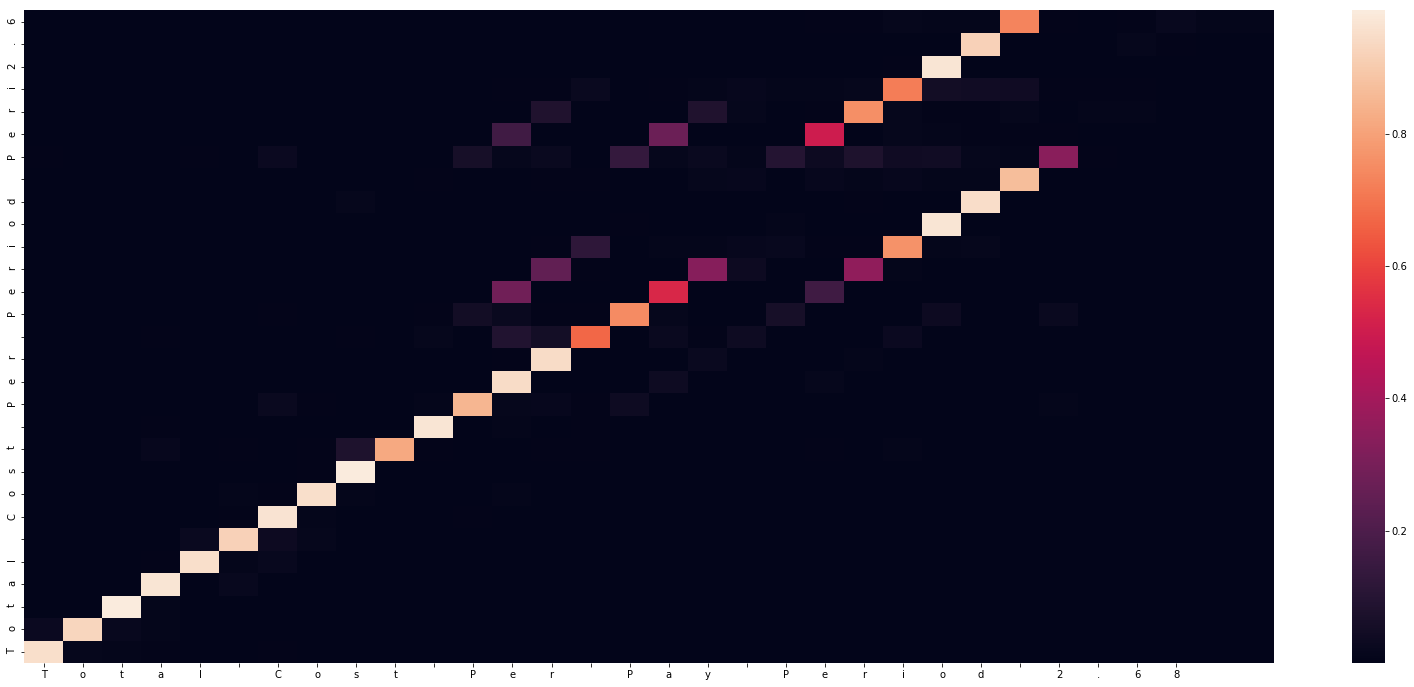

-
Input sentence: Total Cost Per Pay Period 2.68
GT sentence: Total Cost Per Pay Period 2.68

Decoded sentence: Total Cost Per Period Peri2.6


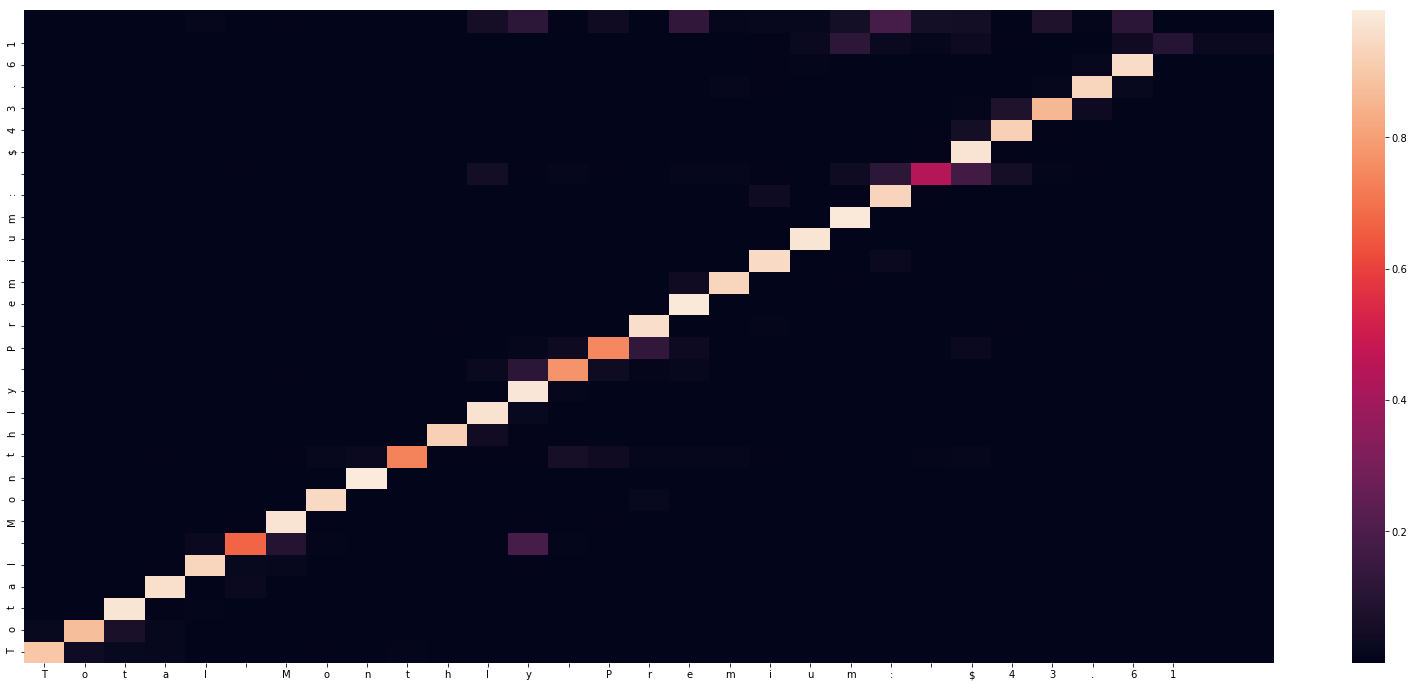

-
Input sentence: Total Monthly Premium: $43.61
GT sentence: Total Monthly Premium: $43.61

Decoded sentence: Total Monthly Premium: $43.61


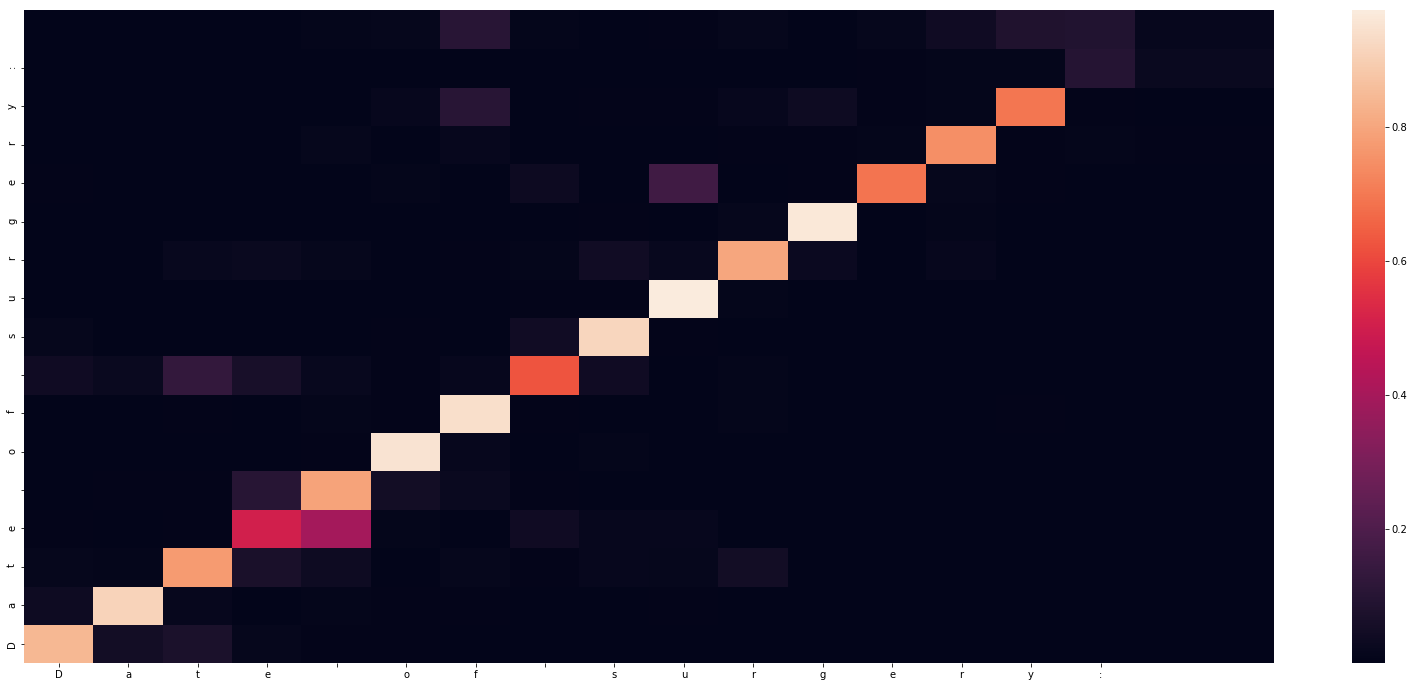

-
Input sentence: Date of surgery:
GT sentence: Date of surgery:

Decoded sentence: Date of surgery:


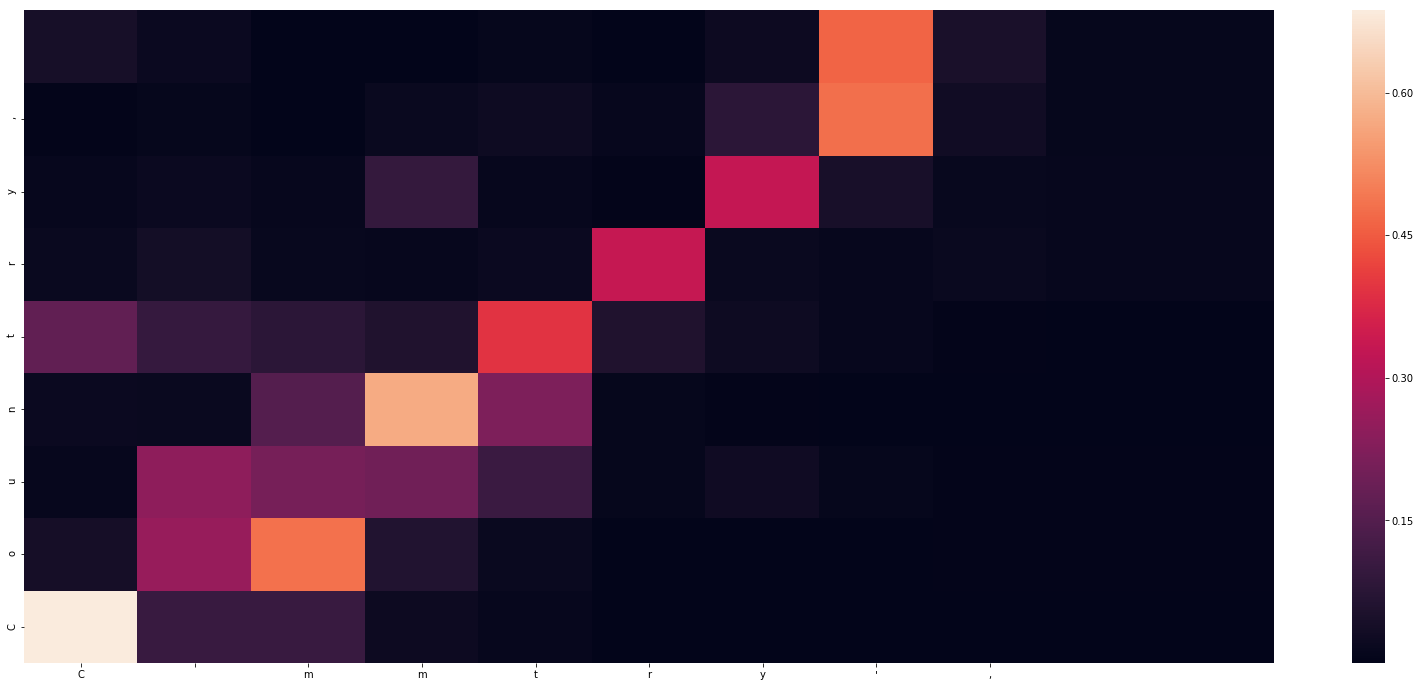

-
Input sentence: C mmtry',
GT sentence: Country:

Decoded sentence: Country,


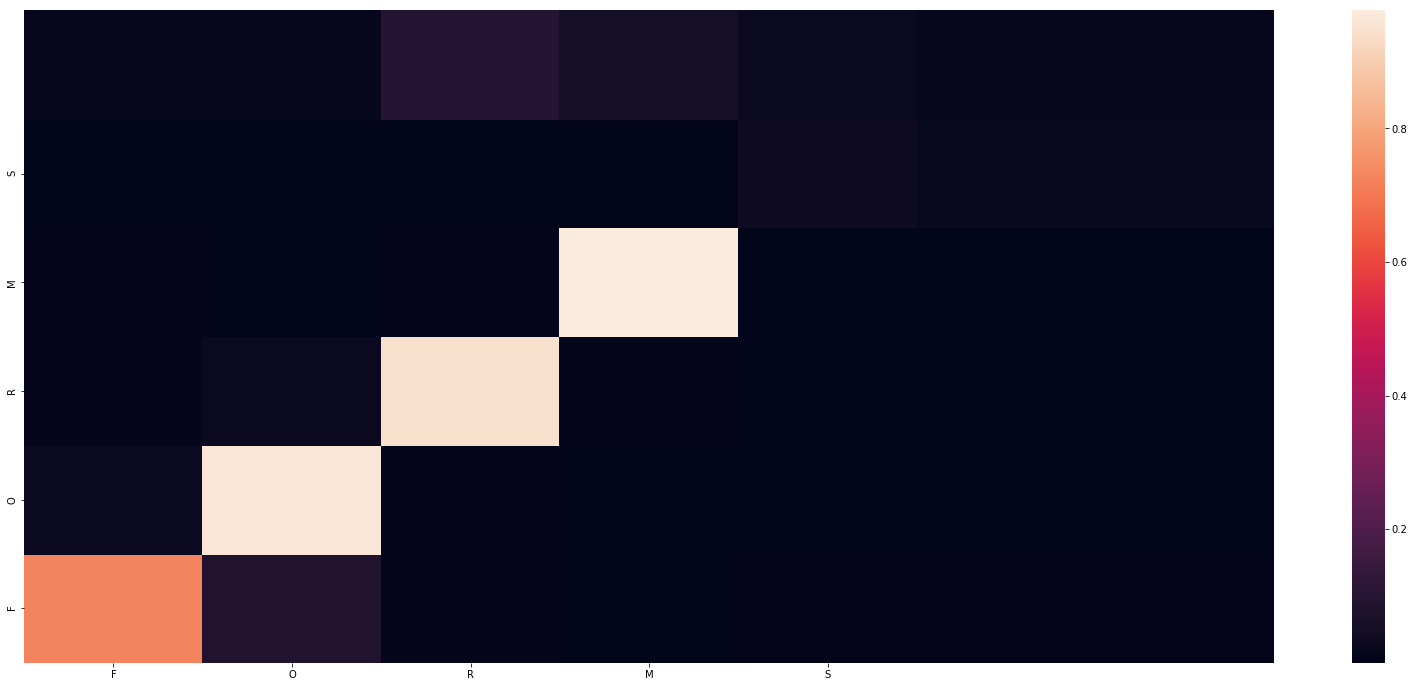

-
Input sentence: FORMS
GT sentence: FORMS

Decoded sentence: FORMS


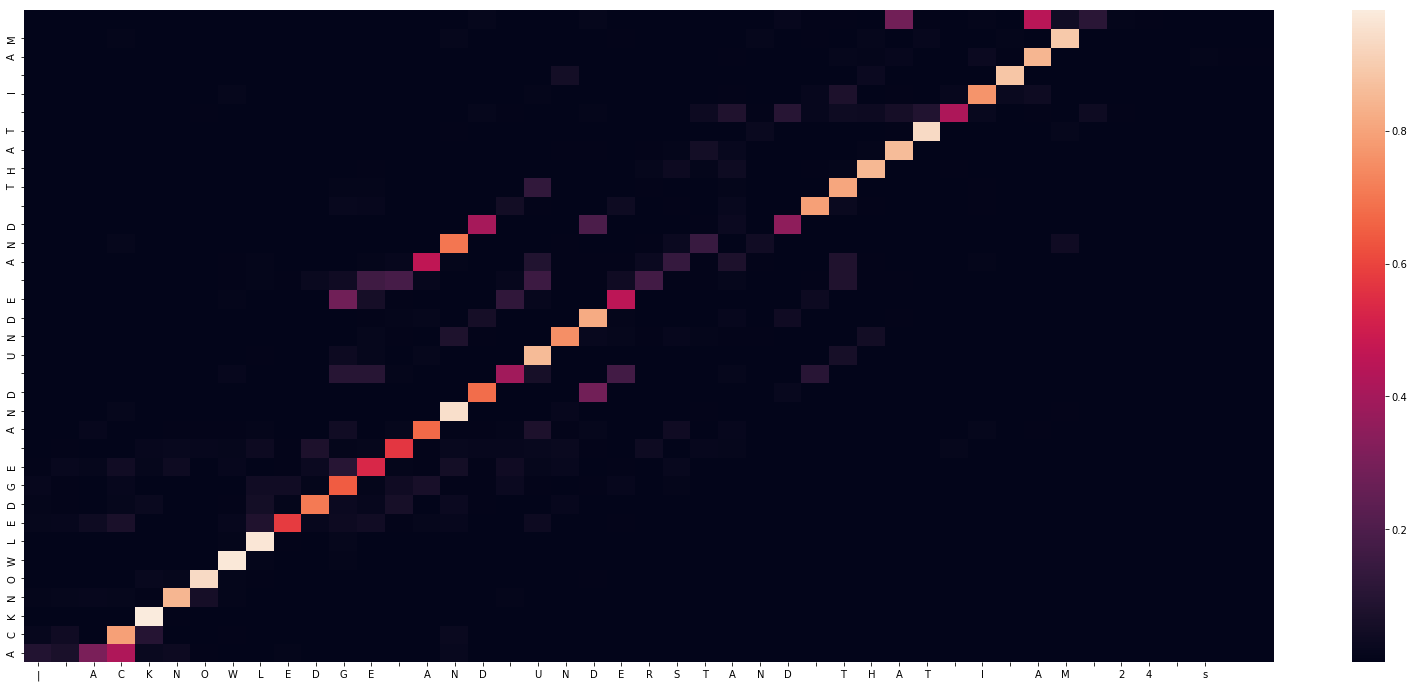

-
Input sentence: | ACKNOWLEDGE AND UNDERSTAND THAT I AM 24 s
GT sentence: I ACKNOWLEDGE AND UNDERSTAND THAT I AM

Decoded sentence: ACKNOWLEDGE AND UNDE AND THAT I AM


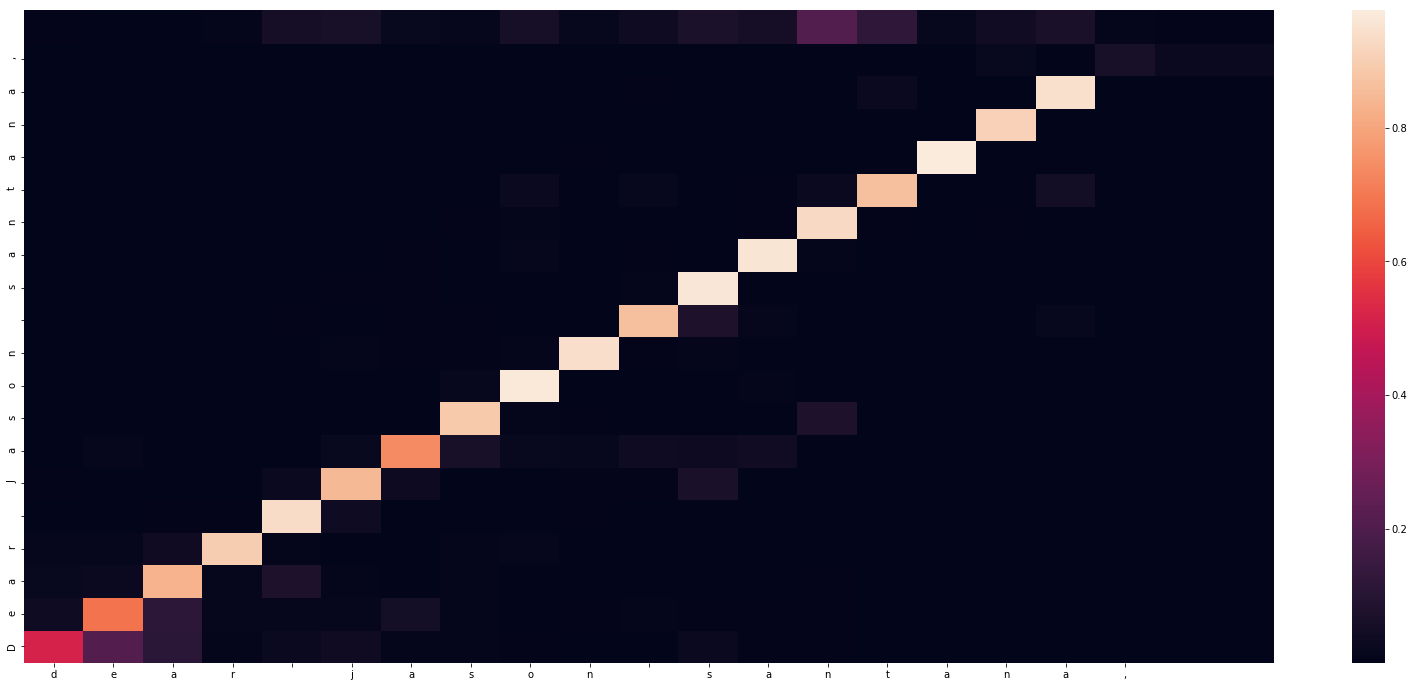

-
Input sentence: dear jason santana,
GT sentence: Dear JASON SANTANA,

Decoded sentence: Dear Jason santana,


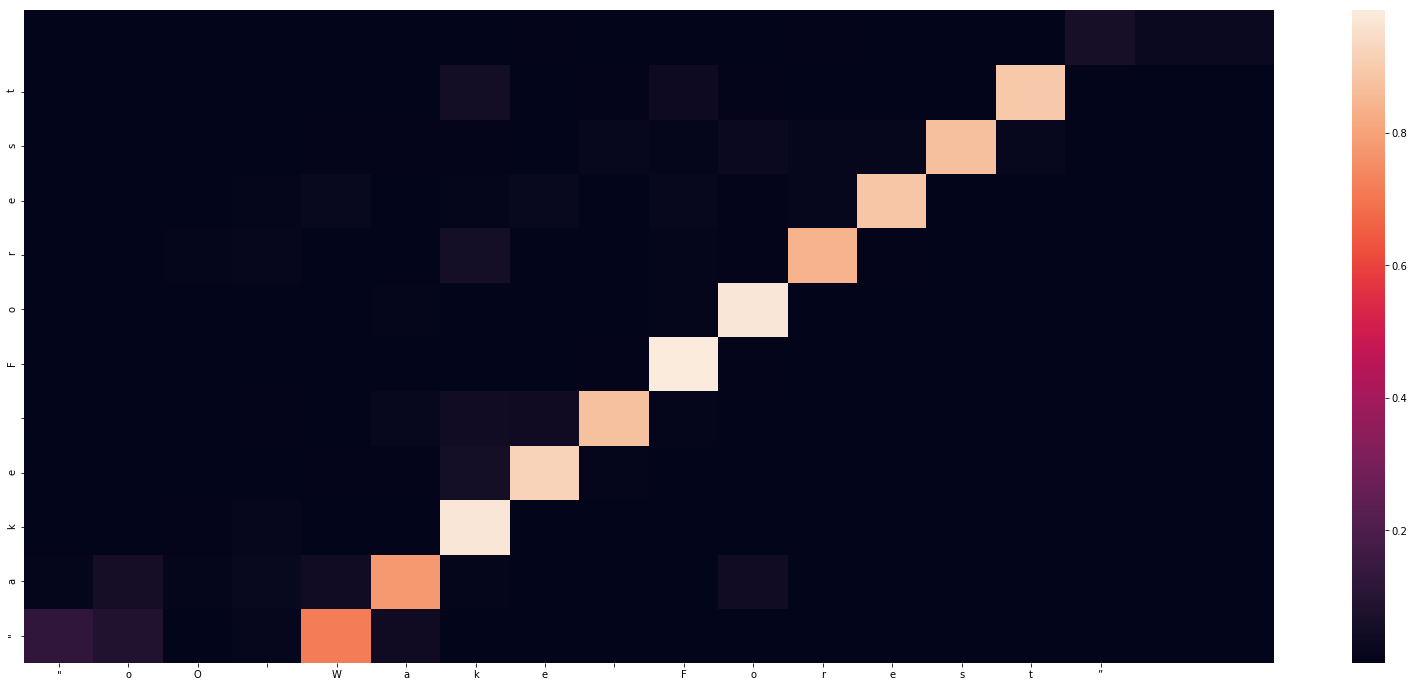

-
Input sentence: "oO Wake Forest”
GT sentence: Wake Forest

Decoded sentence: "ake Forest


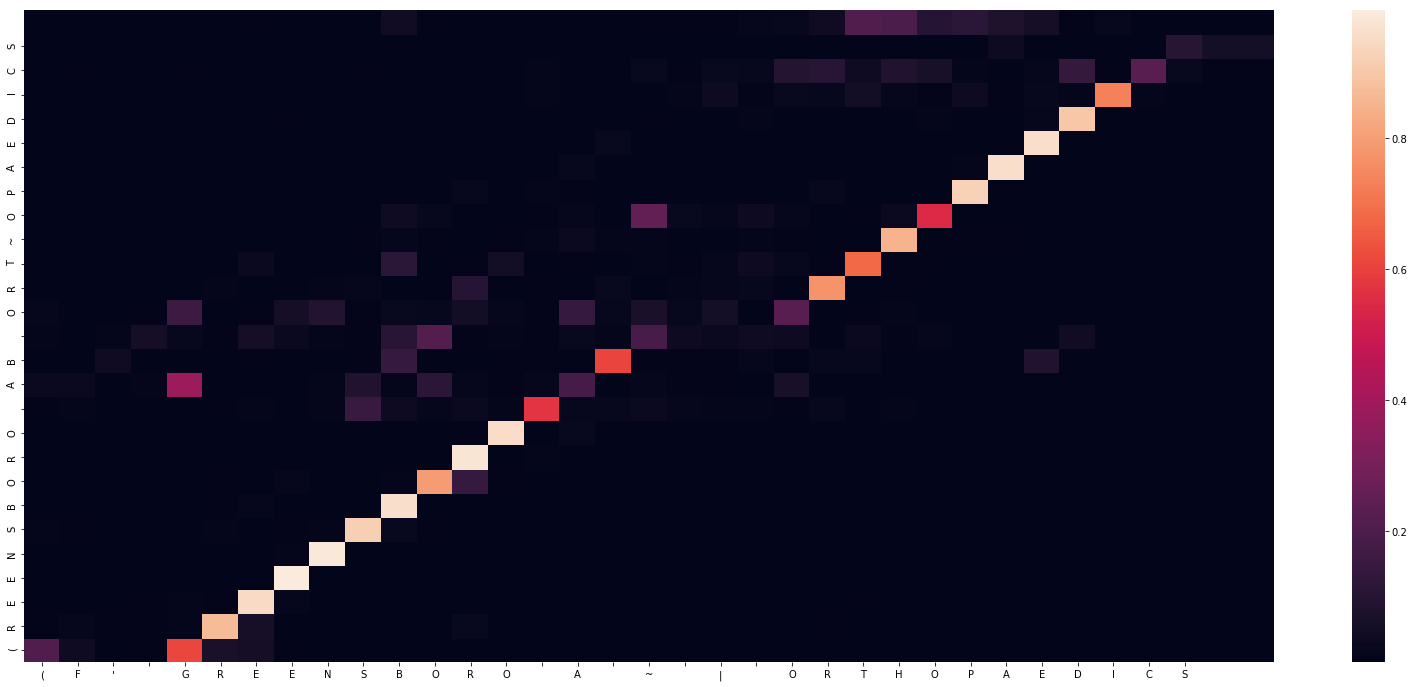

-
Input sentence: (F' GREENSBORO A ~ | ORTHOPAEDICS
GT sentence: GREENSBORO ORTHOPAEDICS

Decoded sentence: (REENSBORO AB ORT~OPAEDICS


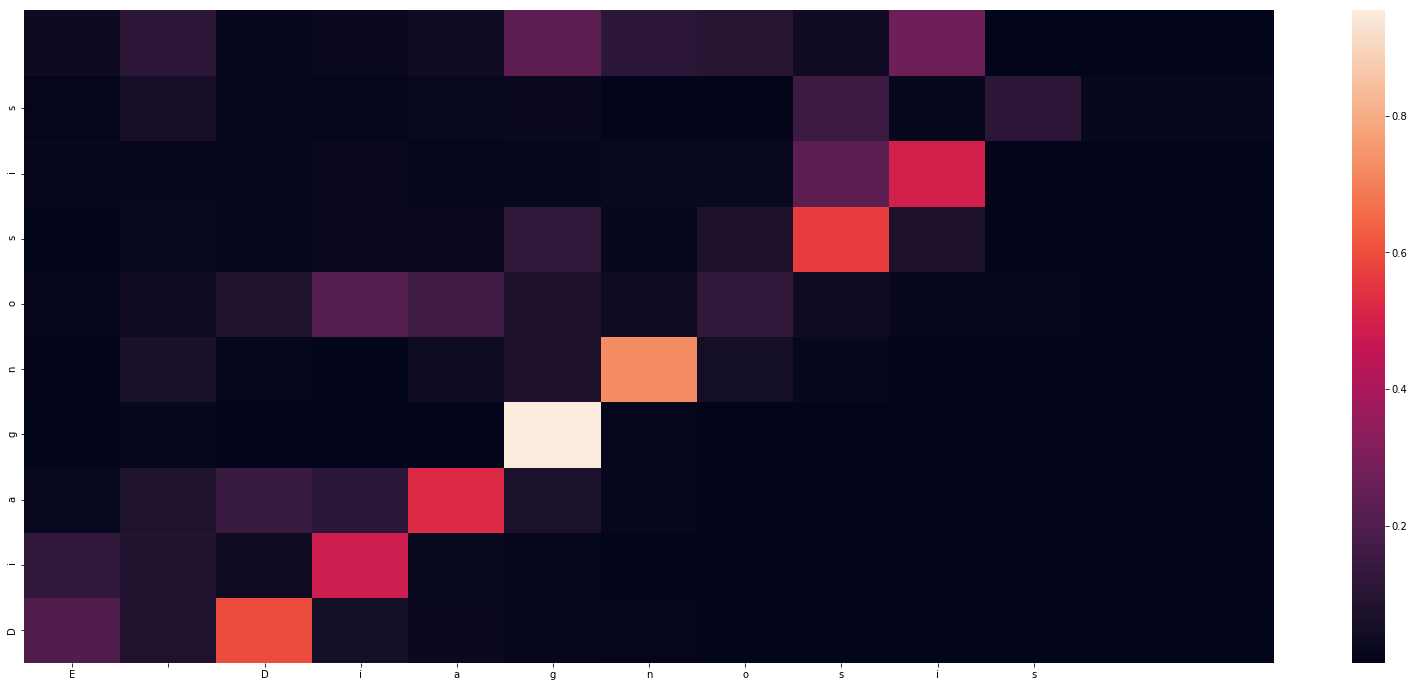

-
Input sentence: E Diagnosis
GT sentence: Diagnosis Code (ICD)

Decoded sentence: Diagnosis


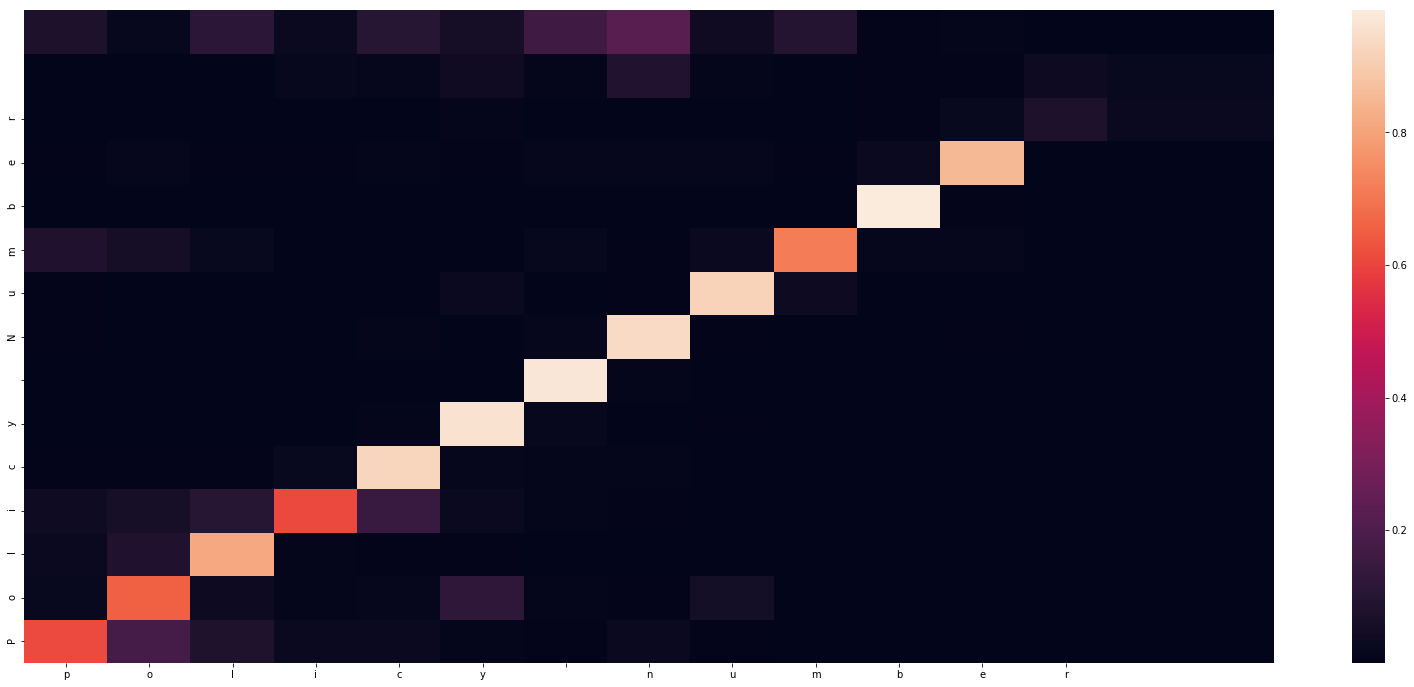

-
Input sentence: policy number
GT sentence: Policy Number:

Decoded sentence: Policy Number


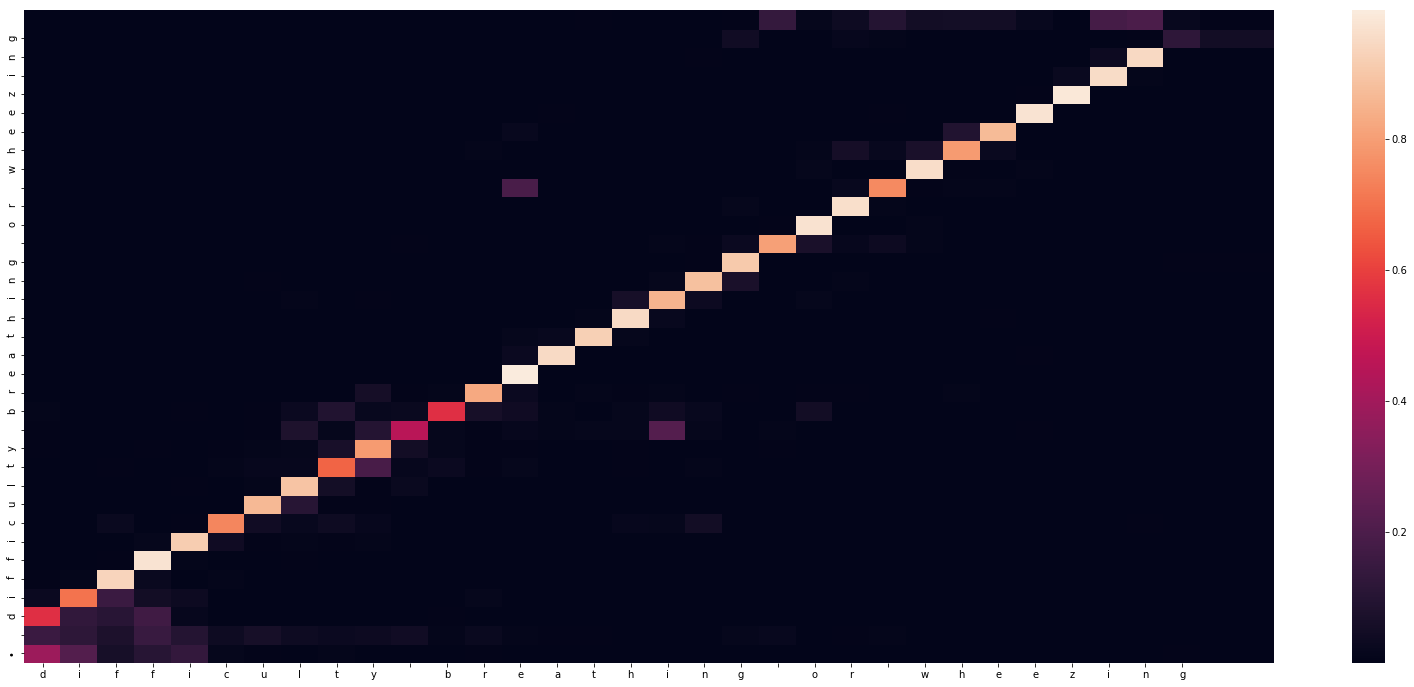

-
Input sentence: difficulty breathing or wheezing
GT sentence: • difficulty breathing or wheezing

Decoded sentence: • difficulty breathing or wheezing


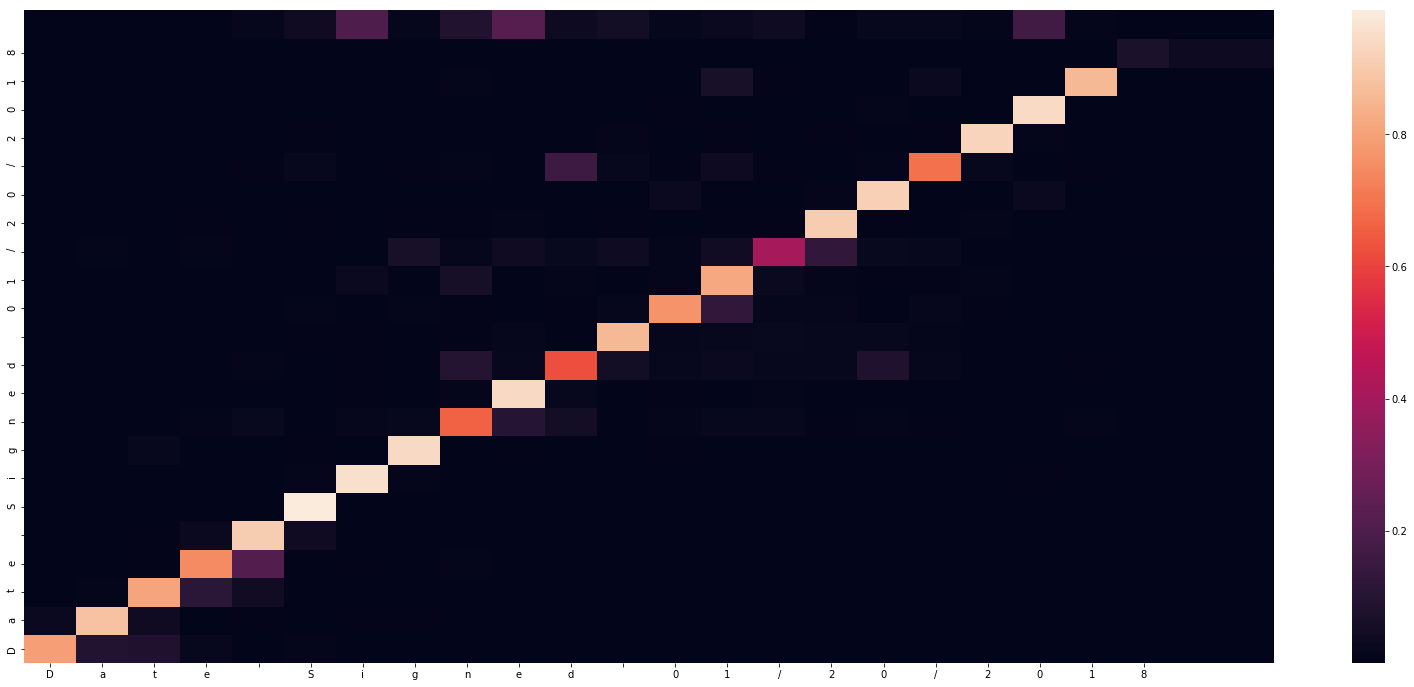

-
Input sentence: Date Signed 01/20/2018
GT sentence: Date Signed 01/20/2018

Decoded sentence: Date Signed 01/20/2018


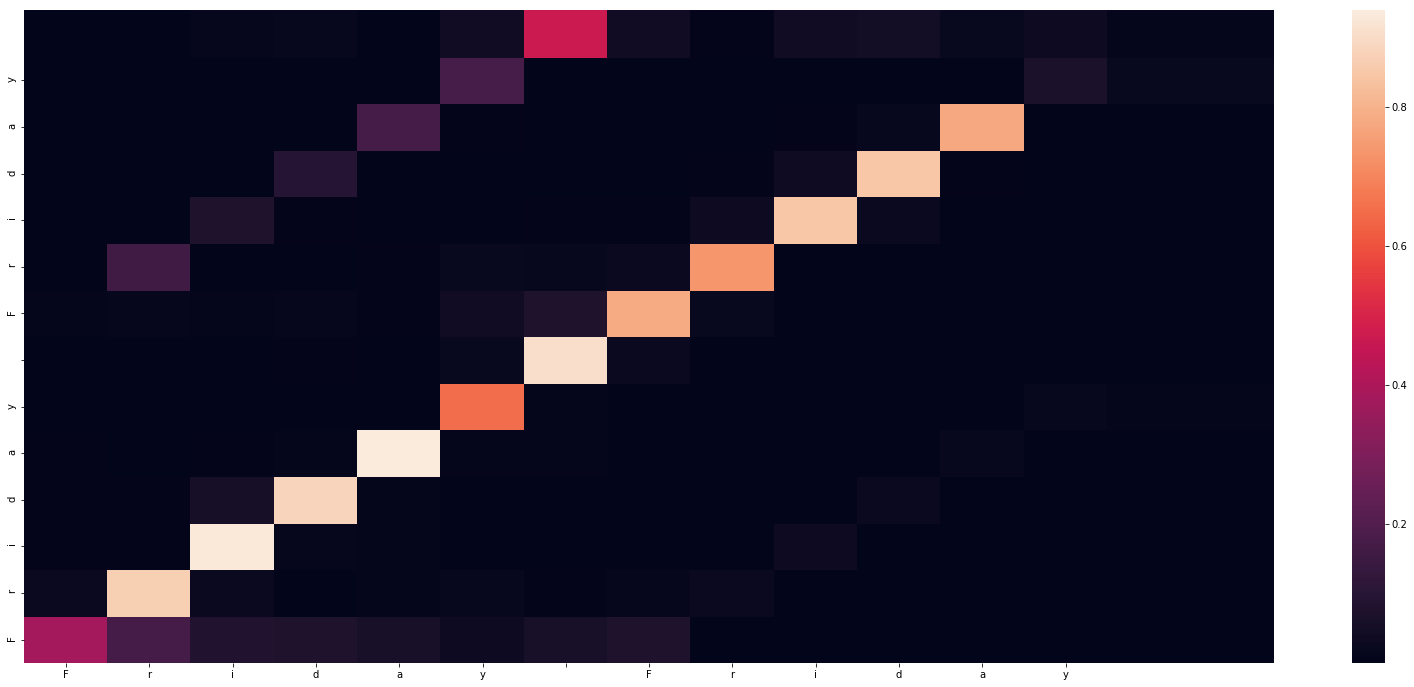

-
Input sentence: Friday Friday
GT sentence: Friday Friday

Decoded sentence: Friday Friday


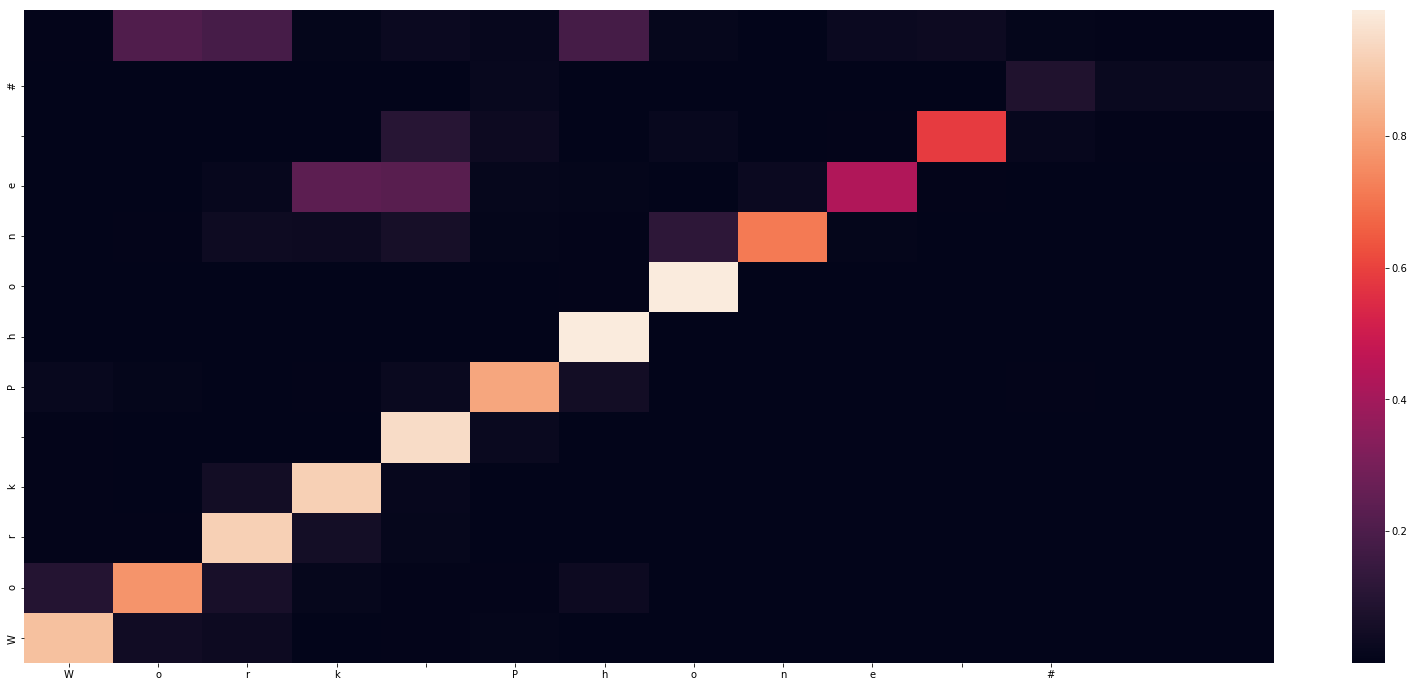

-
Input sentence: Work Phone #
GT sentence: Work Phone #

Decoded sentence: Work Phone #


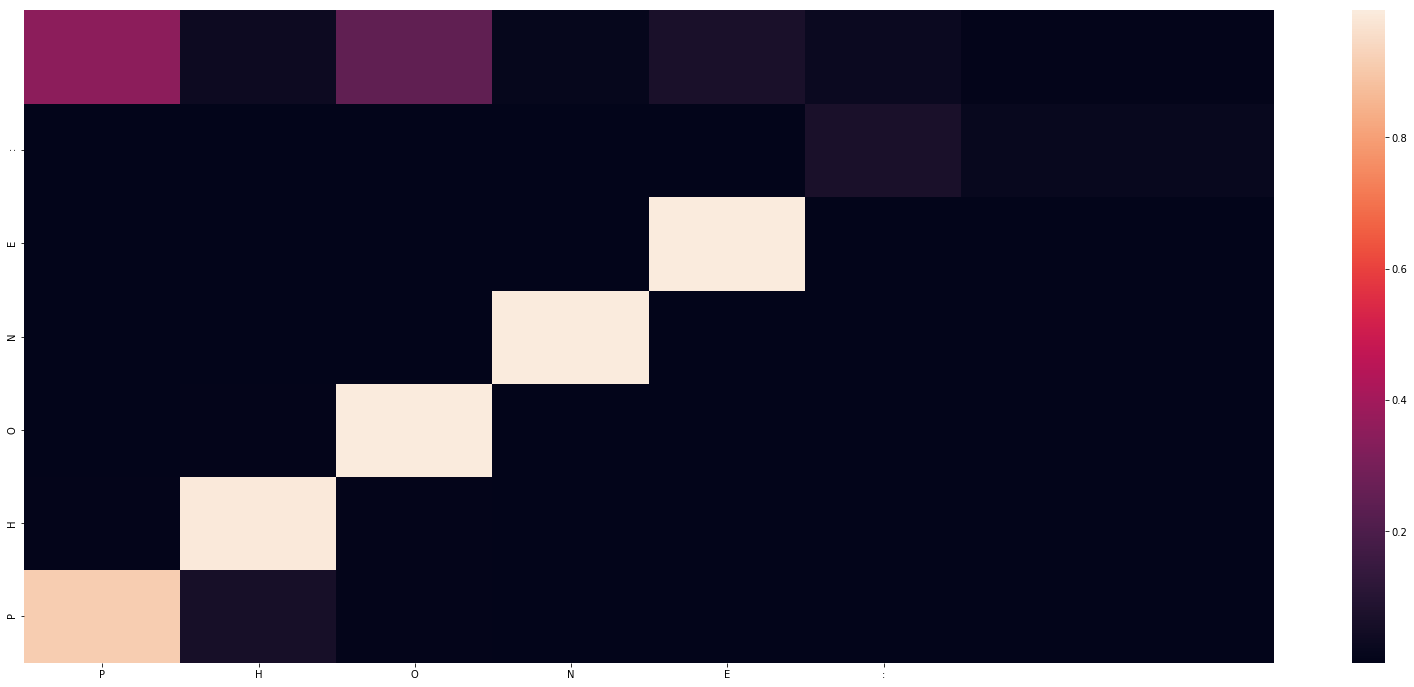

-
Input sentence: PHONE:
GT sentence: PHONE:

Decoded sentence: PHONE:


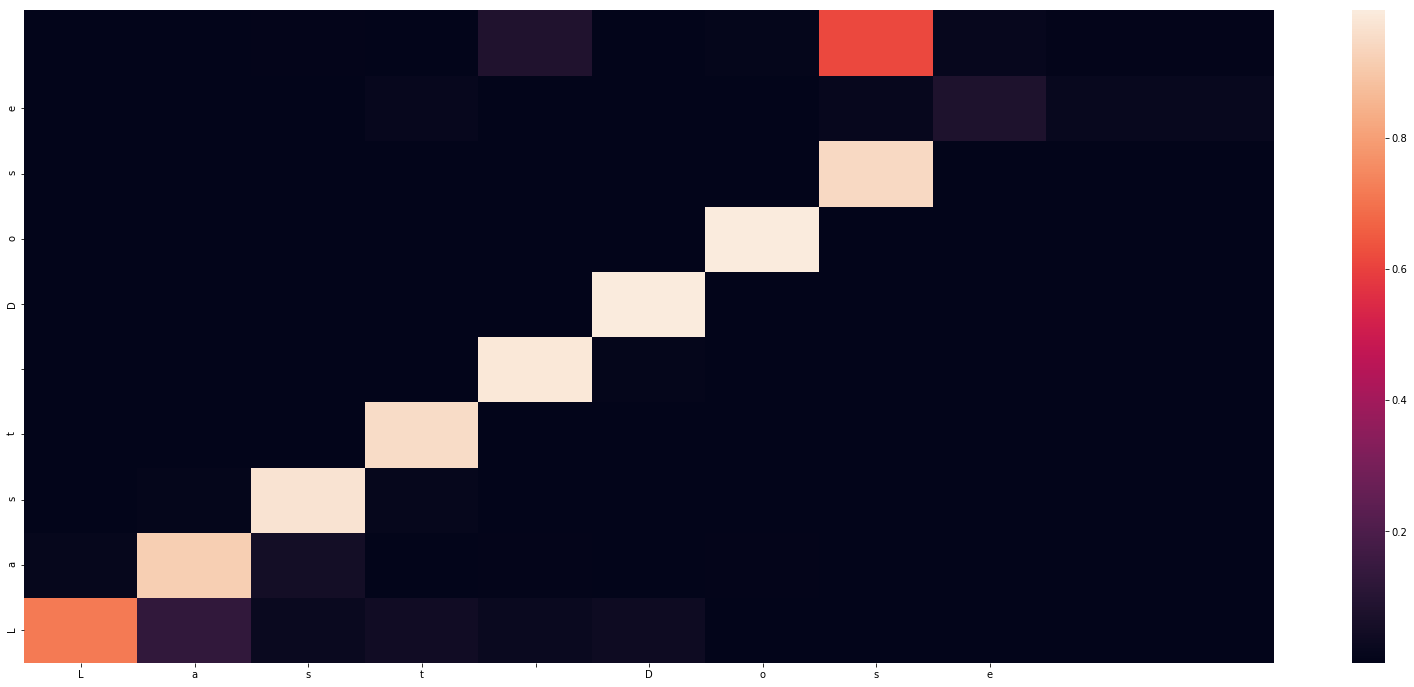

-
Input sentence: Last Dose
GT sentence: Last Dose

Decoded sentence: Last Dose


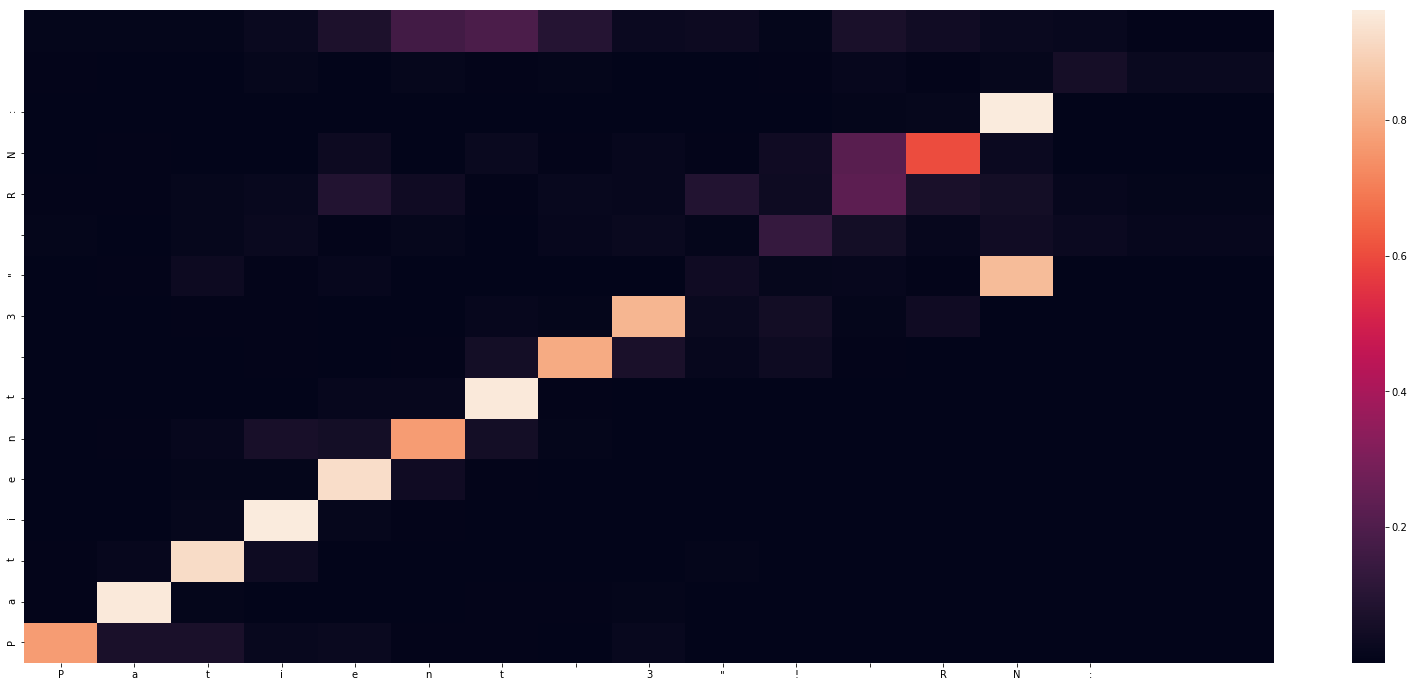

-
Input sentence: Patient 3"! RN:
GT sentence: Patient MRN: 

Decoded sentence: Patient 3" RN:


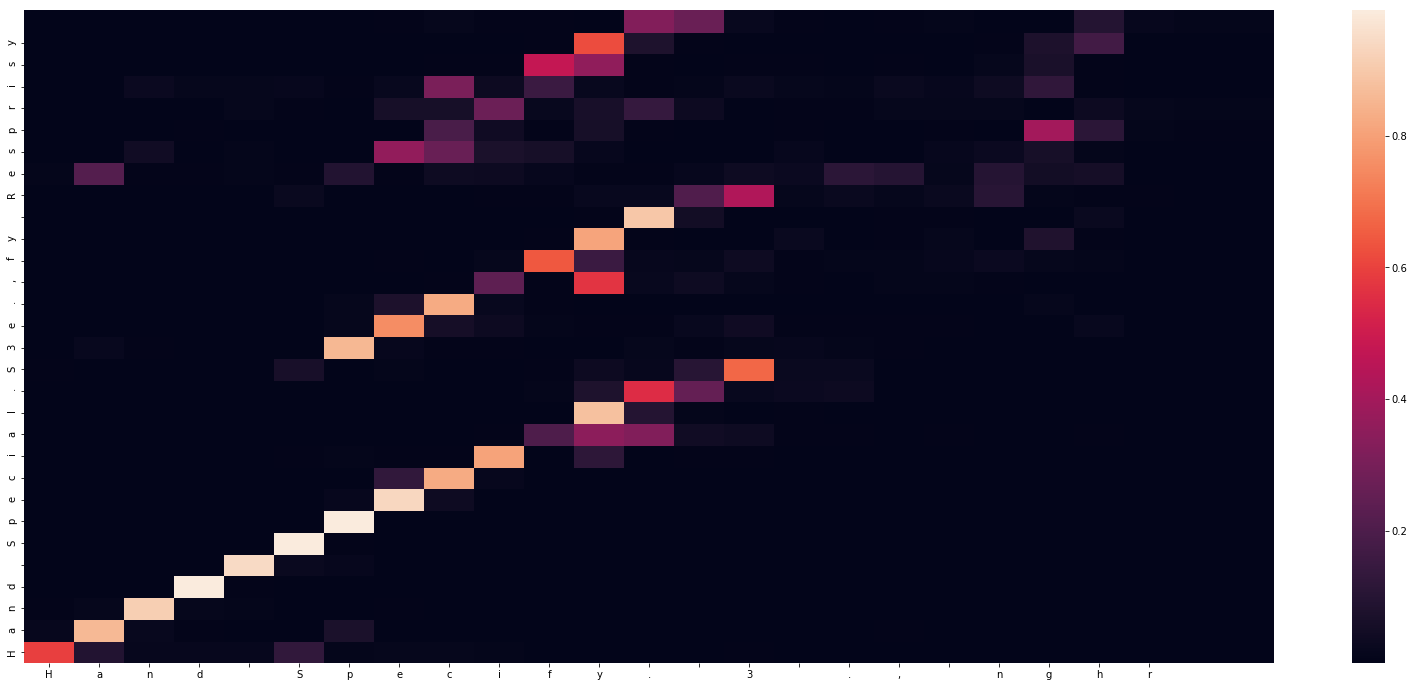

-
Input sentence: Hand Specify. 3 ., nghr
GT sentence: Hand Specify Right (R) Left (L) Bilateral (B)

Decoded sentence: Hand Special.S3e.,fy Resprisy


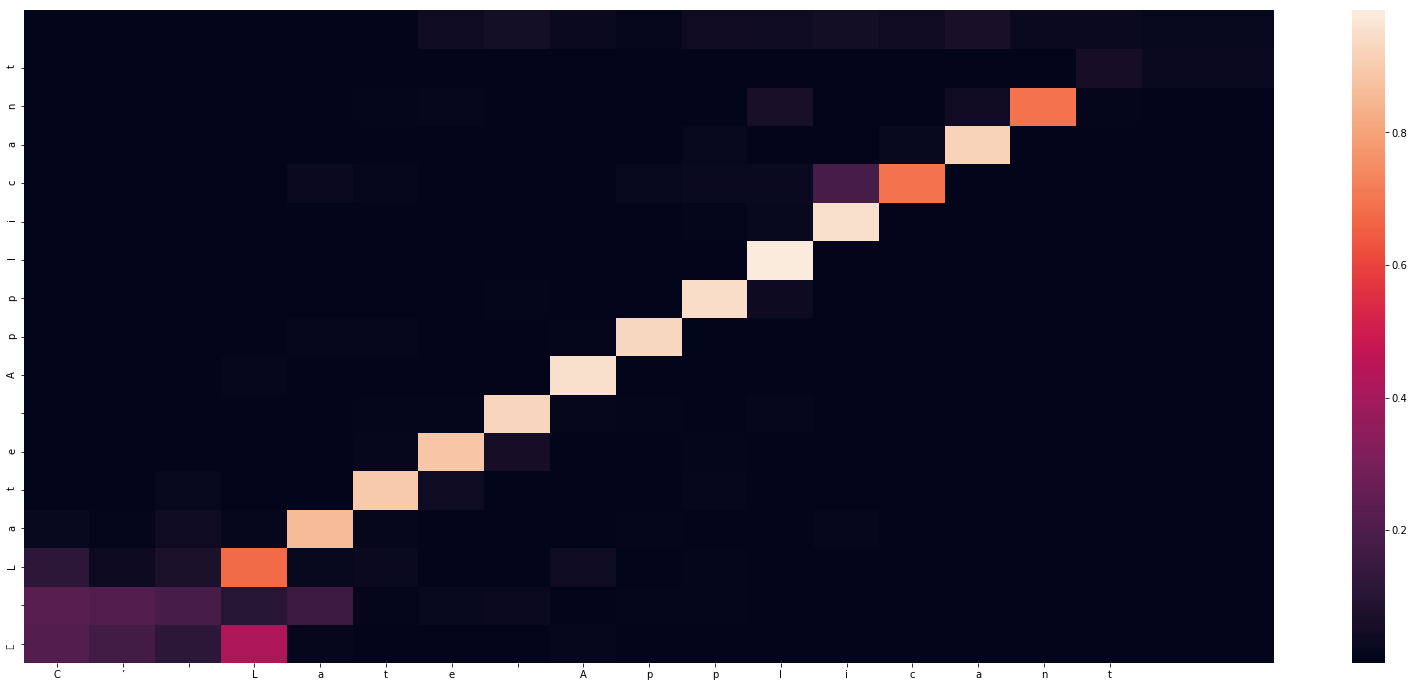

-
Input sentence: C’ Late Applicant
GT sentence: ☐ Late Applicant

Decoded sentence: ☐ Late Applicant


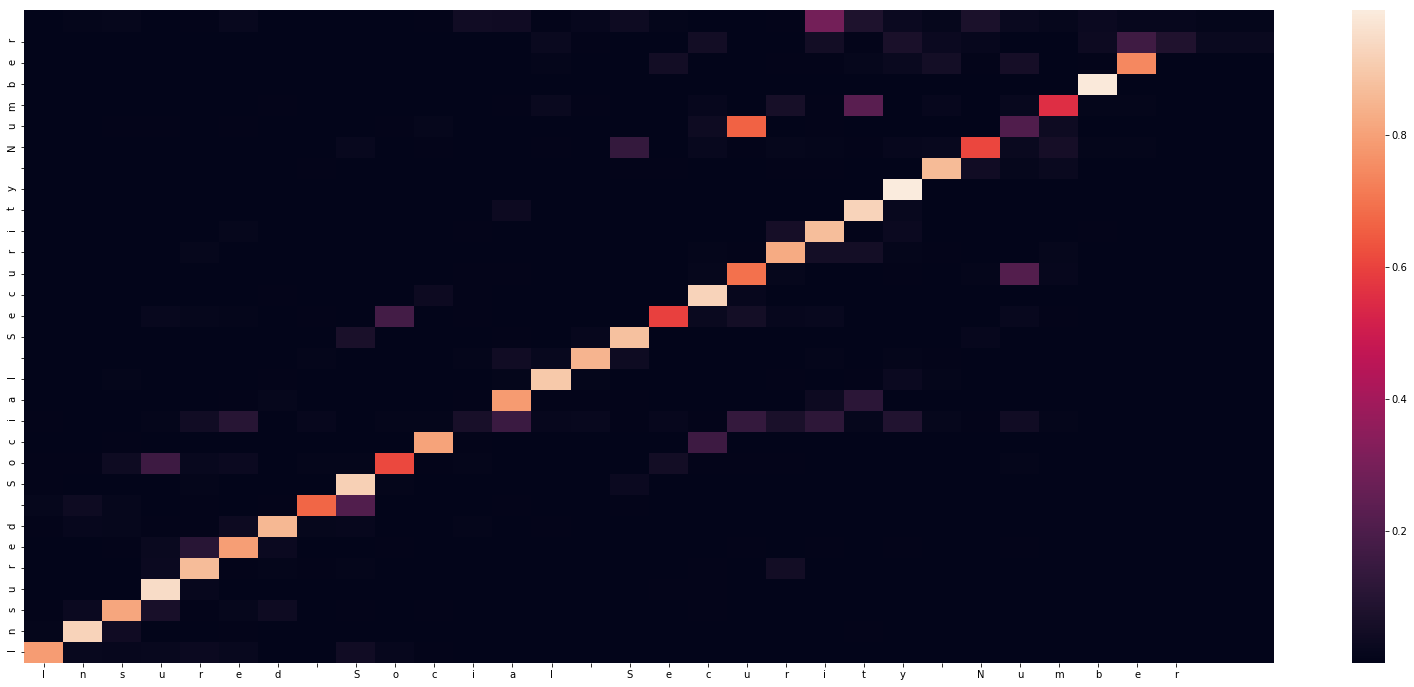

-
Input sentence: Insured Social Security Number
GT sentence: Insured Social Security Number

Decoded sentence: Insured Social Security Number


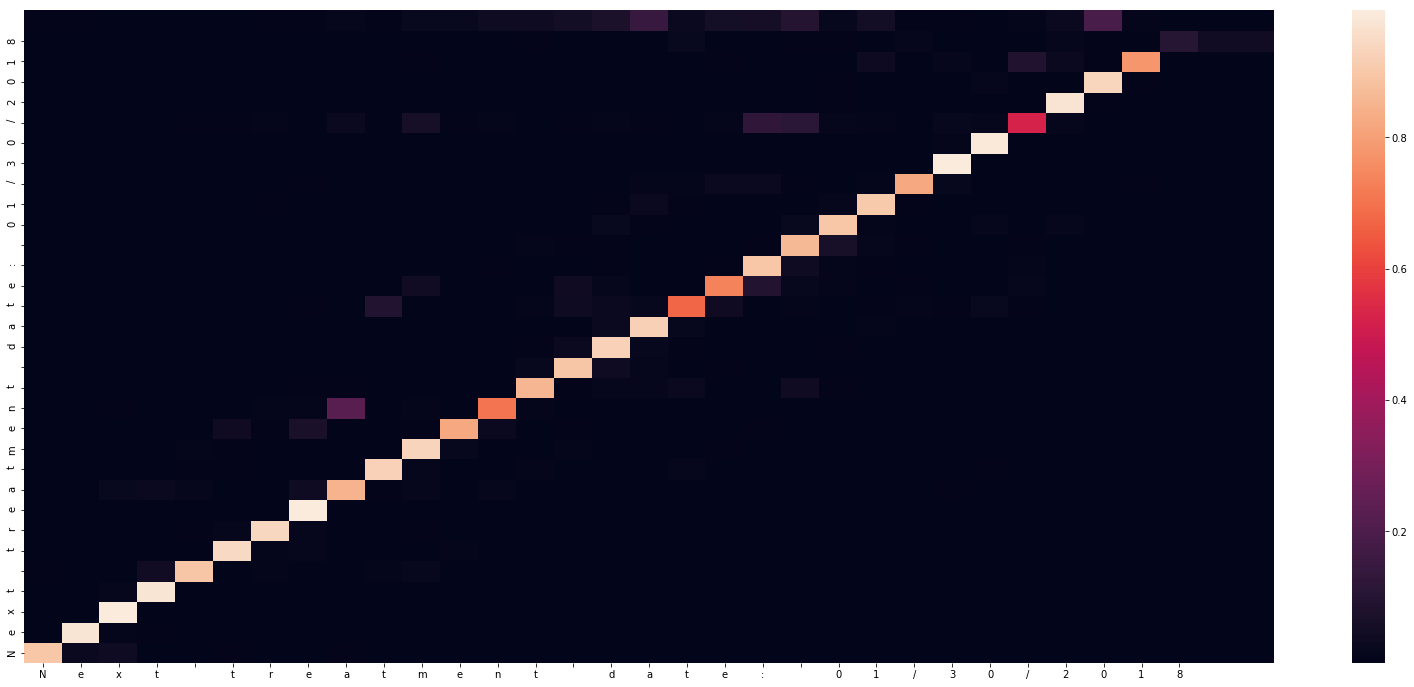

-
Input sentence: Next treatment date: 01/30/2018
GT sentence: Next treatment date: 01/30/2018

Decoded sentence: Next treatment date: 01/30/2018


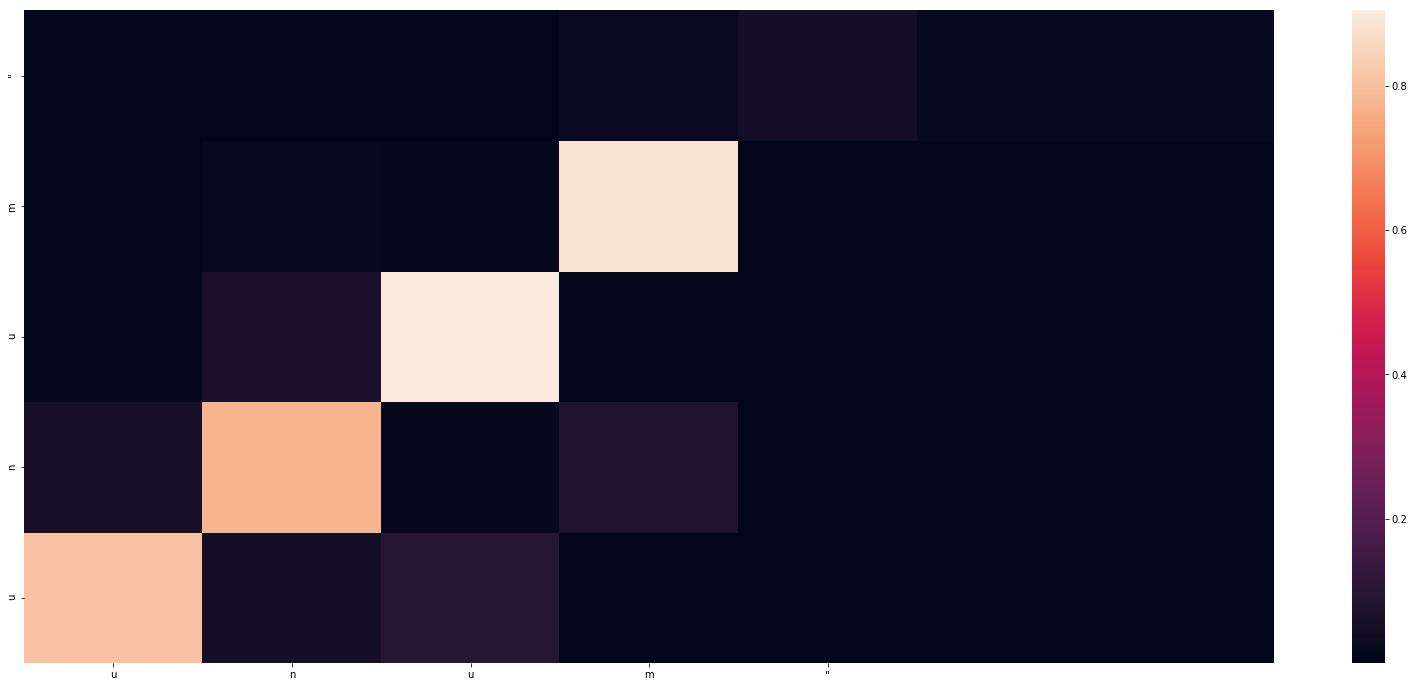

-
Input sentence: unum"
GT sentence: unum

Decoded sentence: unum"


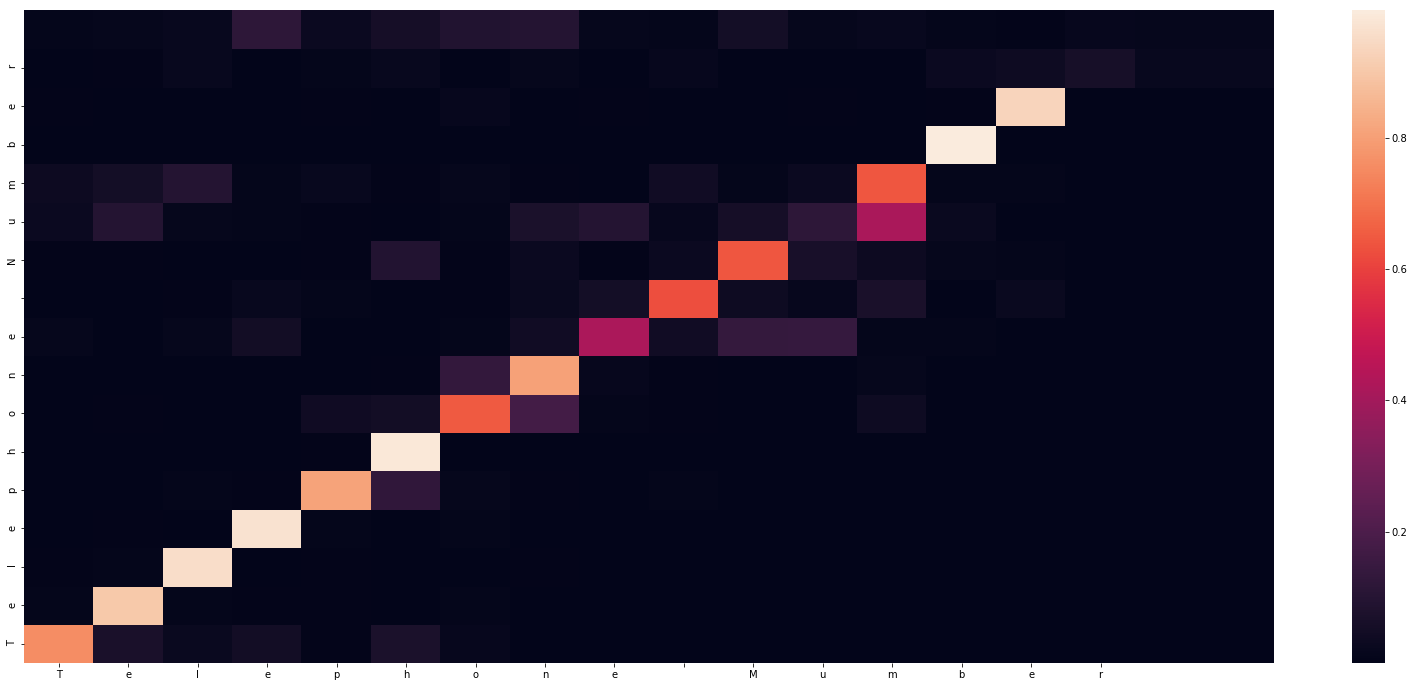

-
Input sentence: Telephone Mumber
GT sentence: Telephone Number

Decoded sentence: Telephone Number


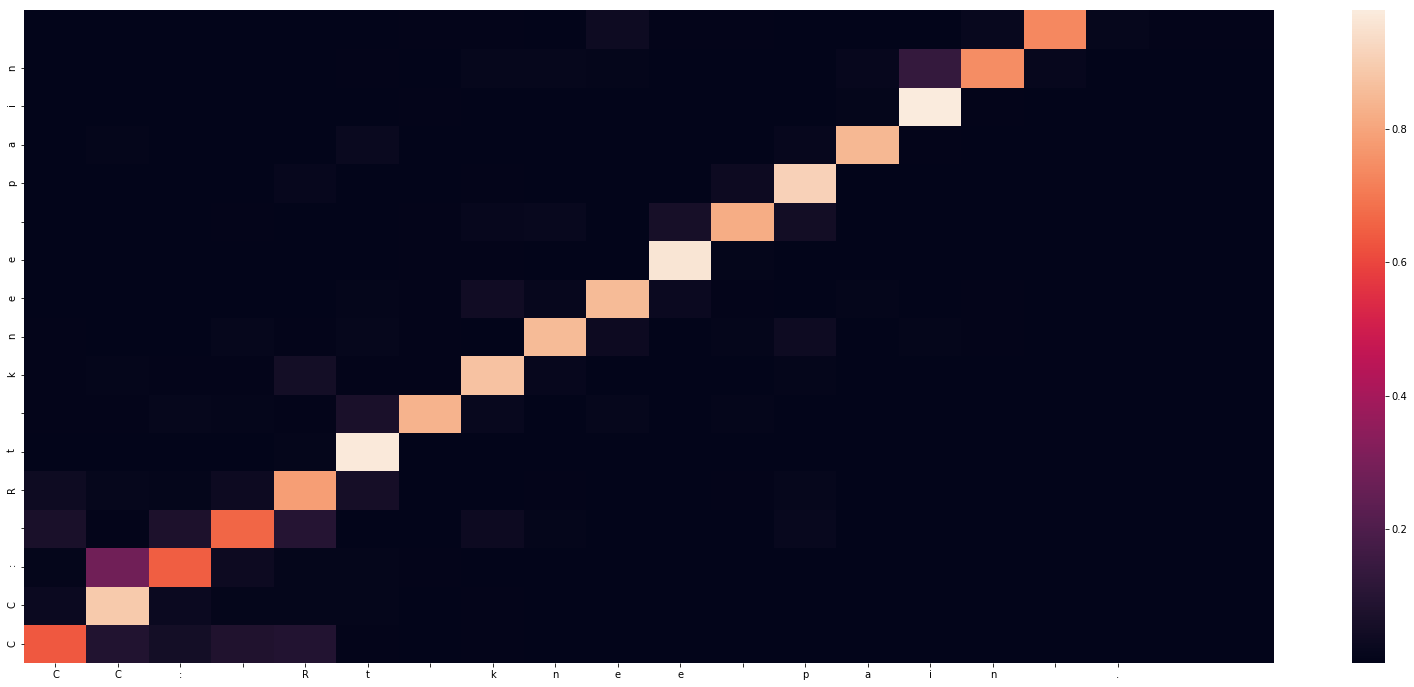

-
Input sentence: CC: Rt knee pain .
GT sentence: CC: Rt knee pain

Decoded sentence: CC: Rt knee pain


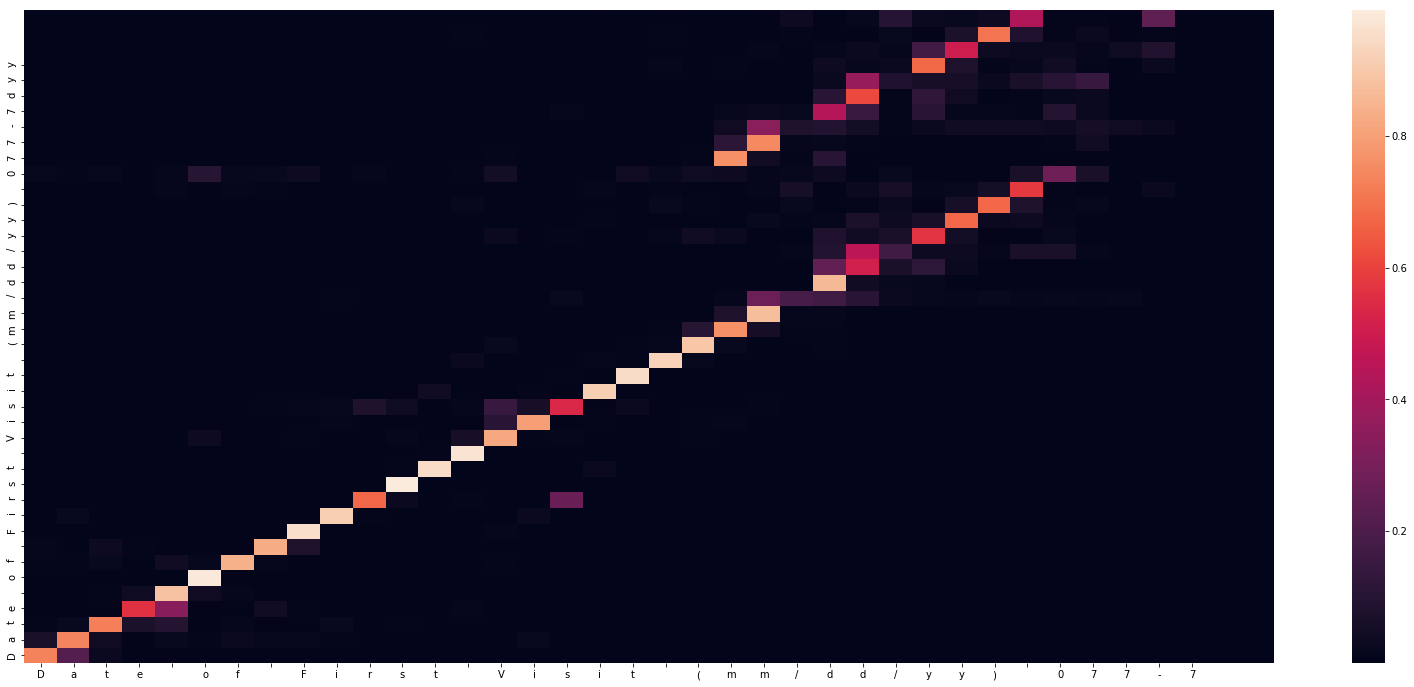

-
Input sentence: Date of First Visit (mm/dd/yy) 077-7
GT sentence: Date of First Visit (mm/dd/yy) 07-30-17

Decoded sentence: Date of First Visit (mm/dd/yy) 077-7dyy


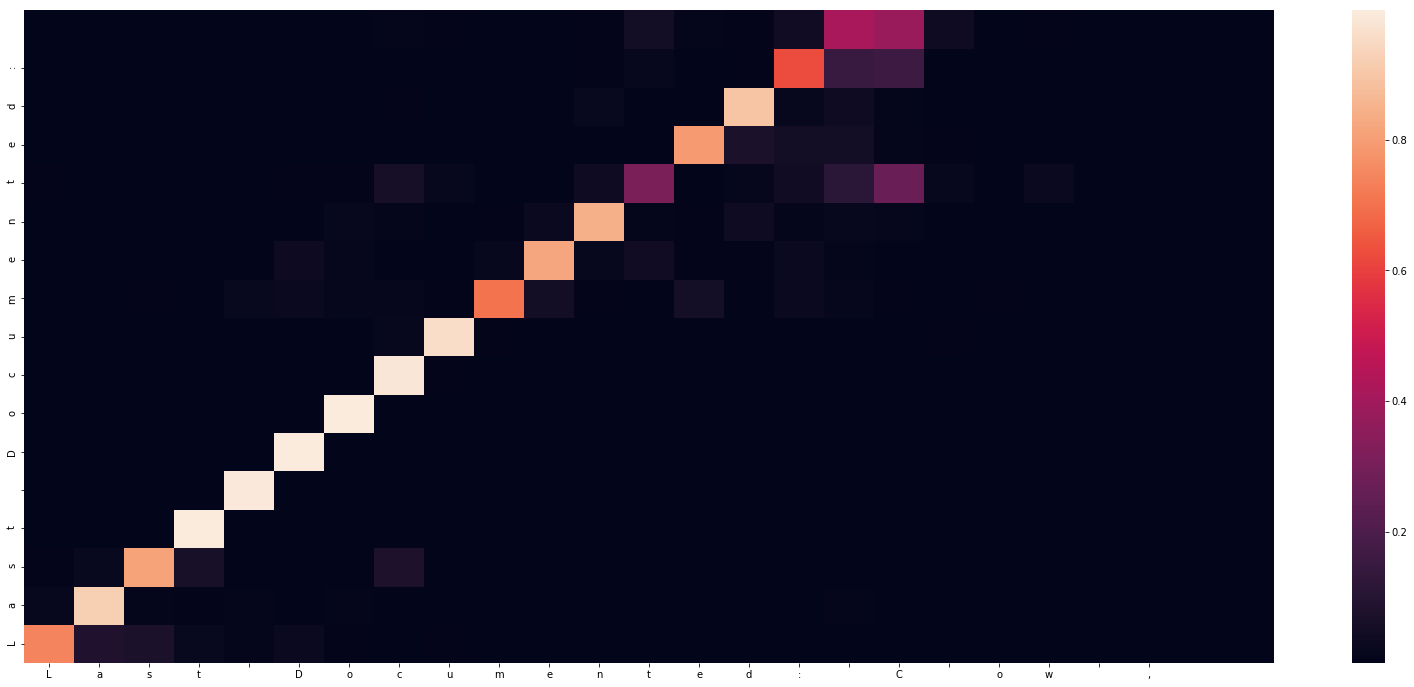

-
Input sentence: Last Documented: C ow ,
GT sentence: Last Documented:

Decoded sentence: Last Documented:


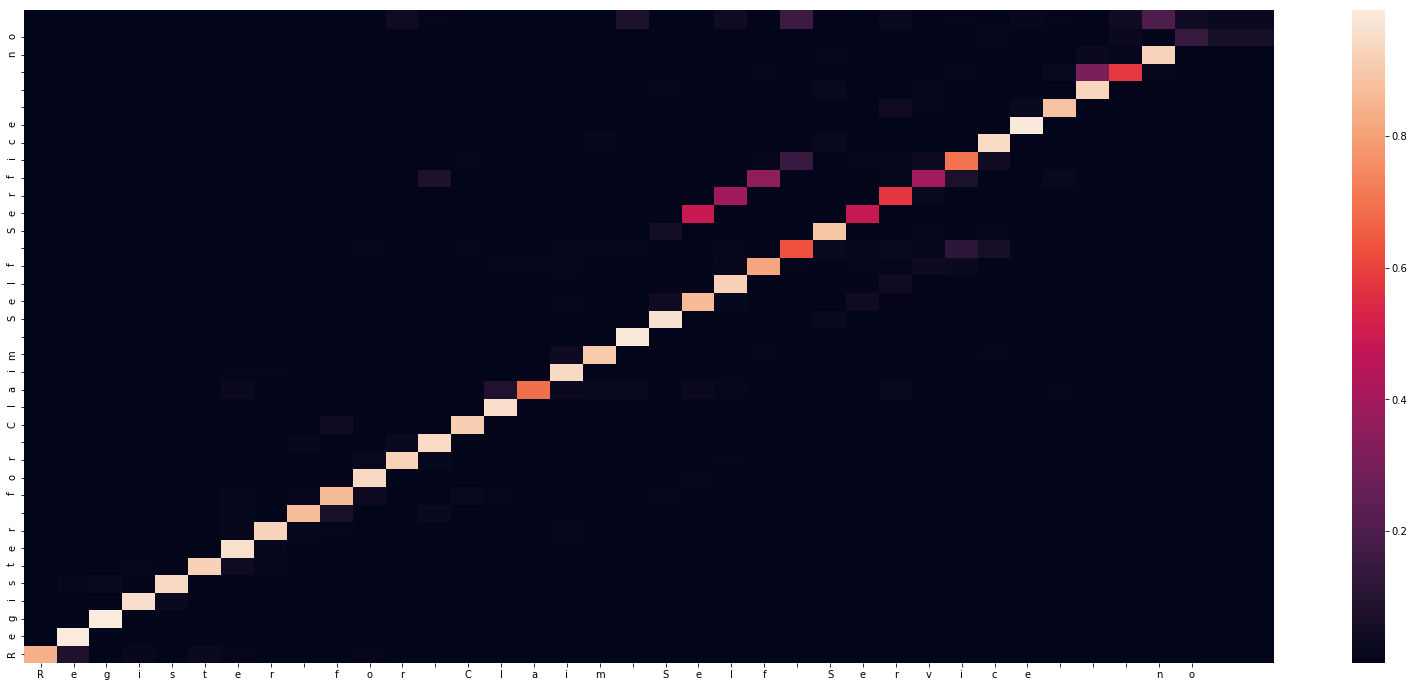

-
Input sentence: Register for Claim Self Service — no
GT sentence: Register for Claim Self Service - no

Decoded sentence: Register for Claim Self Serfice — no


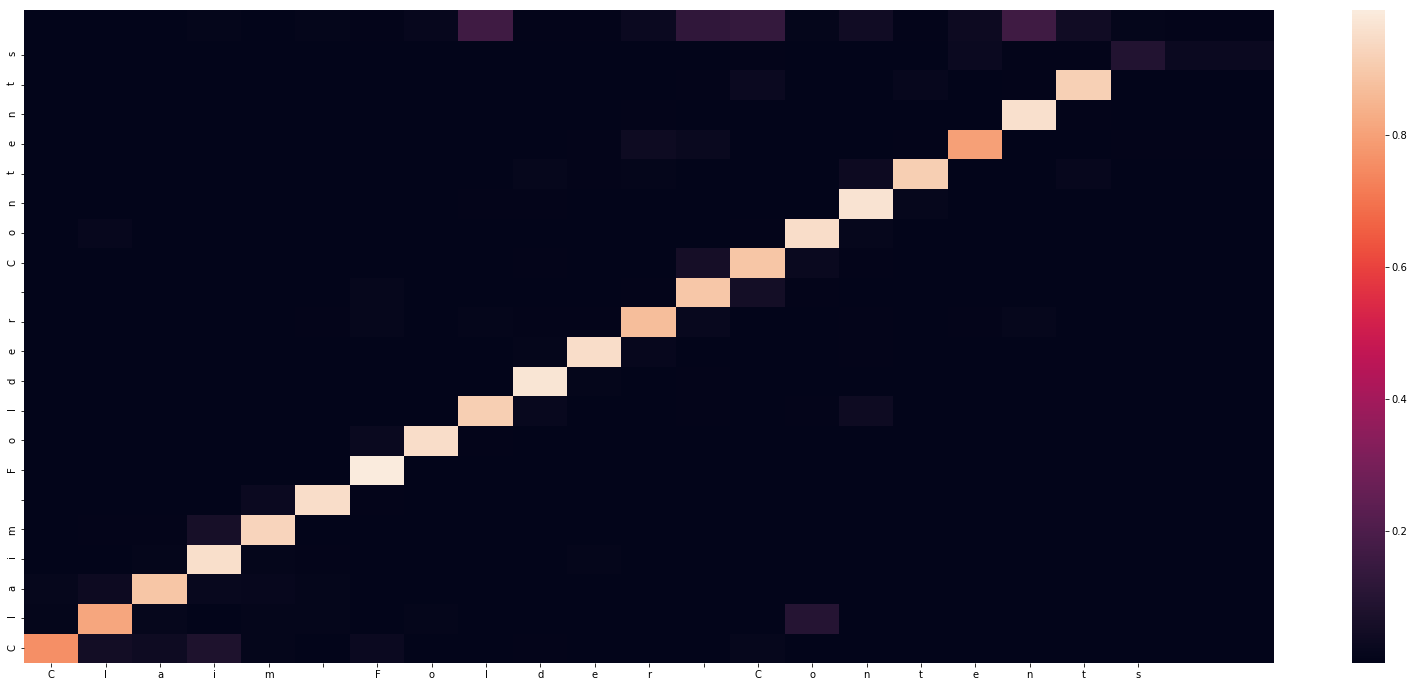

-
Input sentence: Claim Folder Contents
GT sentence: Claim Folder Contents

Decoded sentence: Claim Folder Contents


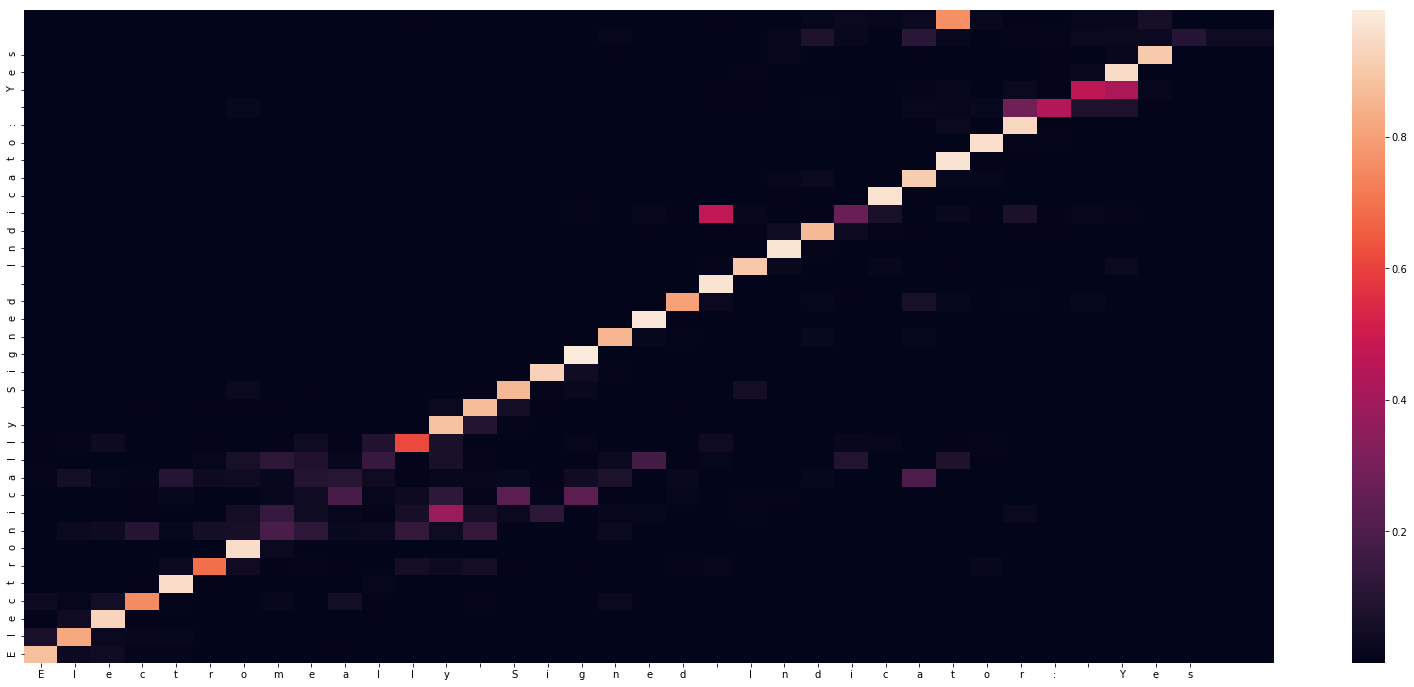

-
Input sentence: Electromeally Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicato: Yes


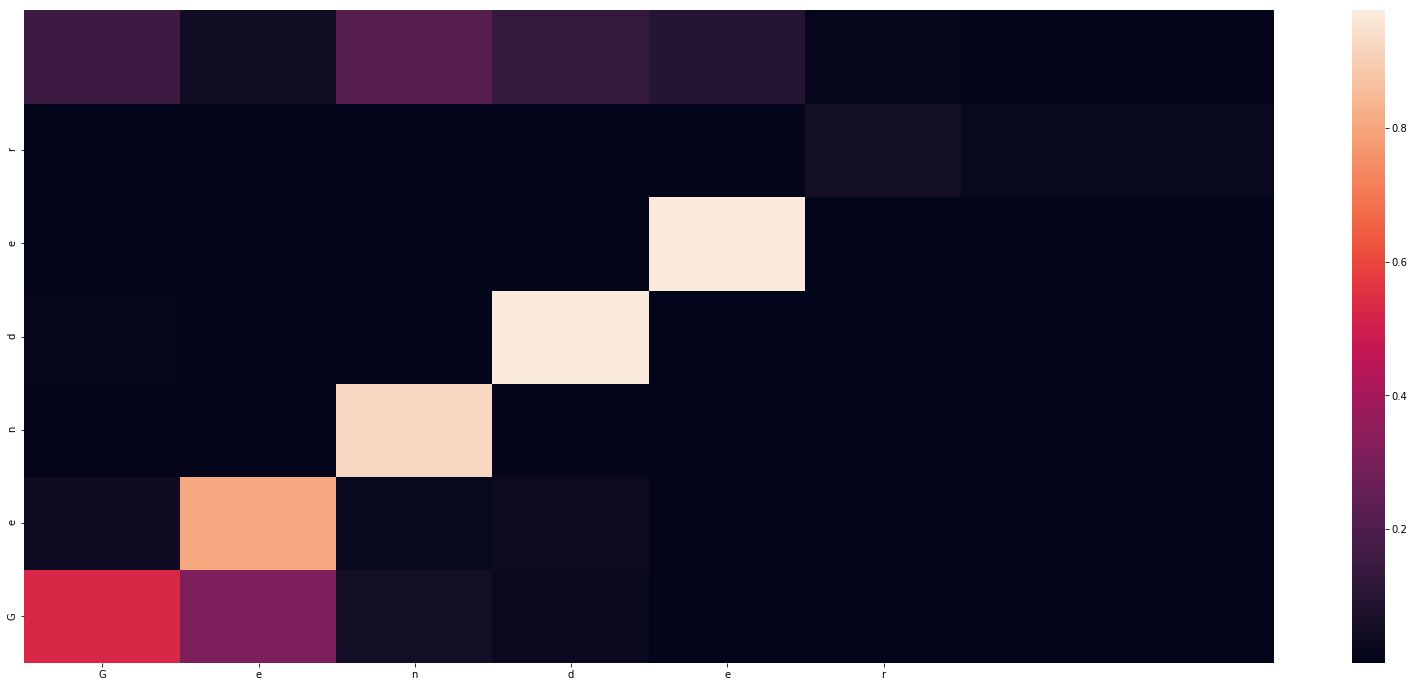

-
Input sentence: Gender
GT sentence: Gender

Decoded sentence: Gender


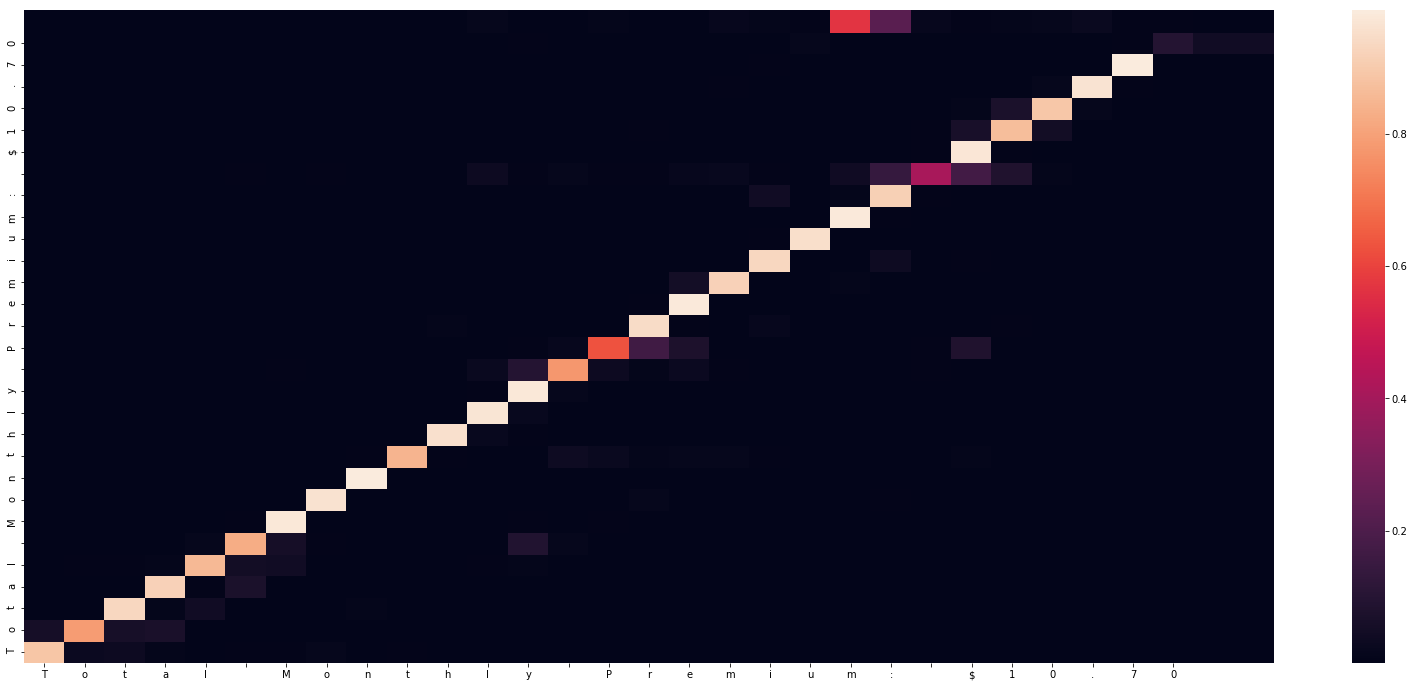

-
Input sentence: Total Monthly Premium: $10.70
GT sentence: Total Monthly Premium: $10.70

Decoded sentence: Total Monthly Premium: $10.70


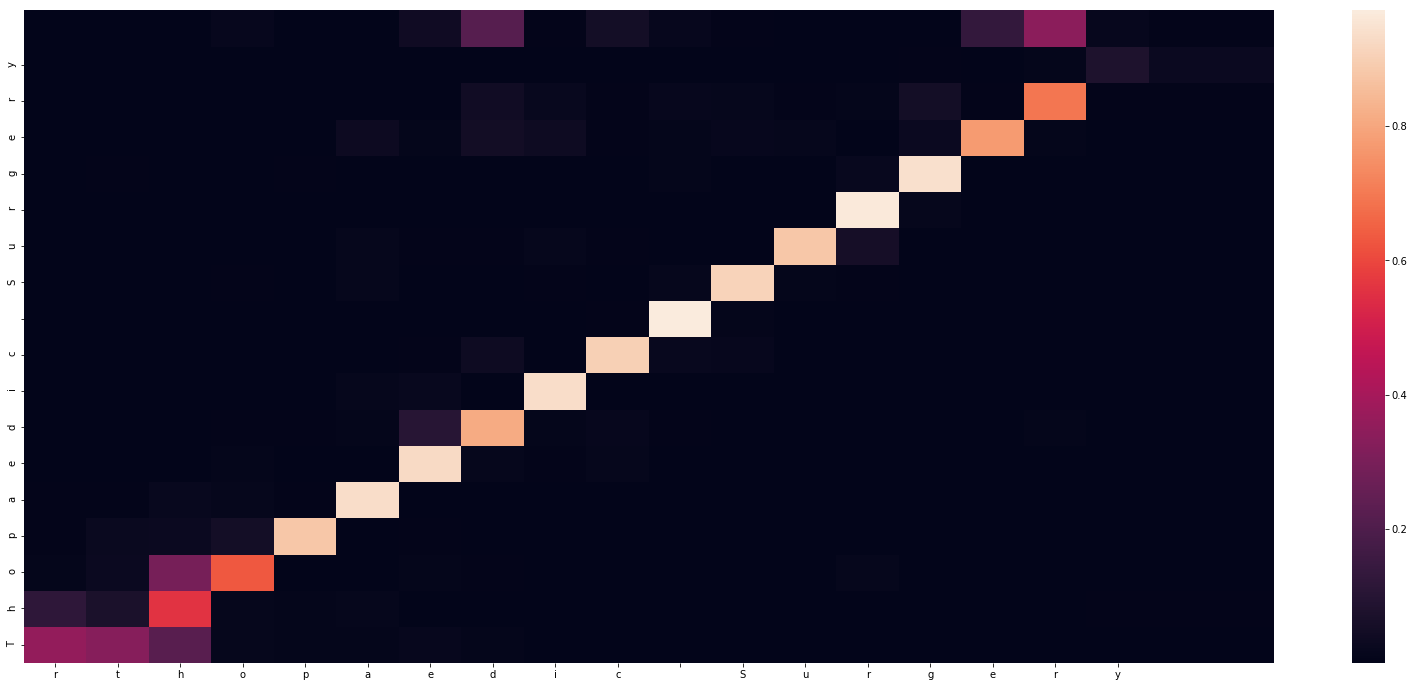

-
Input sentence: rthopaedic Surgery
GT sentence: Orthopaedic Surgery

Decoded sentence: Thopaedic Surgery


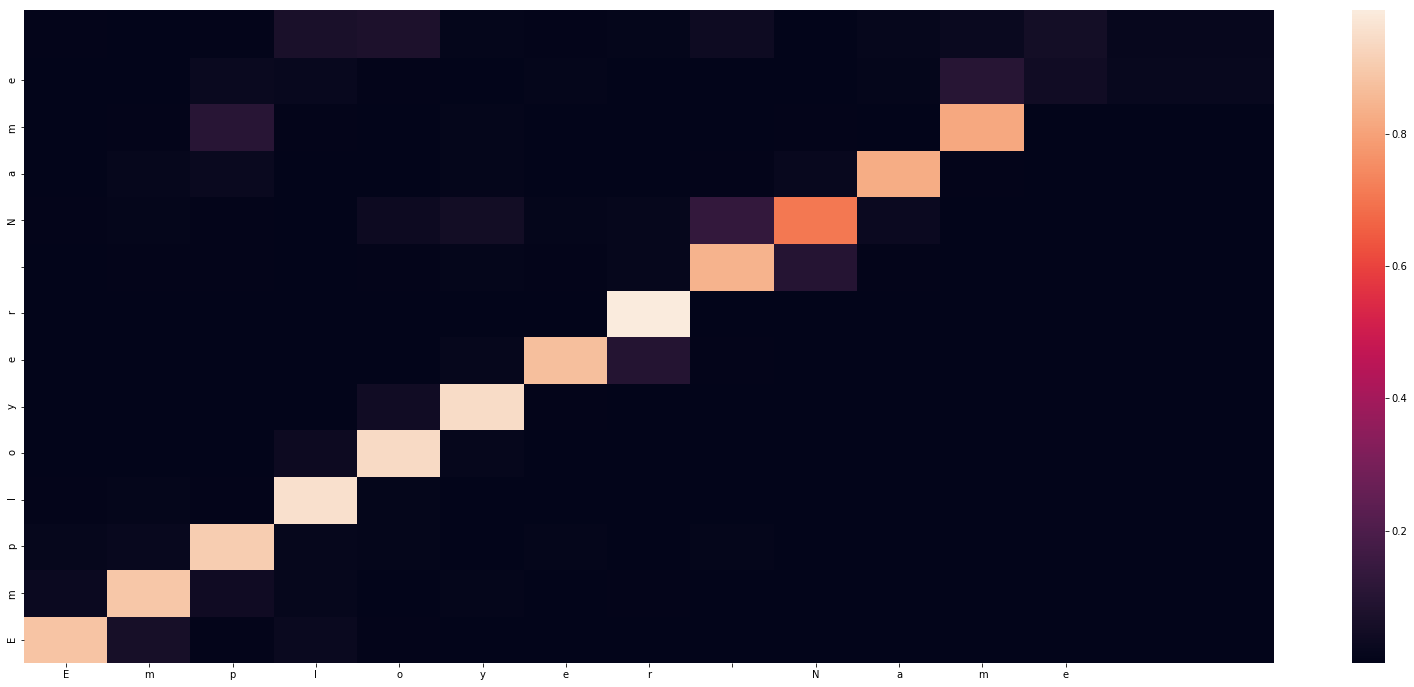

-
Input sentence: Employer Name
GT sentence: Employer Name

Decoded sentence: Employer Name


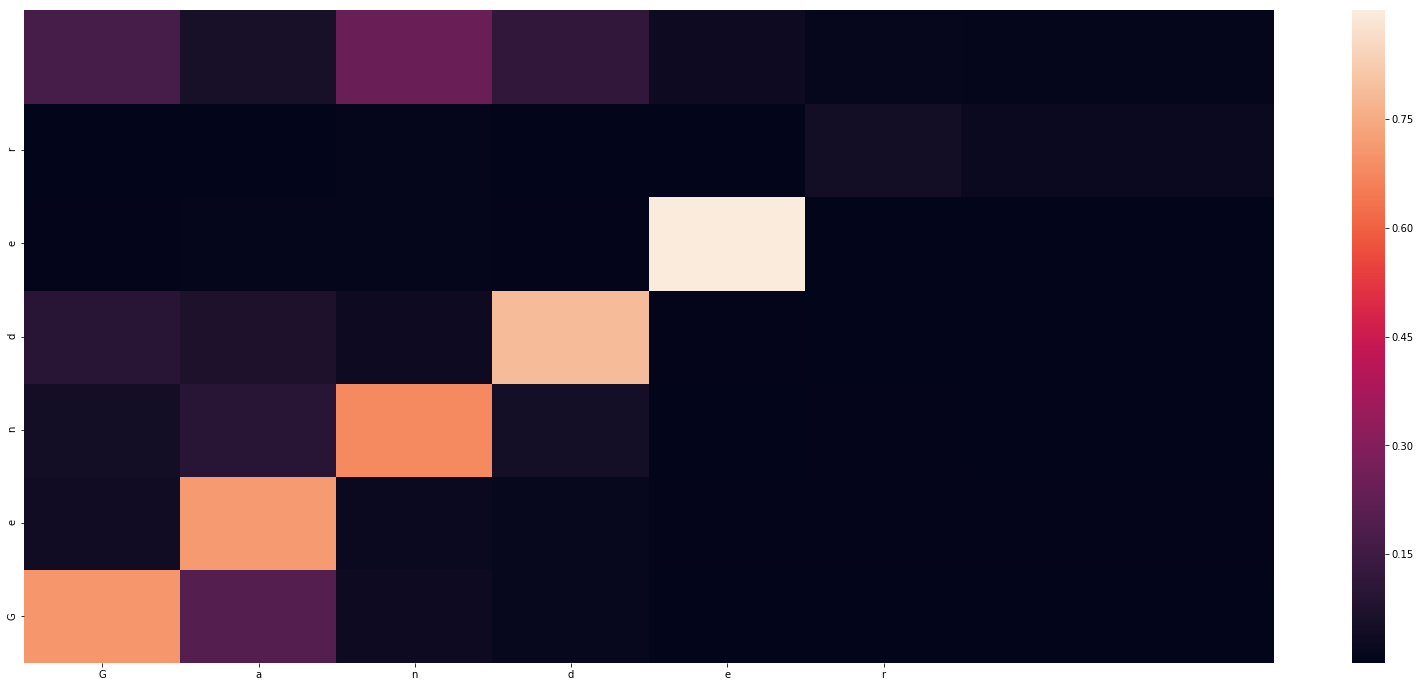

-
Input sentence: Gander
GT sentence: Gender

Decoded sentence: Gender


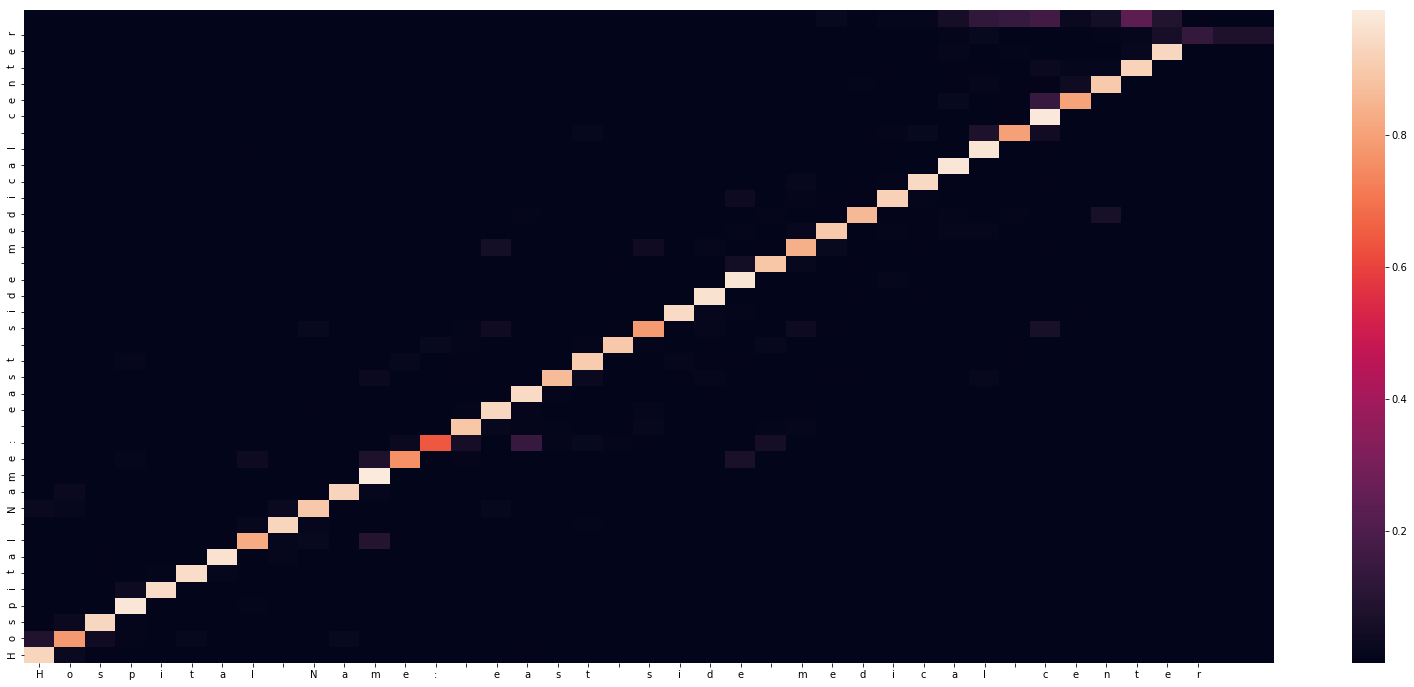

-
Input sentence: Hospital Name: east side medical center
GT sentence: Hospital Name: east side medical center

Decoded sentence: Hospital Name: east side medical center


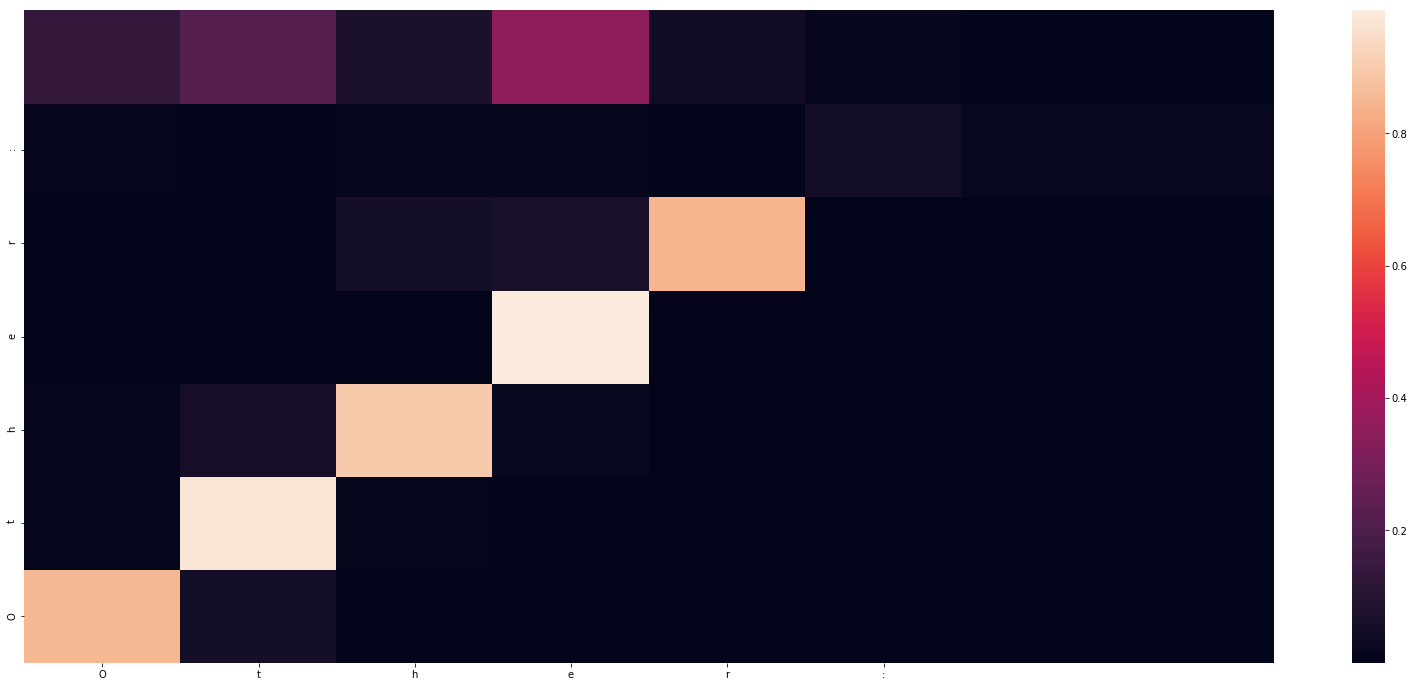

-
Input sentence: Other:
GT sentence: [ ] Other:

Decoded sentence: Other:


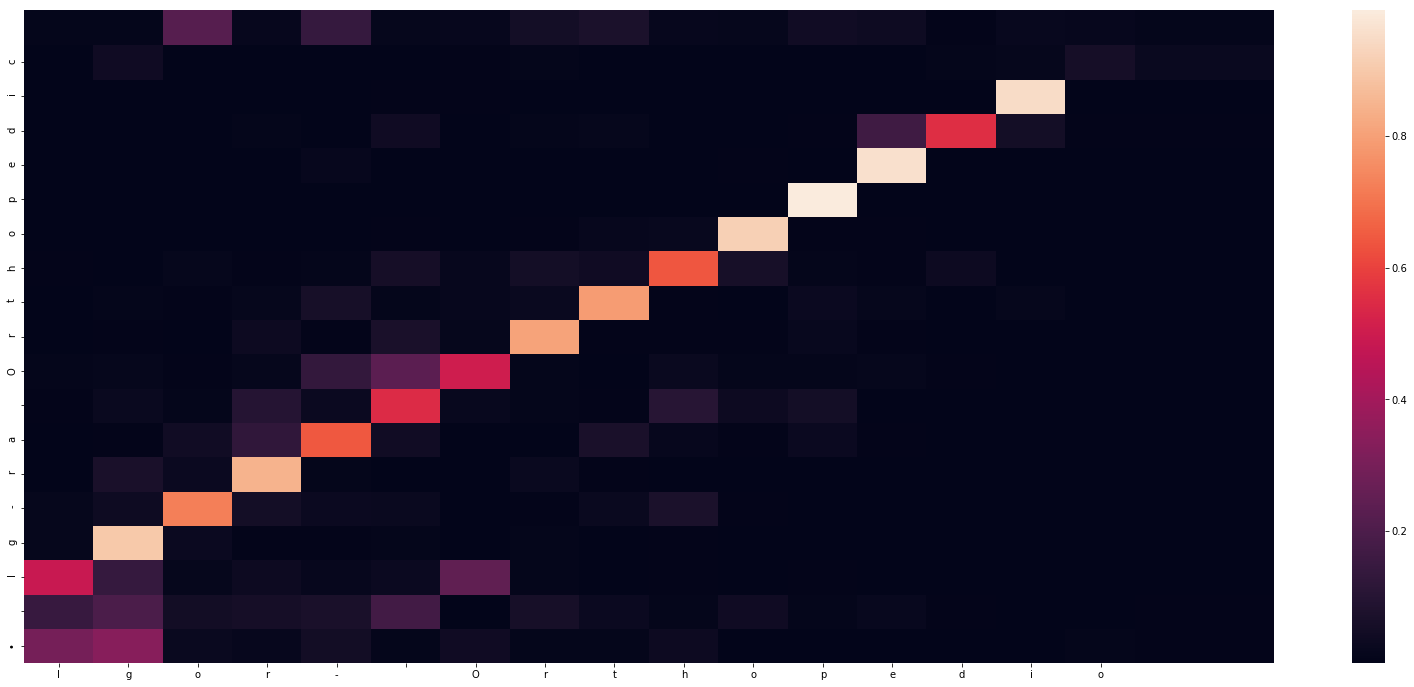

-
Input sentence: Igor- Orthopedio
GT sentence: Service: Orthopedic

Decoded sentence: • Ig-ra Orthopedic


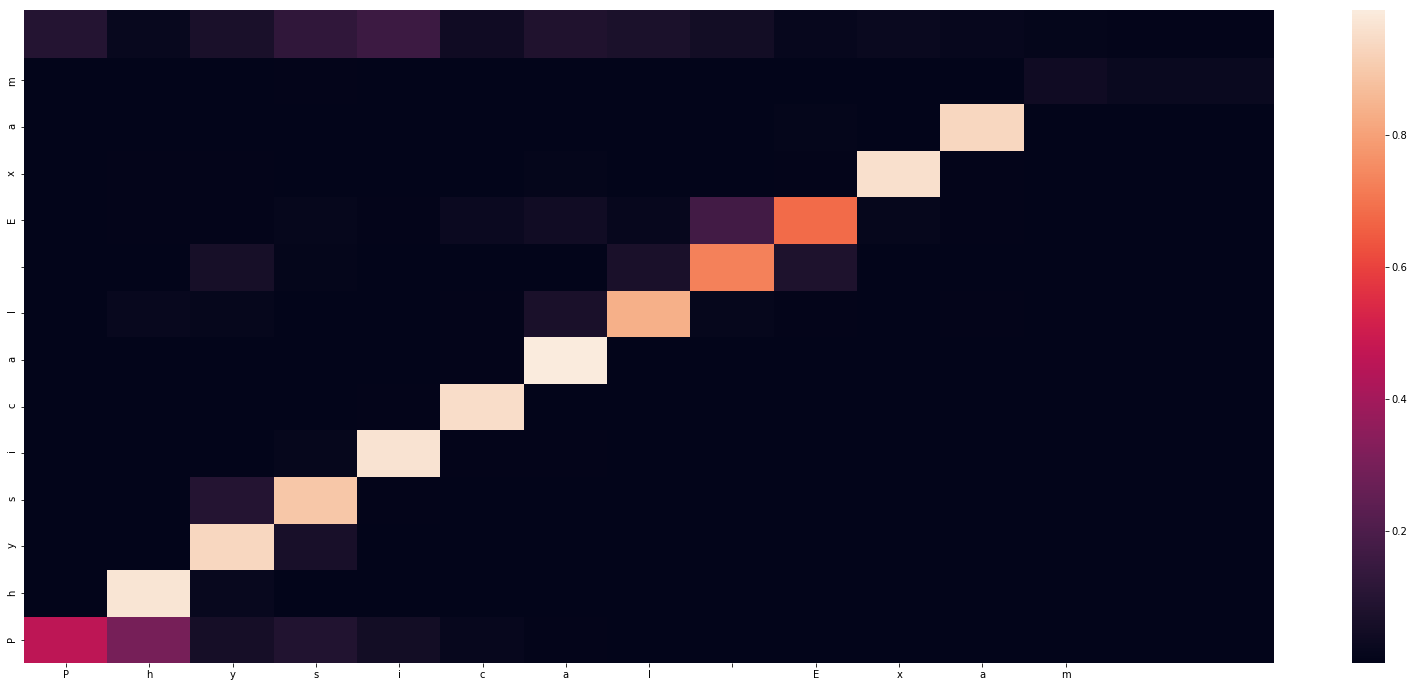

-
Input sentence: Physical Exam
GT sentence: Physical Exam

Decoded sentence: Physical Exam


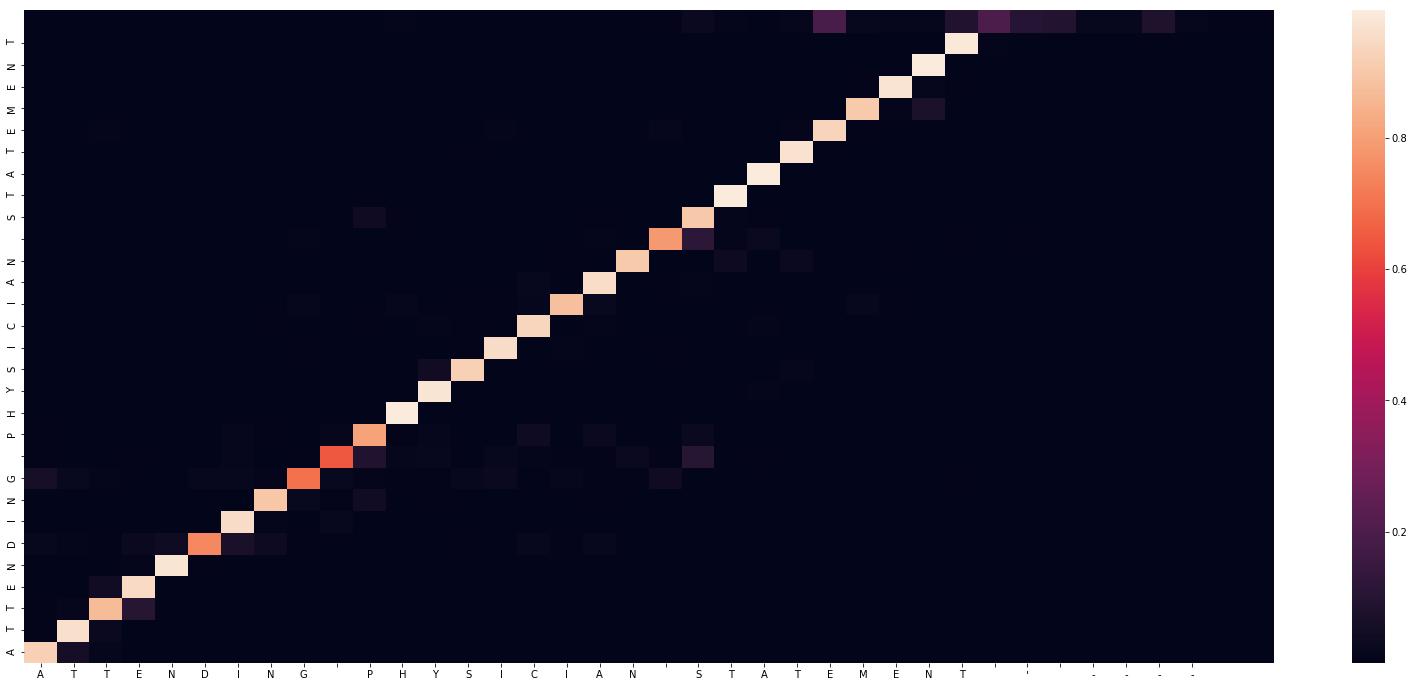

-
Input sentence: ATTENDING PHYSICIAN STATEMENT ' ----
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING PHYSICIAN STATEMENT


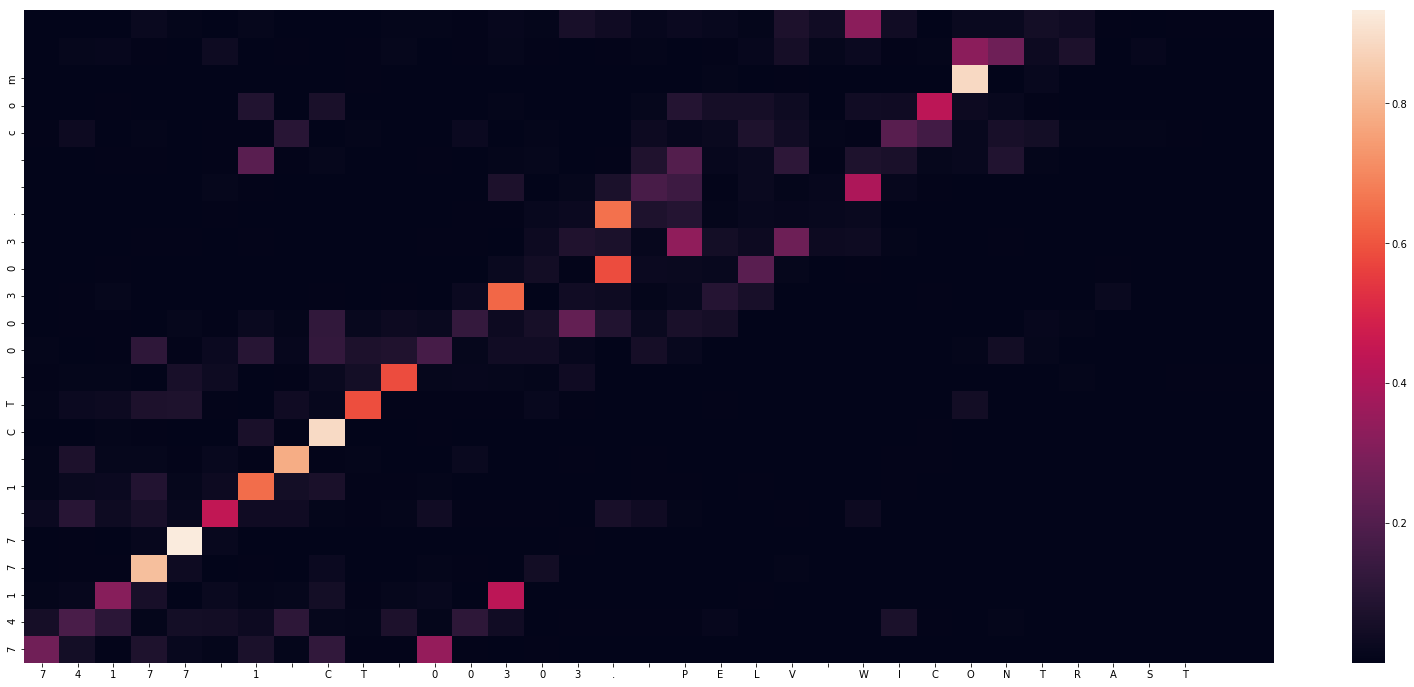

-
Input sentence: 74177 1 CT 00303. PELV WICONTRAST
GT sentence: 01-02-18 74177 1 CT ABD & PELV W/CONTRAST

Decoded sentence: 74177 1 CT 00303.  com


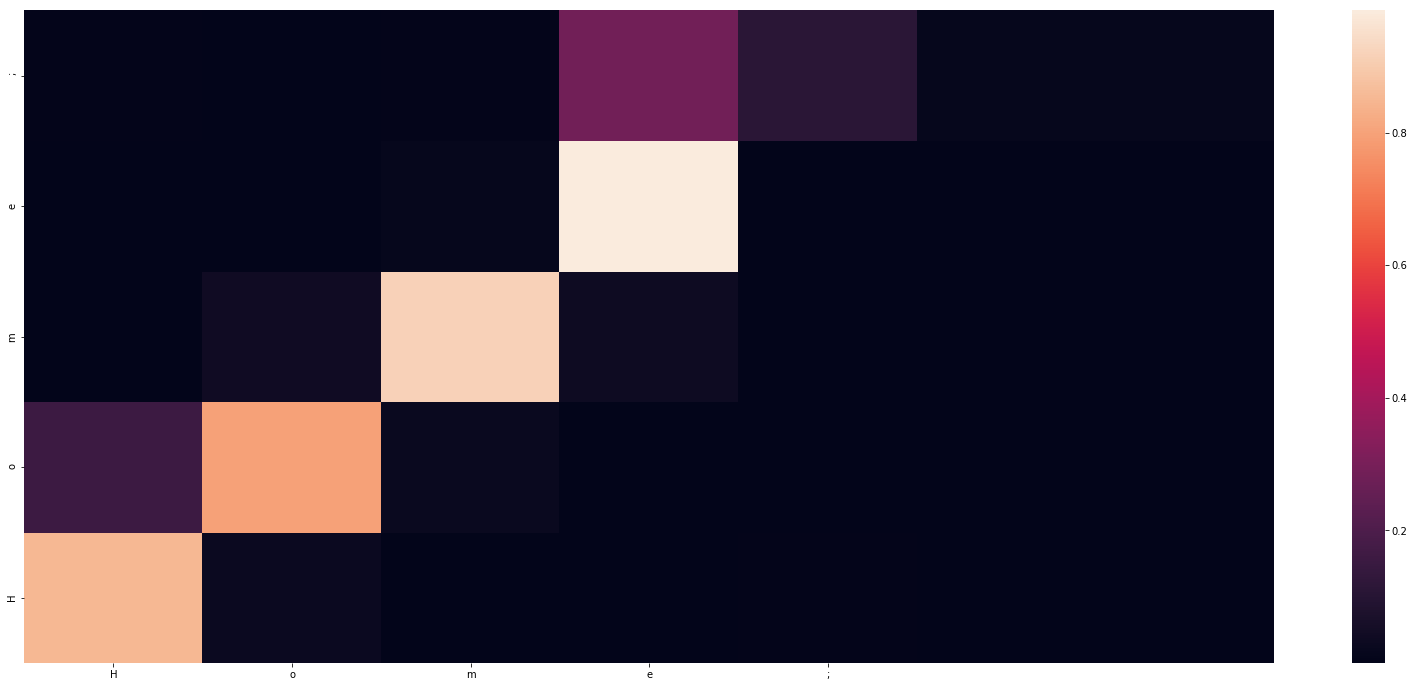

-
Input sentence: Home;
GT sentence: Home:

Decoded sentence: Home;


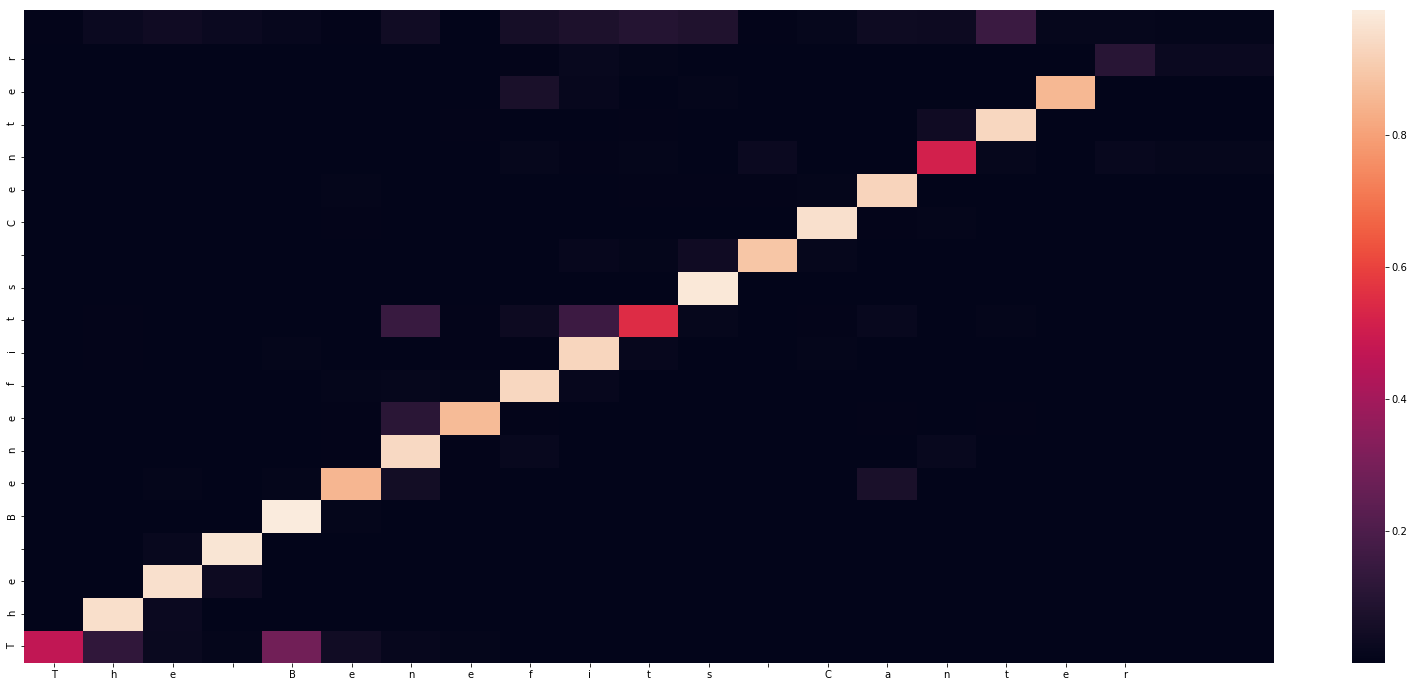

-
Input sentence: The Benefits Canter
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center


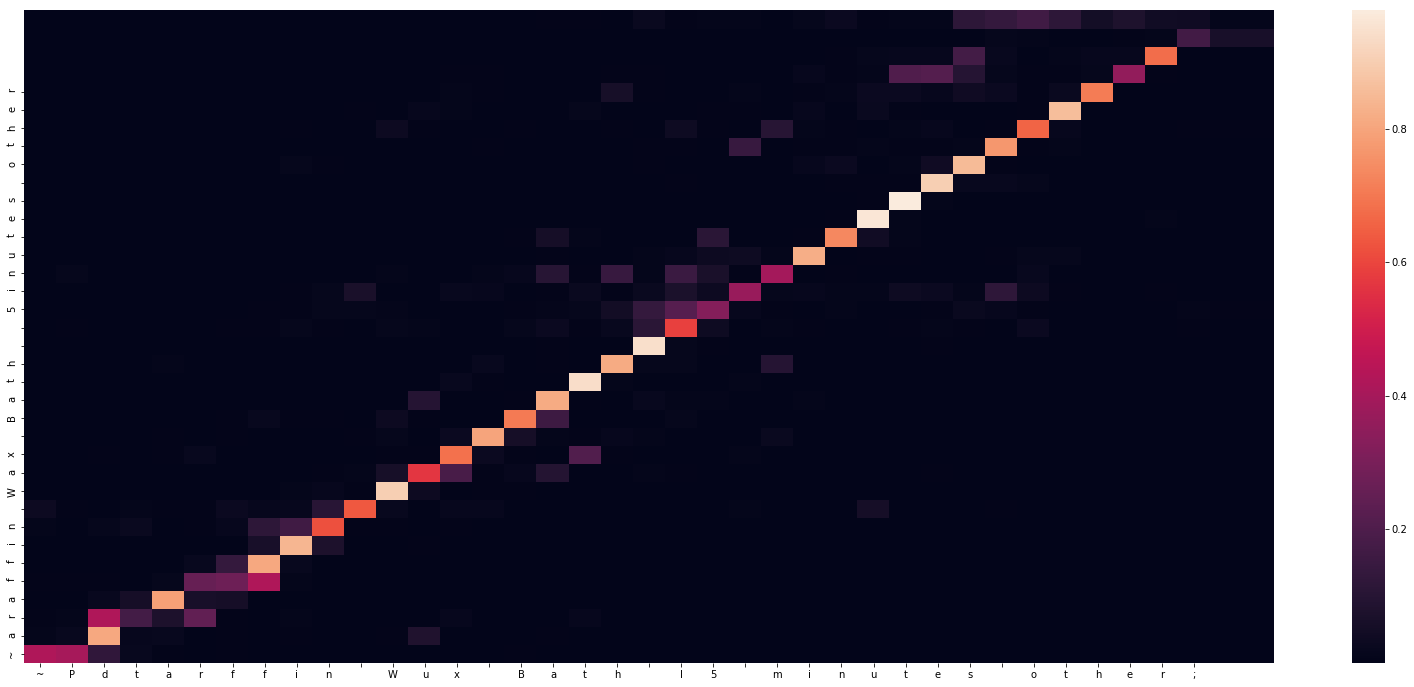

-
Input sentence: ~Pdtarffin Wux Bath I5 minutes other;
GT sentence: Paraffin Wax Bath 15 minutes other:

Decoded sentence: ~araffin Wax Bath  5inutes other


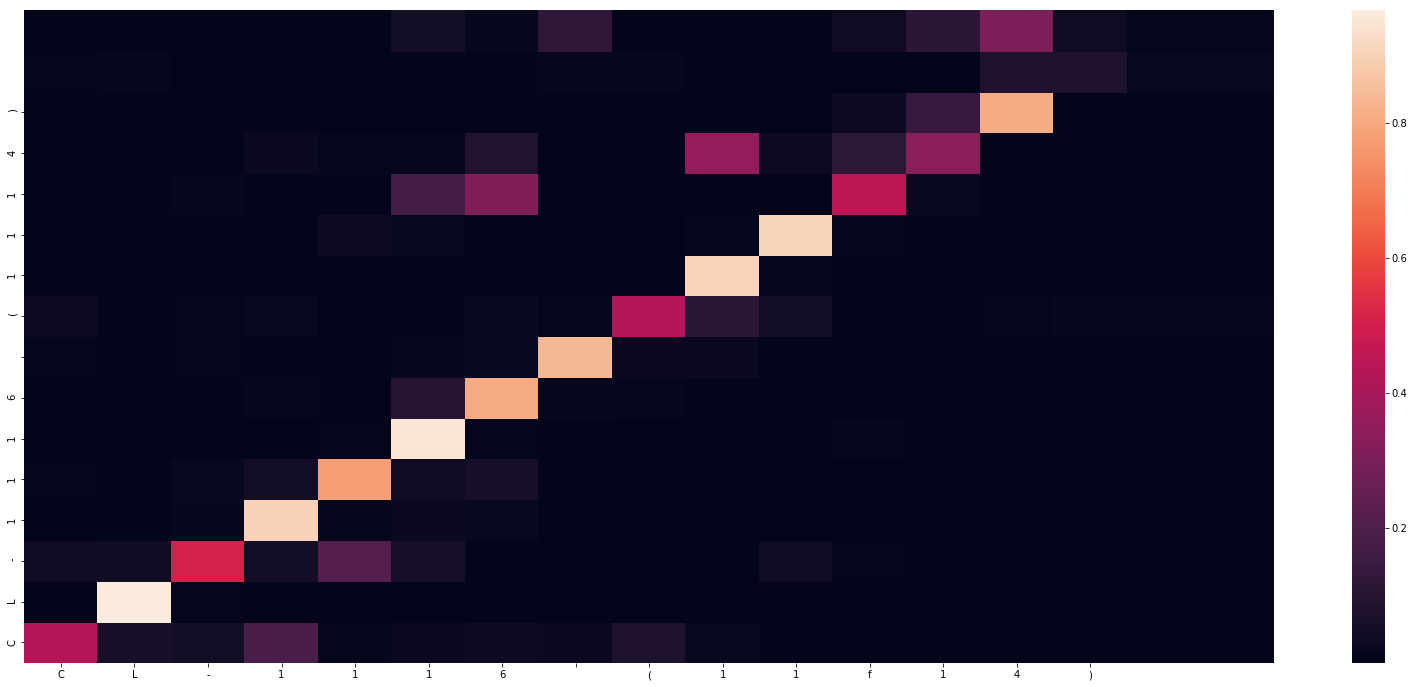

-
Input sentence: CL-1116 (11f14)
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (1114)


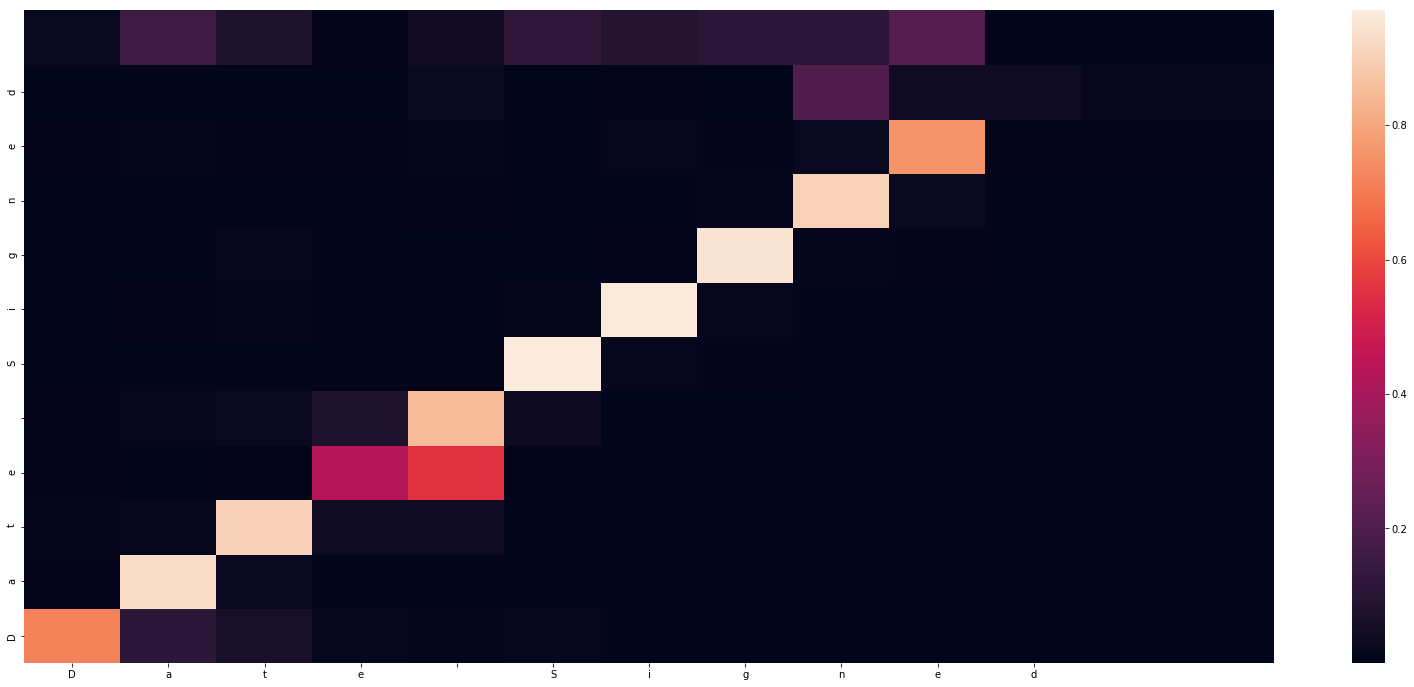

-
Input sentence: Date Signed
GT sentence: Date Signed

Decoded sentence: Date Signed


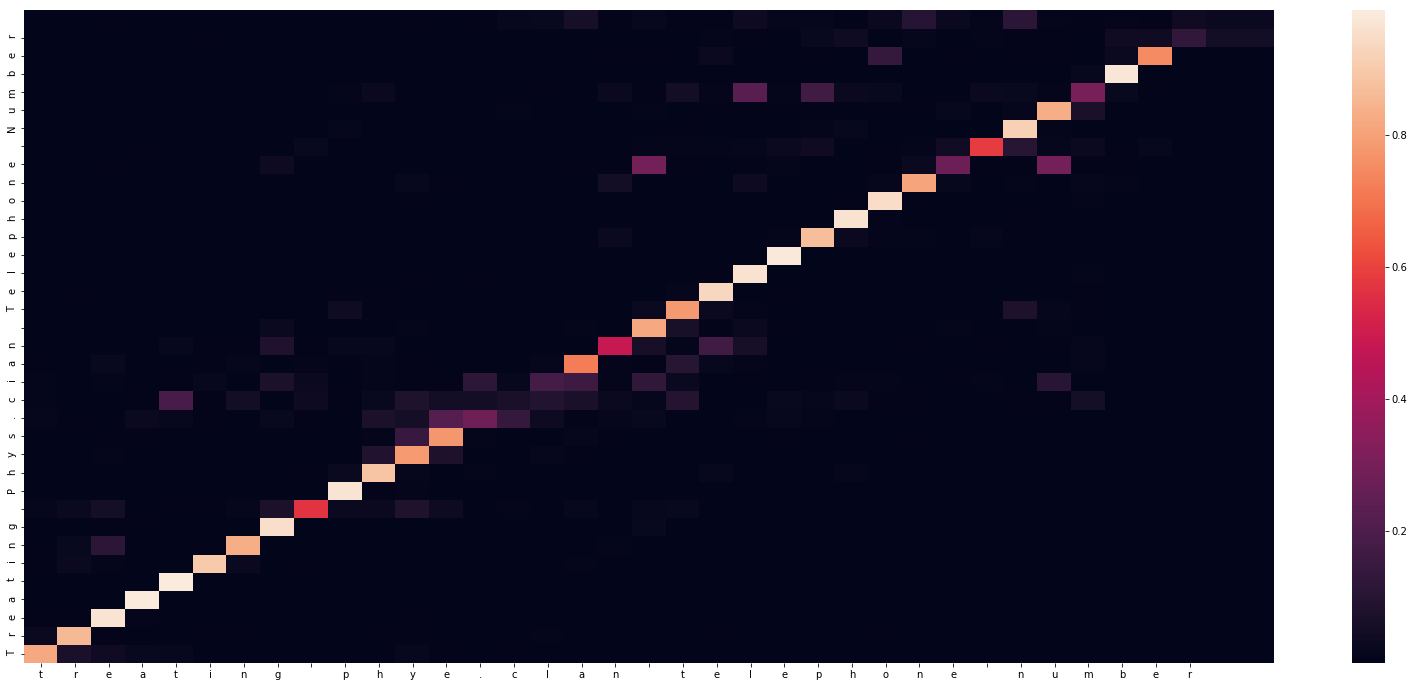

-
Input sentence: treating phye.clan telephone number
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treating Phys.cian Telephone Number


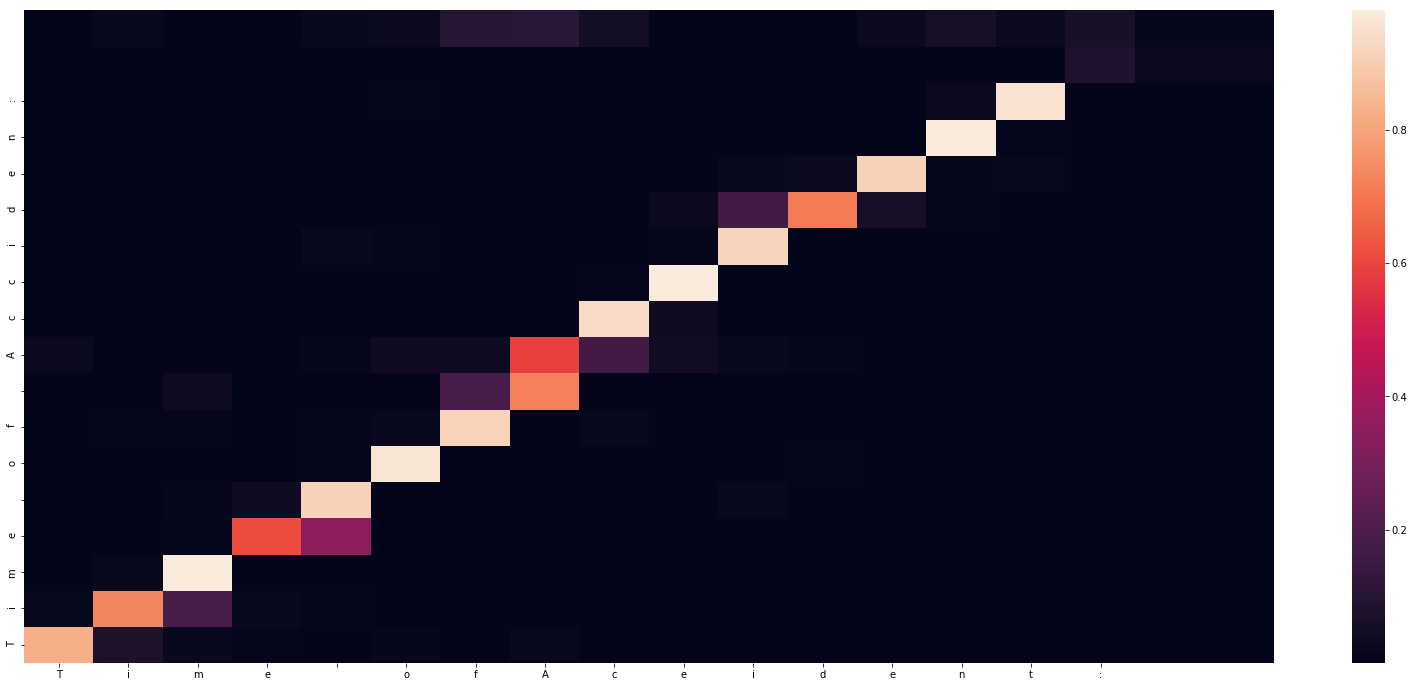

-
Input sentence: Time ofAceident:
GT sentence: Time of Accident:

Decoded sentence: Time of Acciden:


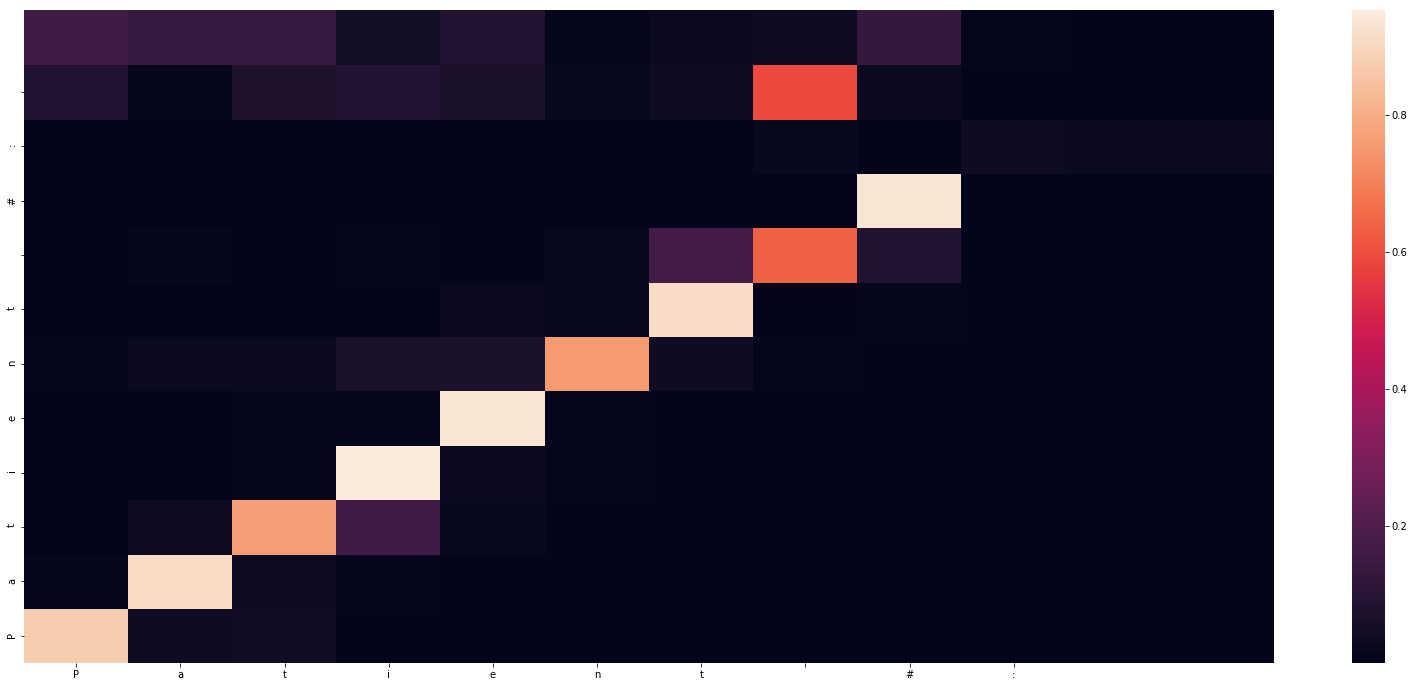

-
Input sentence: Patient #:
GT sentence: Patient #: 

Decoded sentence: Patient #: 


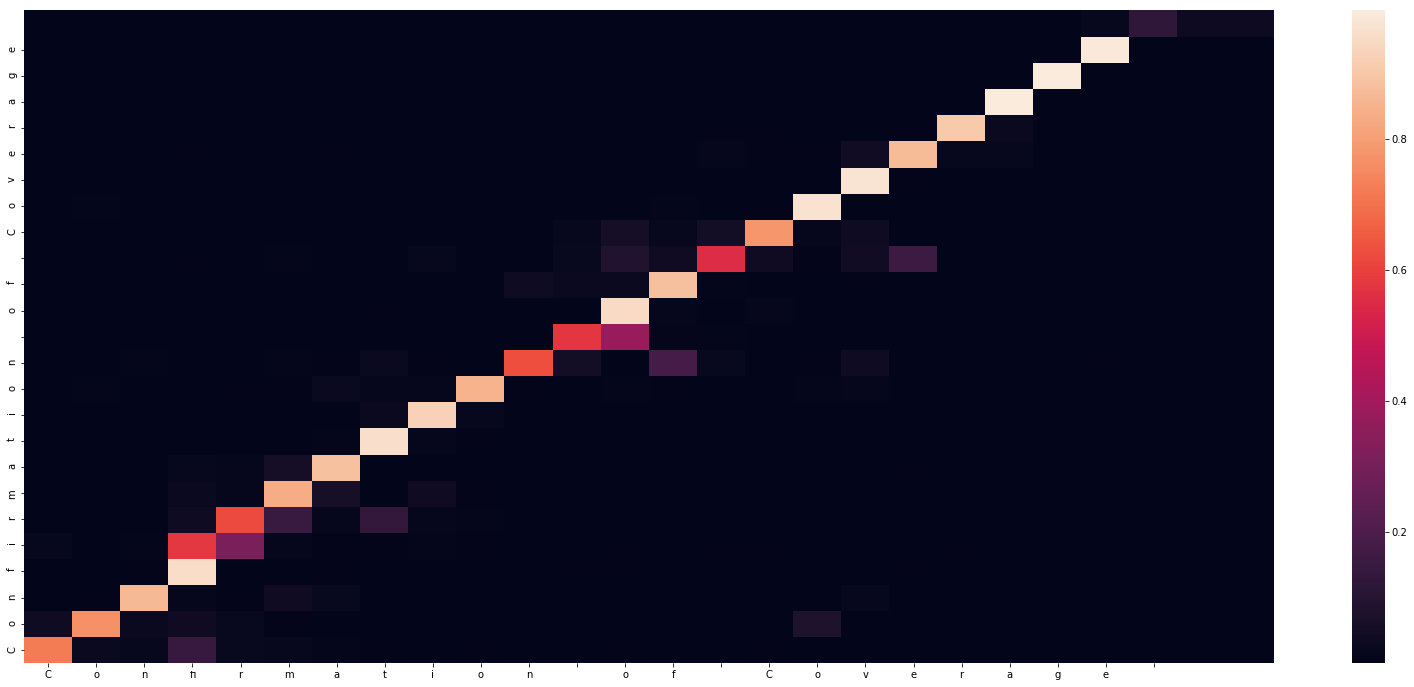

-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage


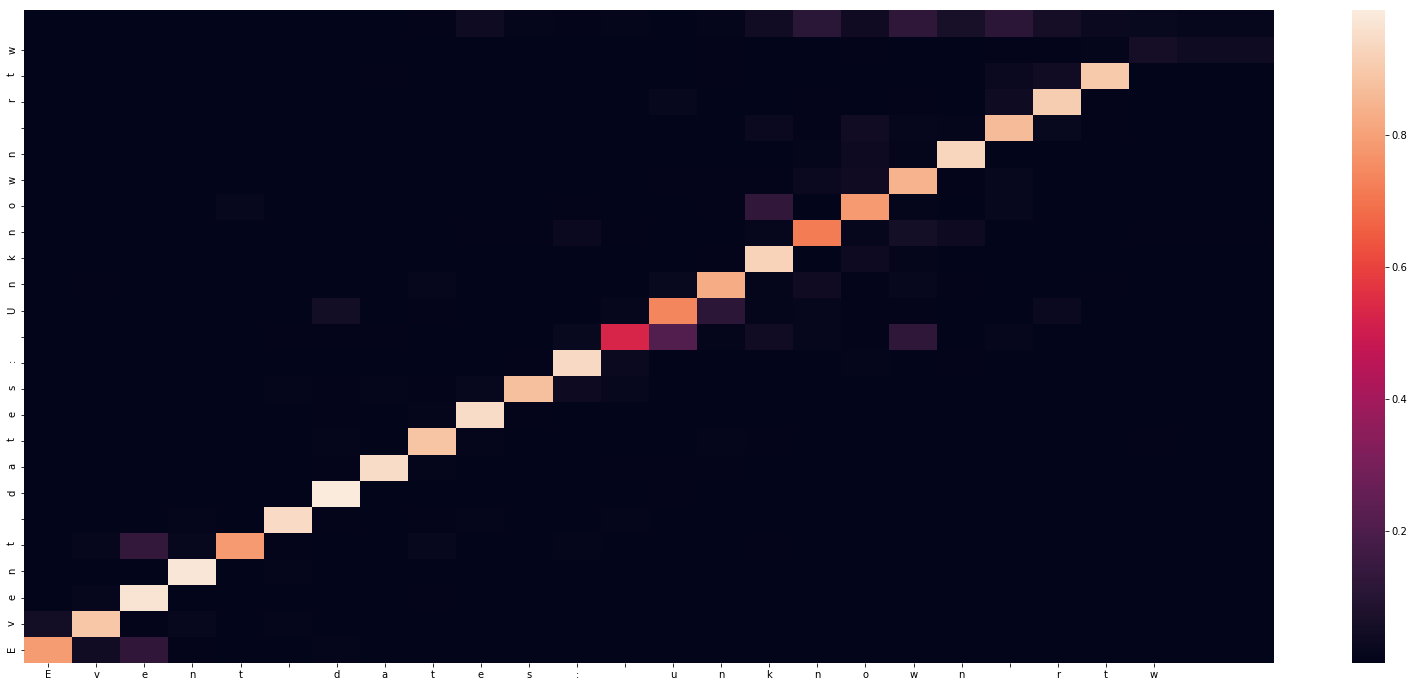

-
Input sentence: Event dates: unknown rtw
GT sentence: Event dates: unknown rtw

Decoded sentence: Event dates: Unknown rtw


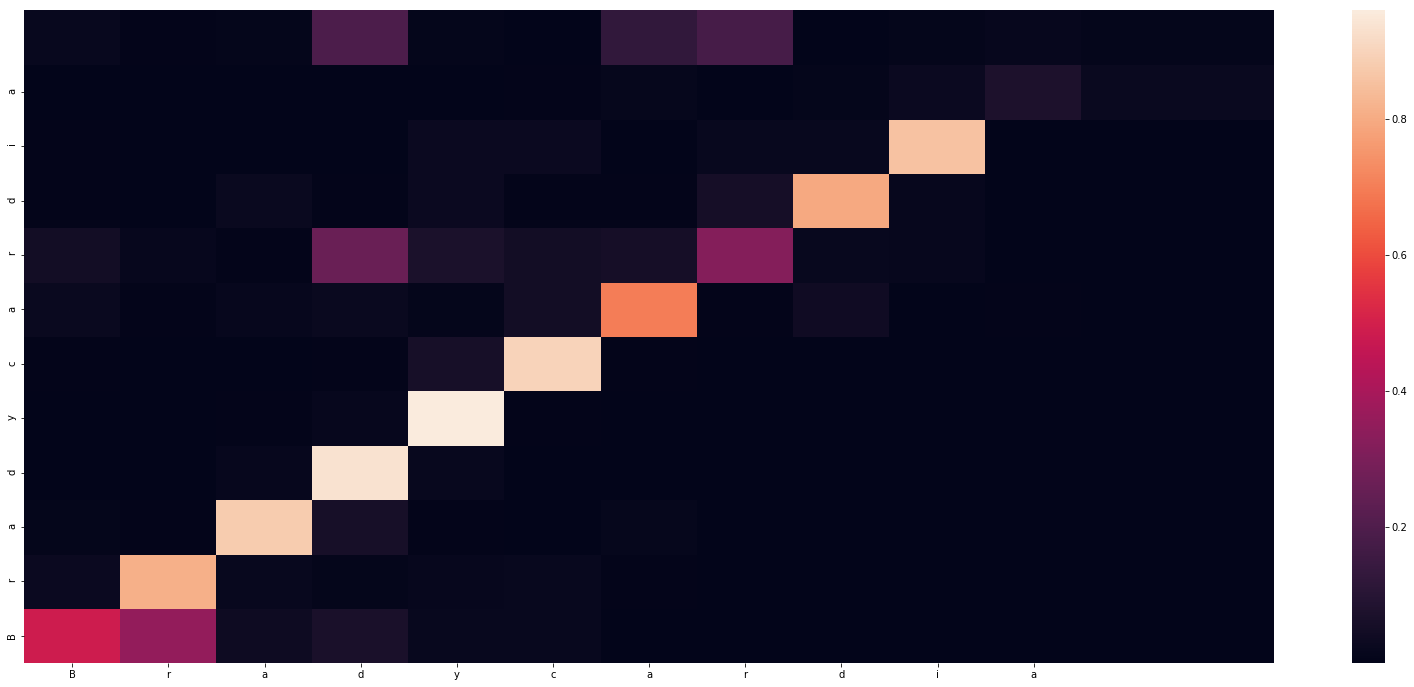

-
Input sentence: Bradycardia
GT sentence: Bradycardia

Decoded sentence: Bradycardia


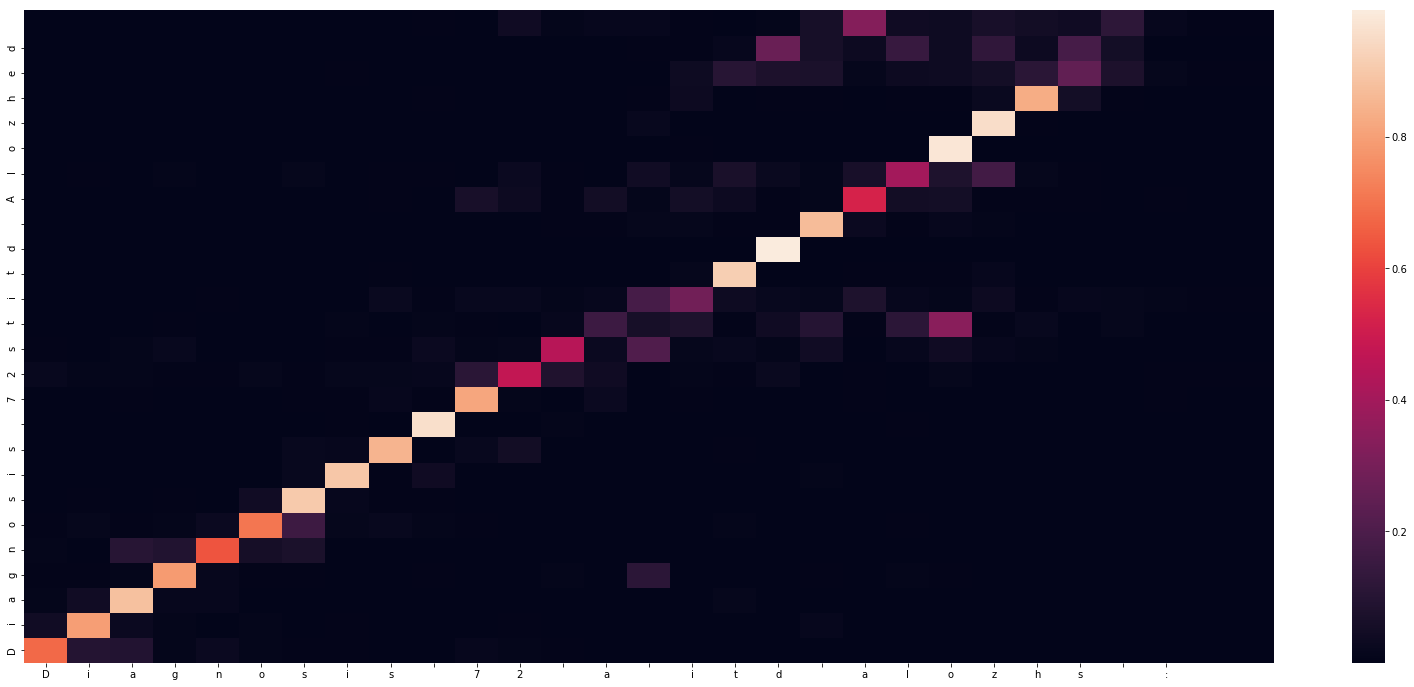

-
Input sentence: Diagnosis 72 a itd alozhs :
GT sentence: Diagnosis: 722.211A

Decoded sentence: Diagnosis 72stitd Alozhed


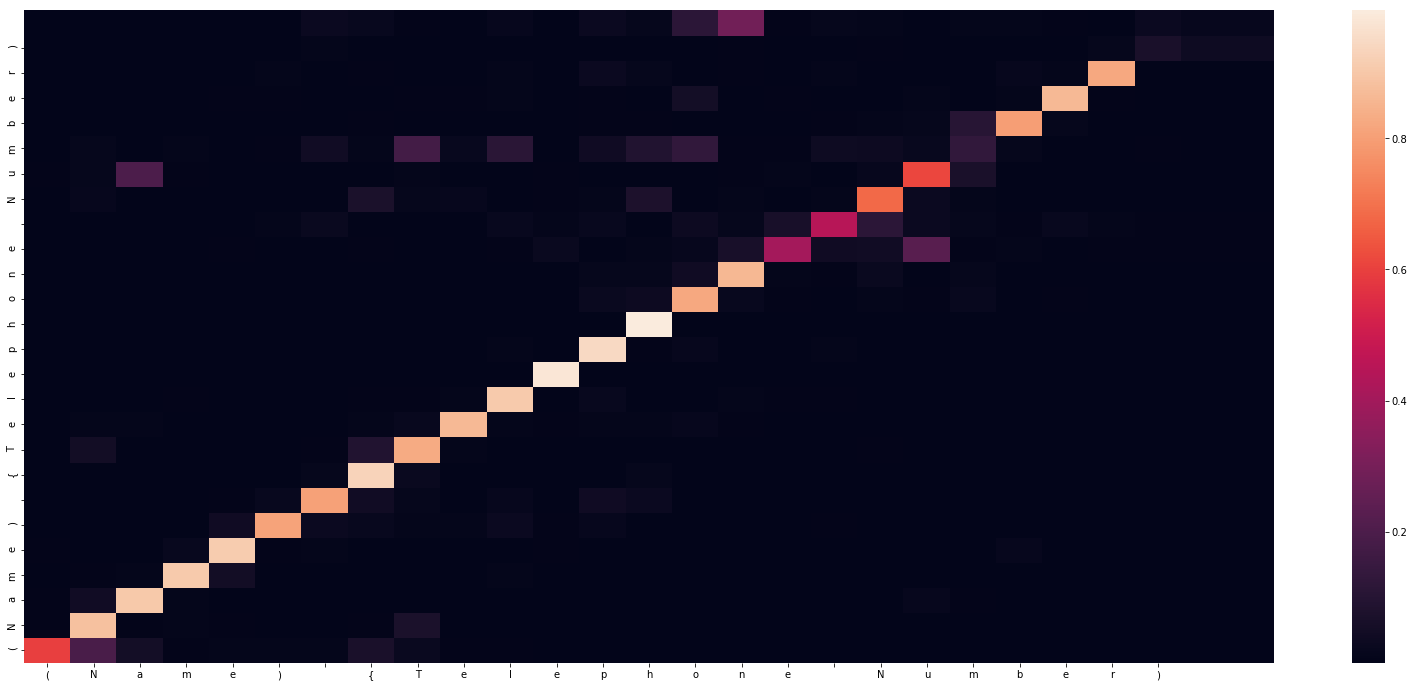

-
Input sentence: (Name) {Telephone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (Name) {Telephone Number)


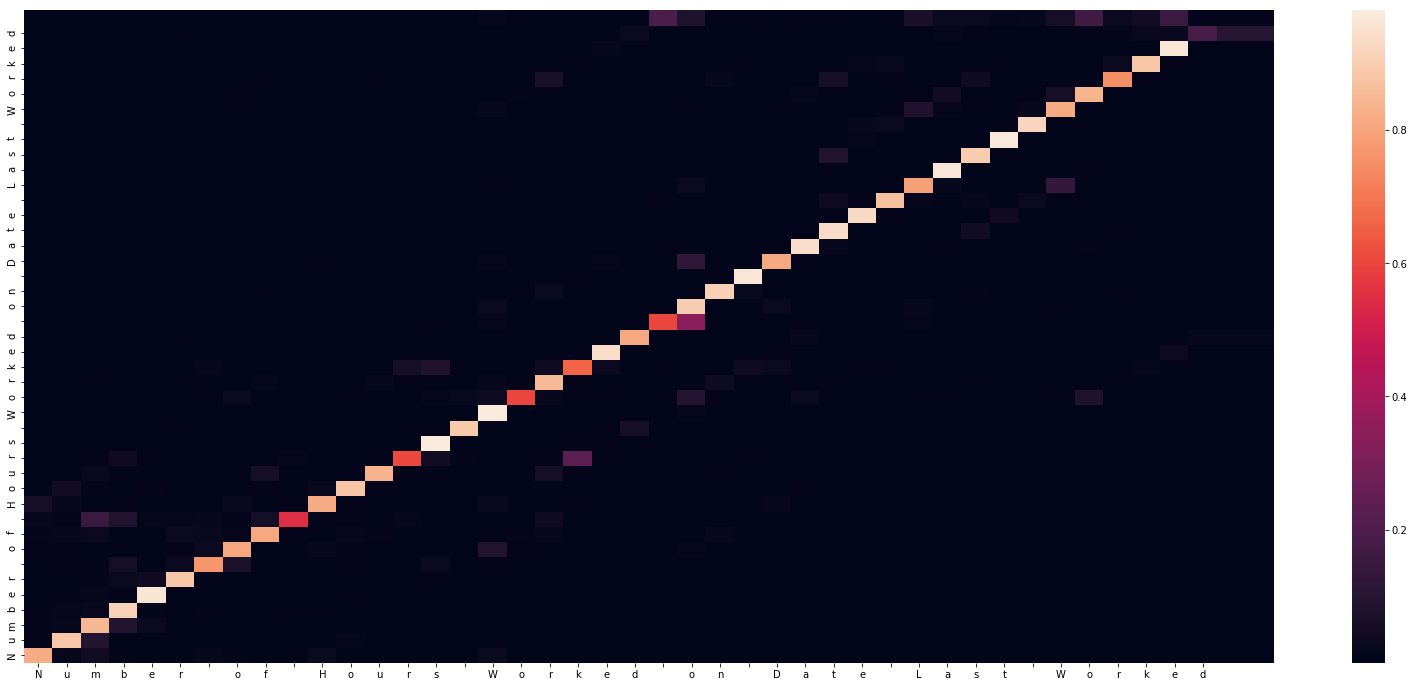

-
Input sentence: Number of Hours Worked on Date Last Worked
GT sentence: Number of Hours Worked on Date Last Worked

Decoded sentence: Number of Hours Worked on Date Last Worked


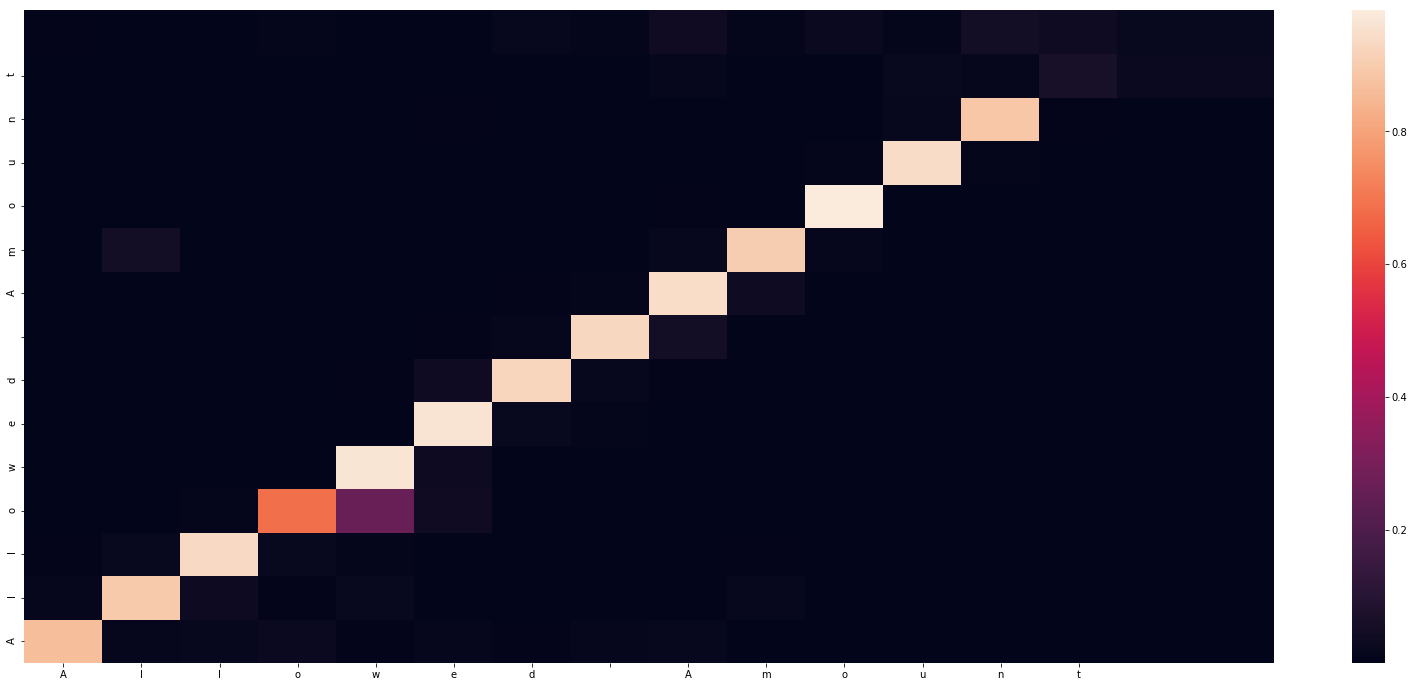

-
Input sentence: Allowed Amount
GT sentence: Allowed Amount

Decoded sentence: Allowed Amount


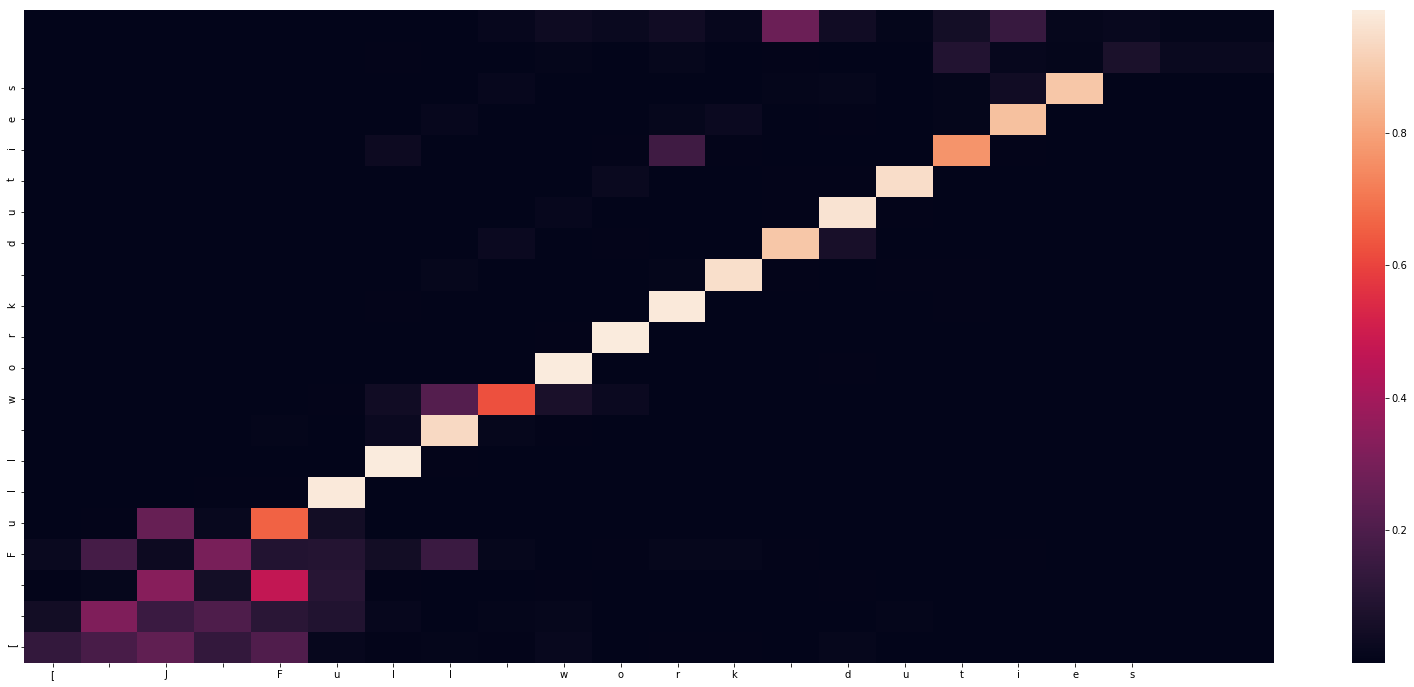

-
Input sentence: [ J Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [  Full work duties


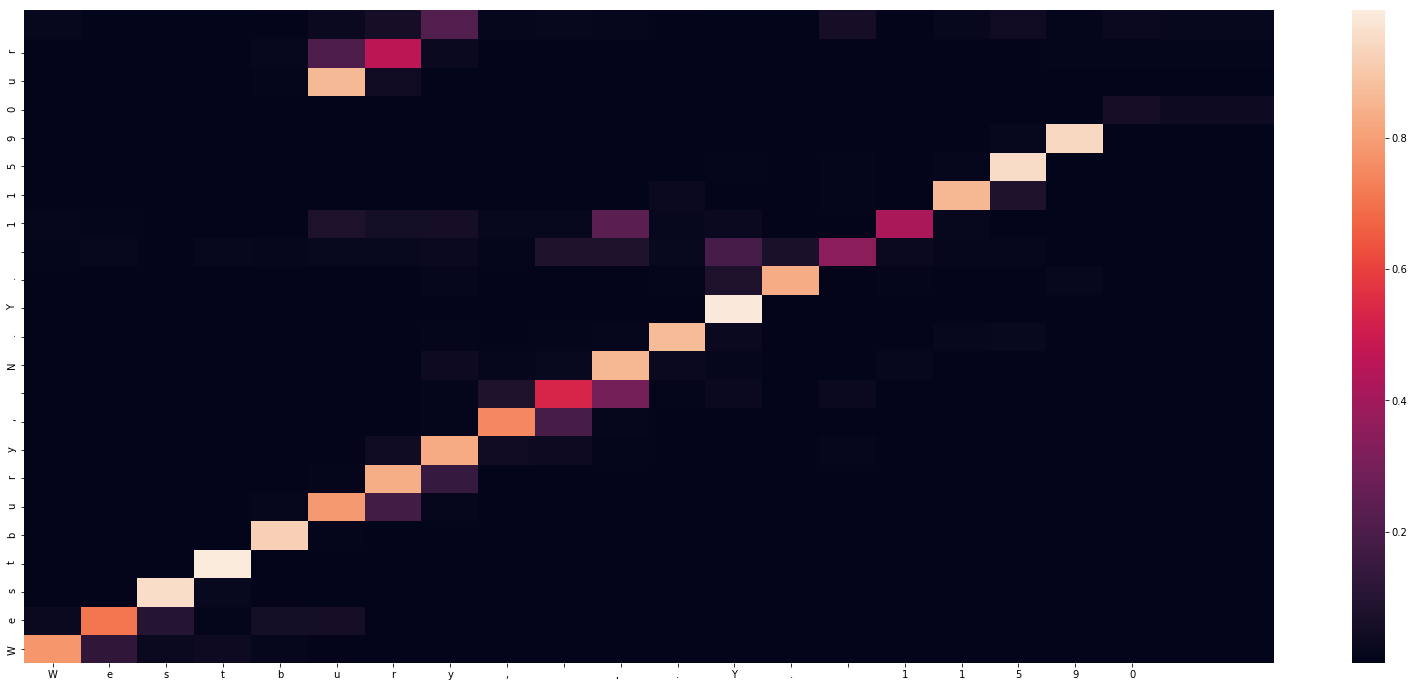

-
Input sentence: Westbury, ■.Y. 11590
GT sentence: Westbury, N.Y. 11590

Decoded sentence: Westbury, N.Y. 11590ur


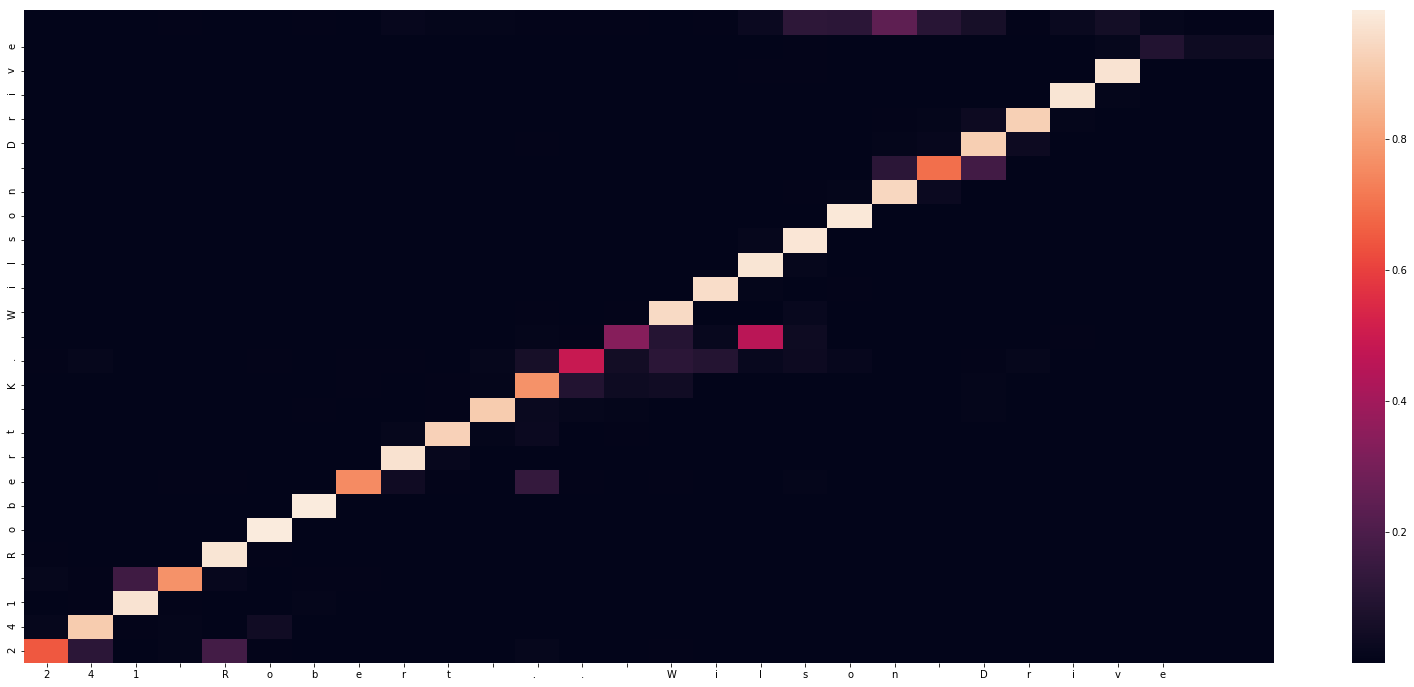

-
Input sentence: 241 Robert ☒. Wilson Drive
GT sentence: 241 Robert K. Wilson Drive

Decoded sentence: 241 Robert K. Wilson Drive


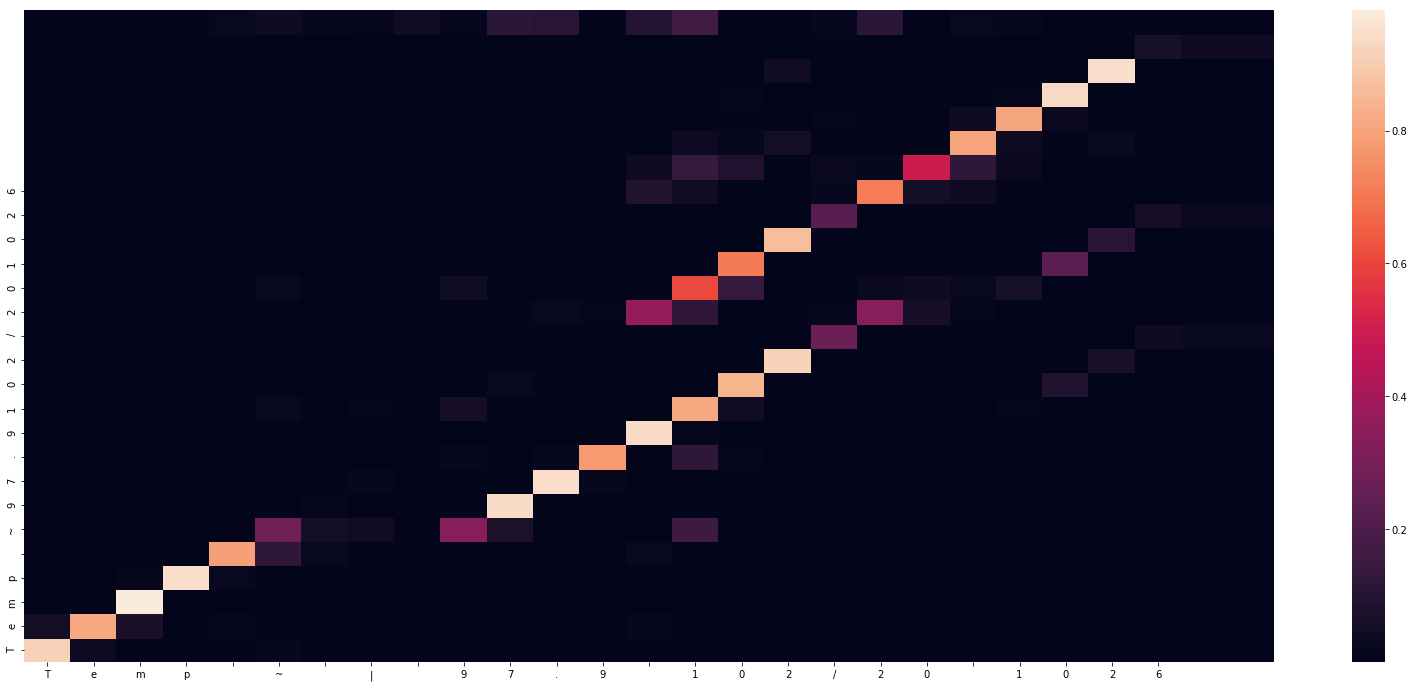

-
Input sentence: Temp ~ | 97.9 102/20 1026
GT sentence: Temp 97.9 02/20 1026

Decoded sentence: Temp ~97.9102/201026


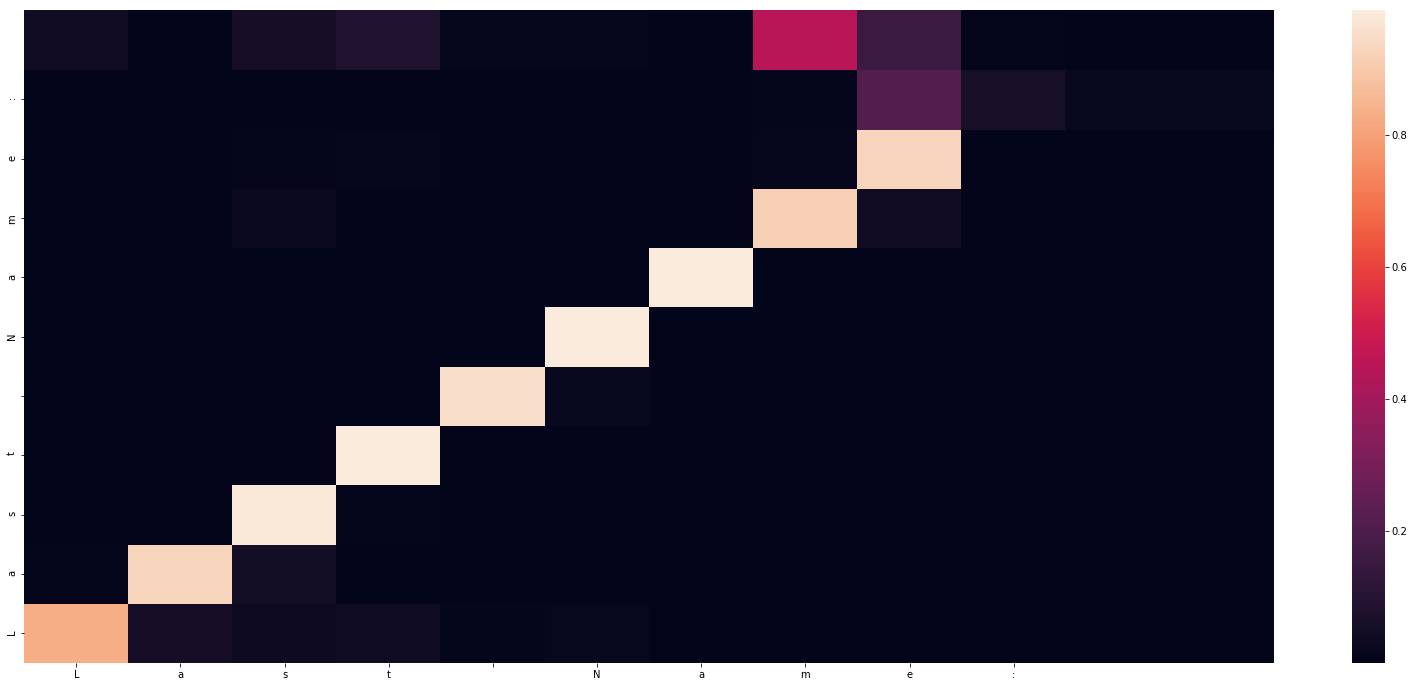

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:


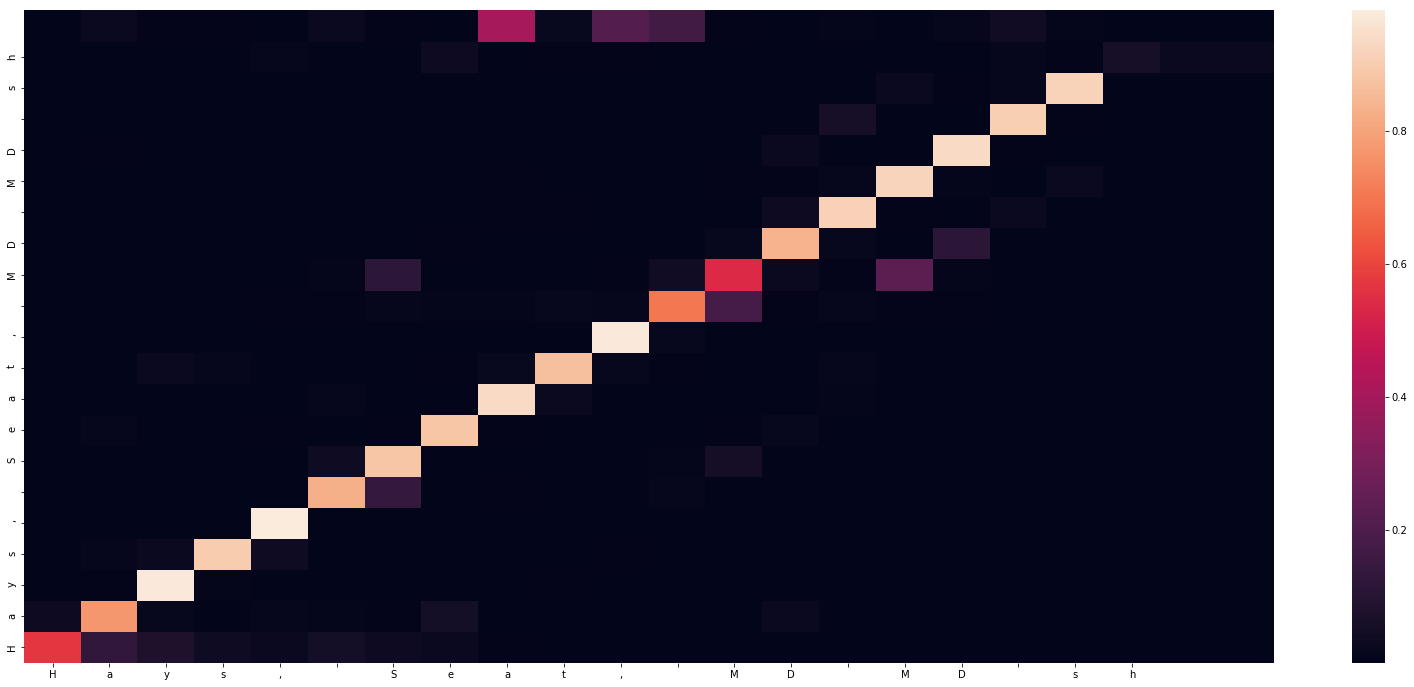

-
Input sentence: Hays, Seat, MD MD sh
GT sentence: Hays, Seat, MD MD sh

Decoded sentence: Hays, Seat, MD MD sh


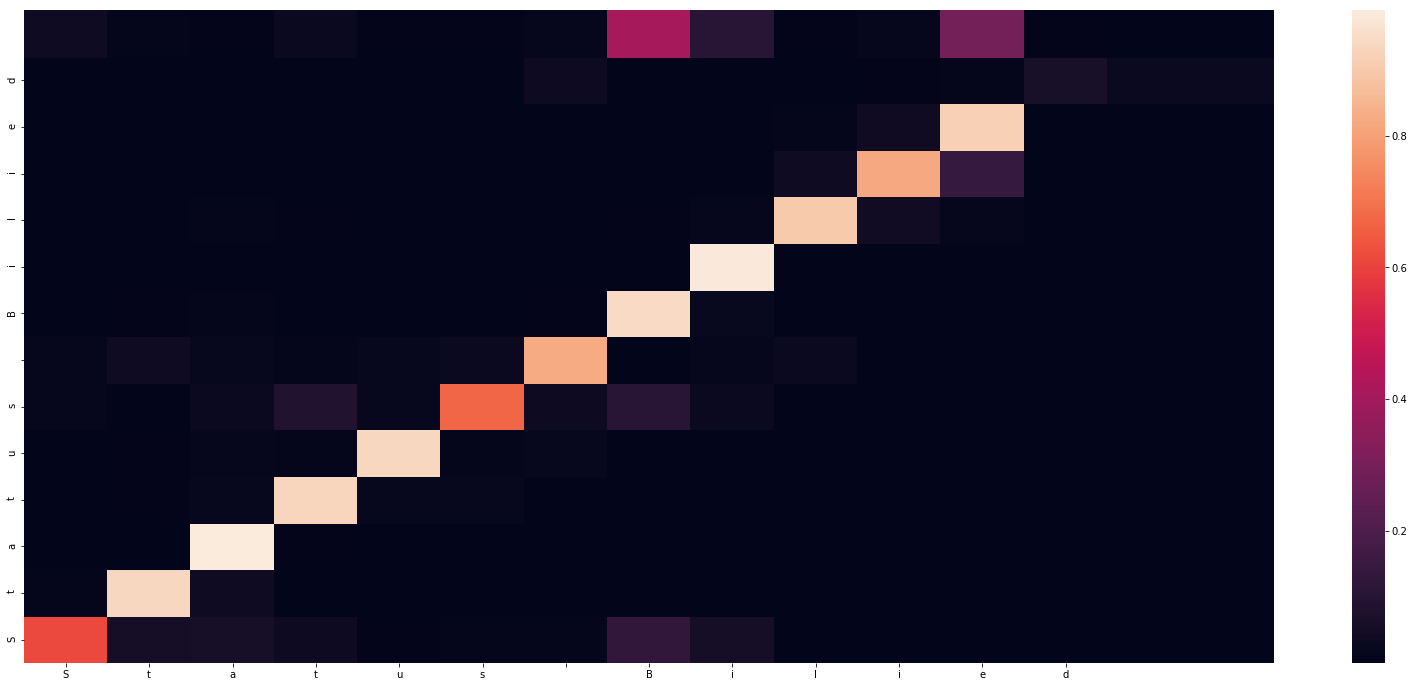

-
Input sentence: Status Bilied
GT sentence: Status Billed

Decoded sentence: Status Bilied


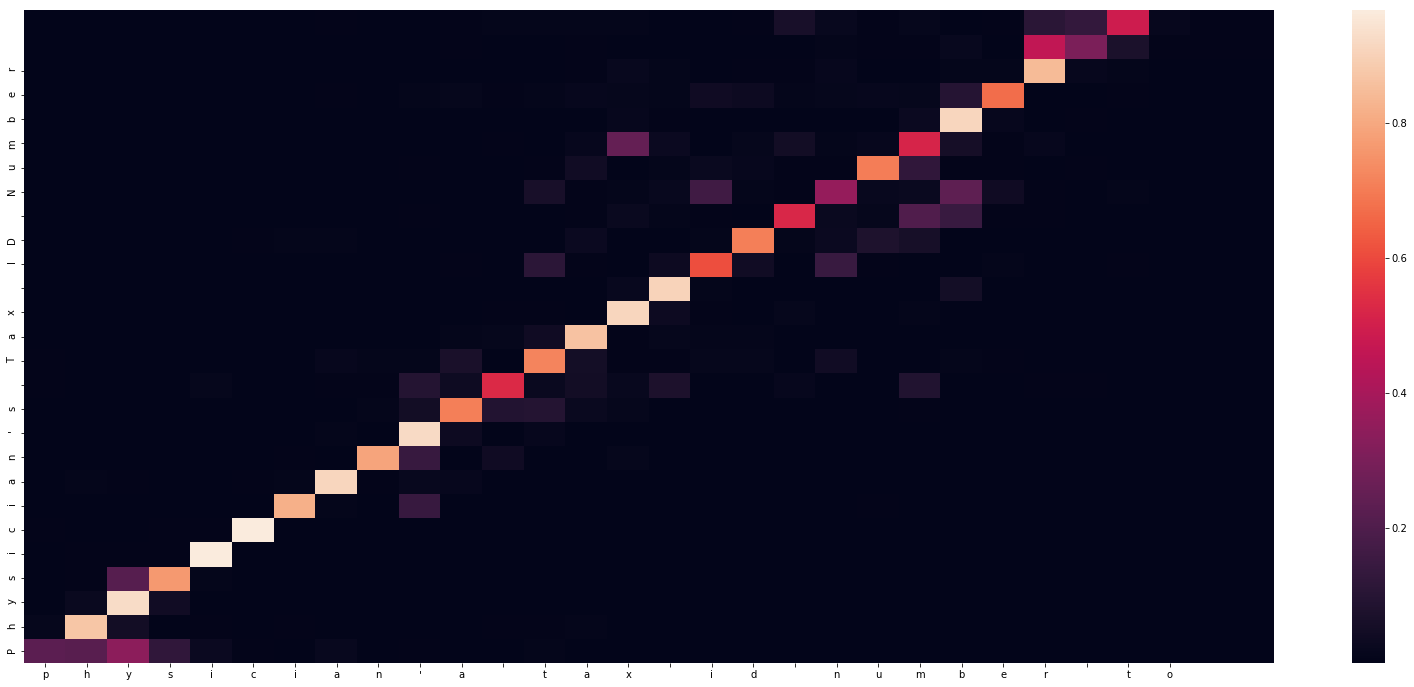

-
Input sentence: physician'a tax id number to
GT sentence: Physician's Tax ID Number:

Decoded sentence: Physician's Tax ID Number


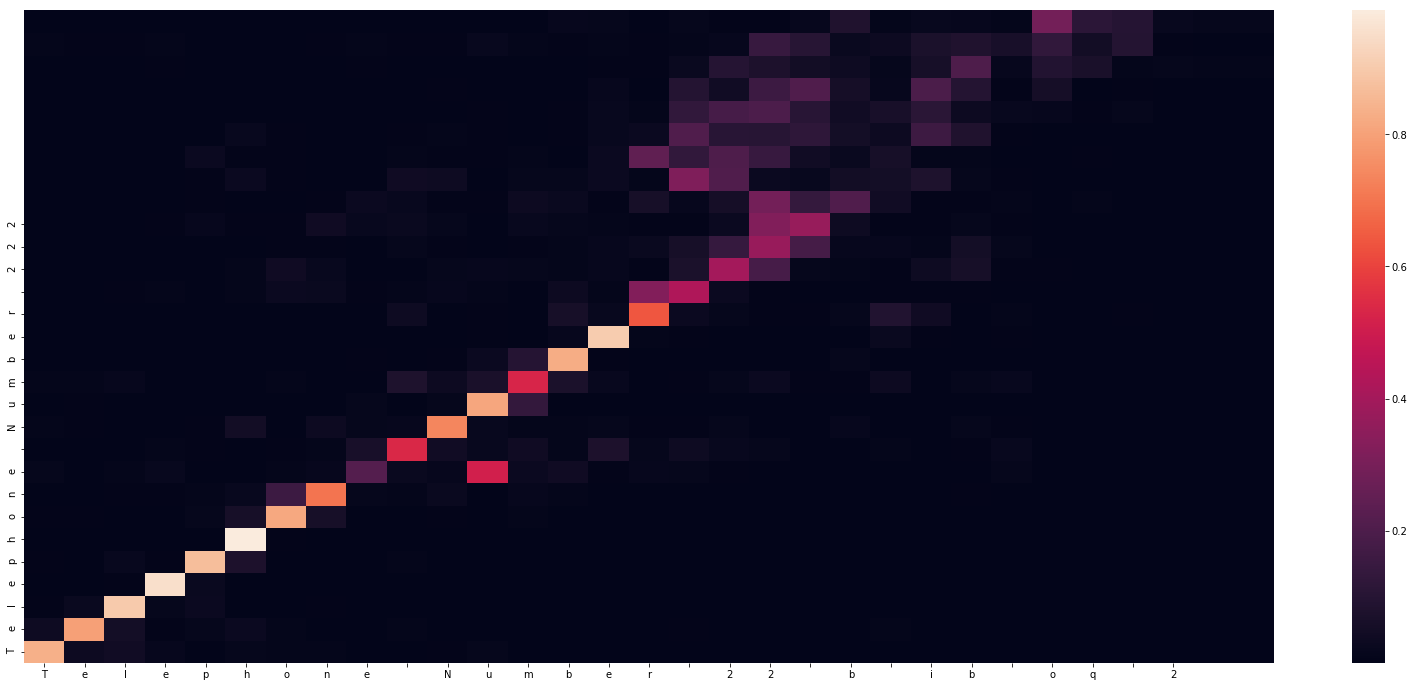

-
Input sentence: Telephone Number 22 b ib oq 2
GT sentence: Telephone Number 3367168092

Decoded sentence: Telephone Number 222


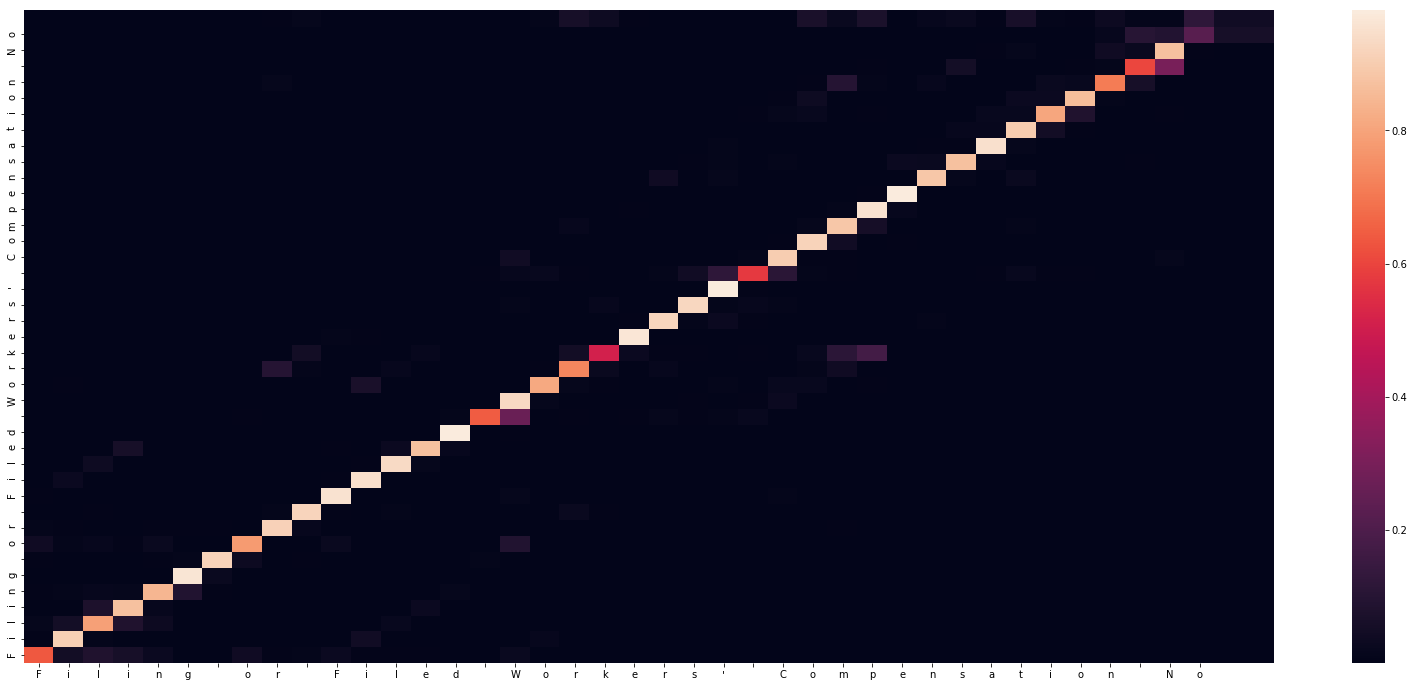

-
Input sentence: Filing or Filed Workers' Compensation No
GT sentence: Filing or Filed Workers' Compensation: No

Decoded sentence: Filing or Filed Workers' Compensation No


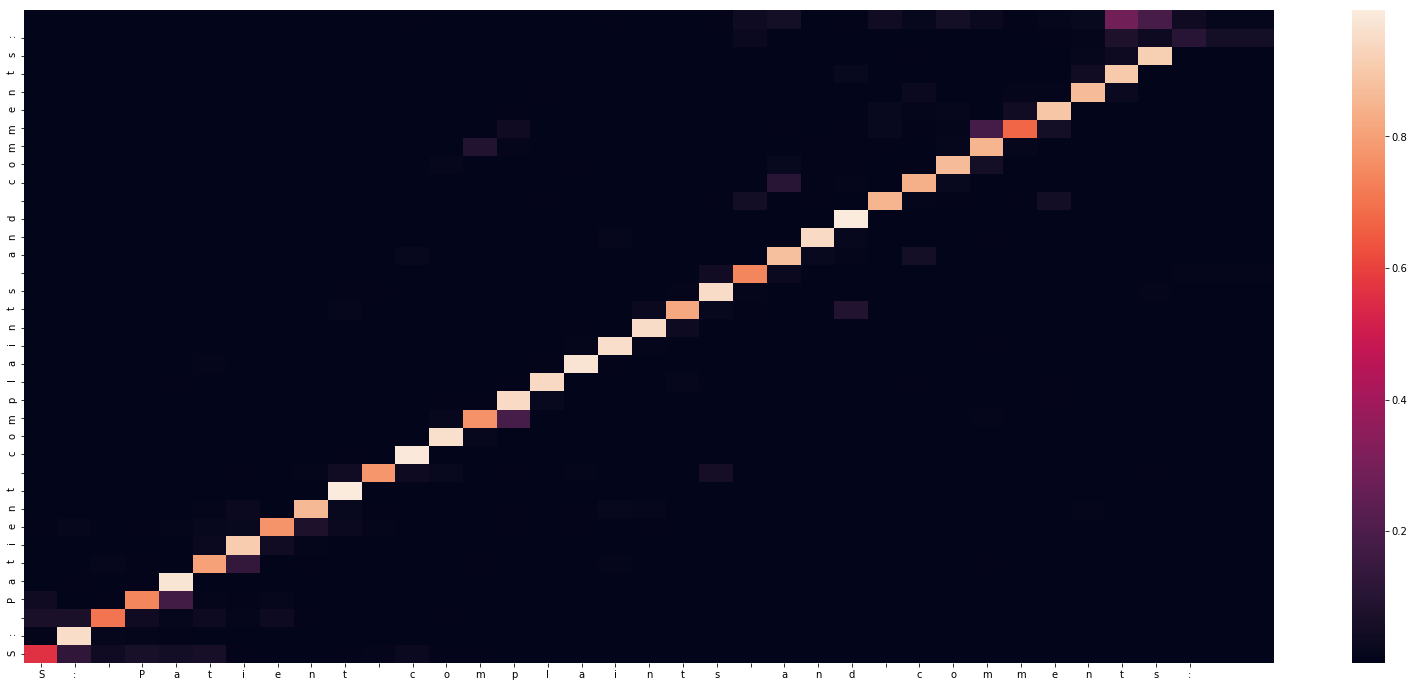

-
Input sentence: S: Patient complaints and comments:
GT sentence: S: Patient complaints and comments:

Decoded sentence: S: Patient complaints and comments:


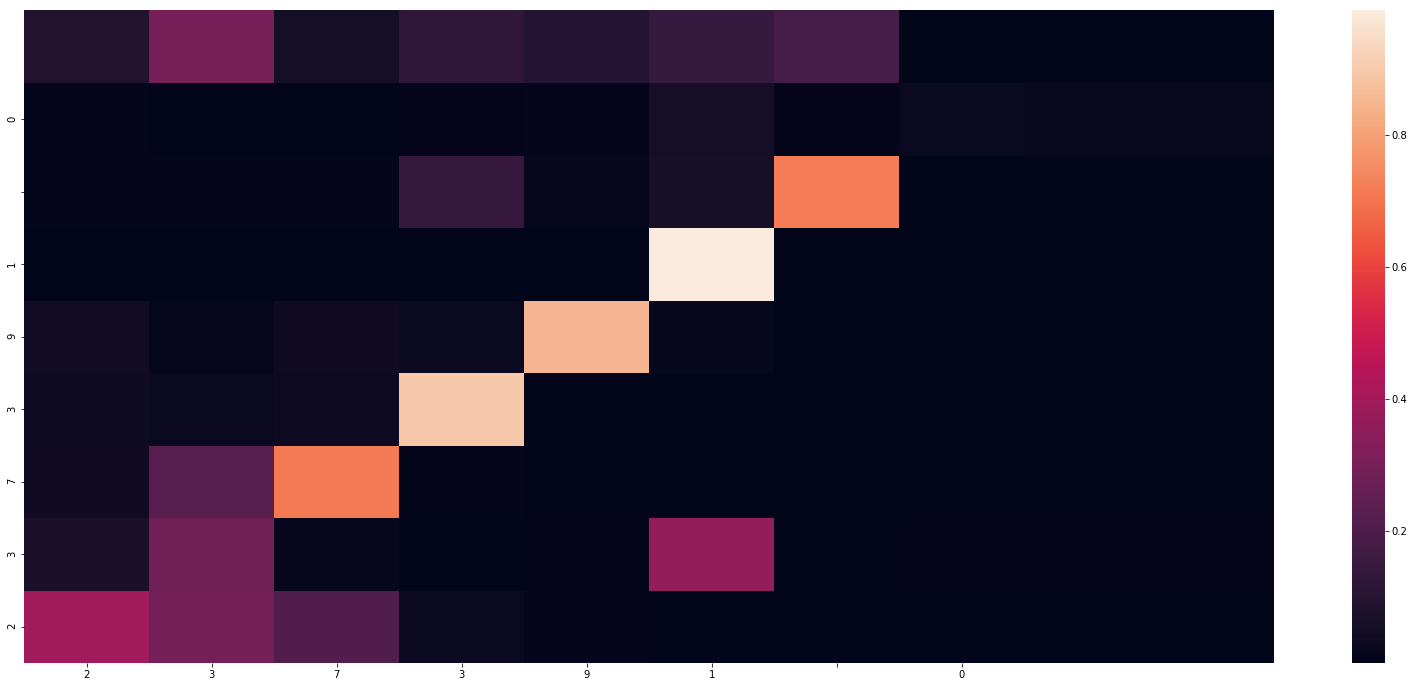

-
Input sentence: 237391 0
GT sentence: Z87891 ?

Decoded sentence: 237391 0


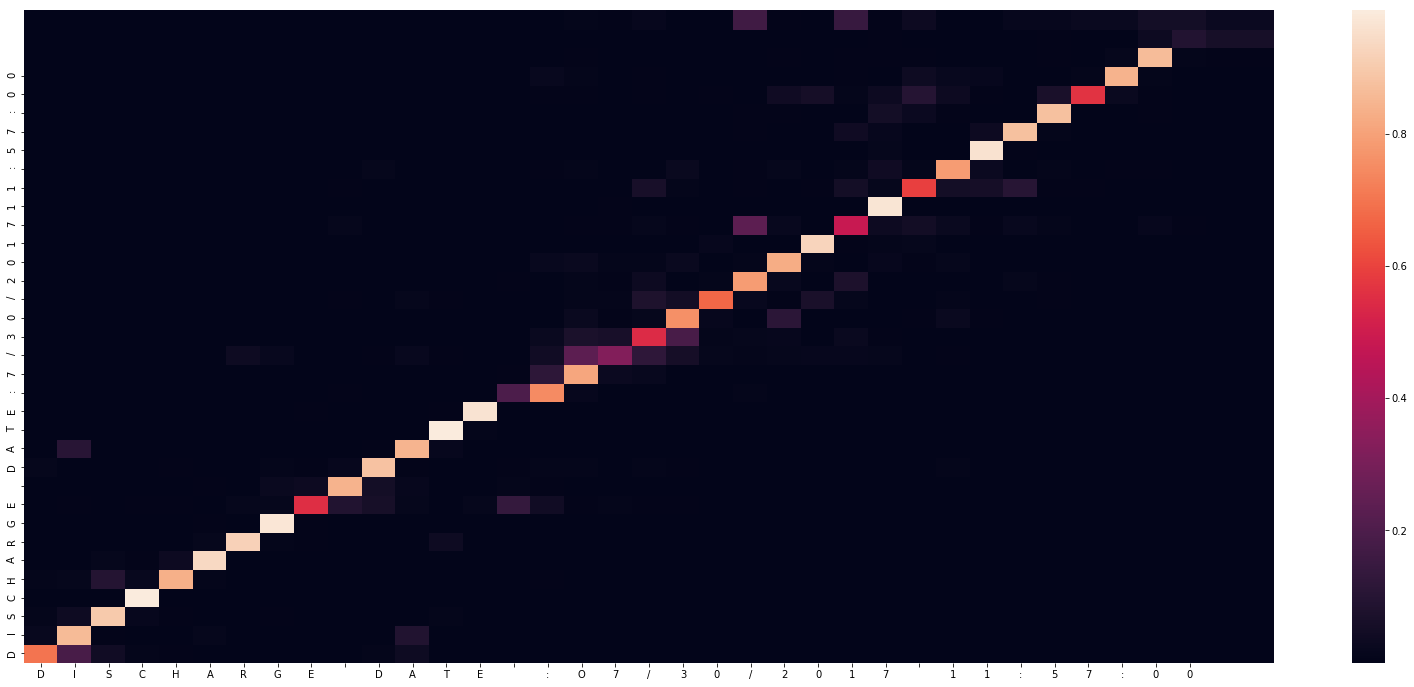

-
Input sentence: DISCHARGE DATE :O7/30/2017 11:57:00
GT sentence: DISCHARGE DATE:O7/30/2017 11:57:00

Decoded sentence: DISCHARGE DATE:7/30/201711:57:00


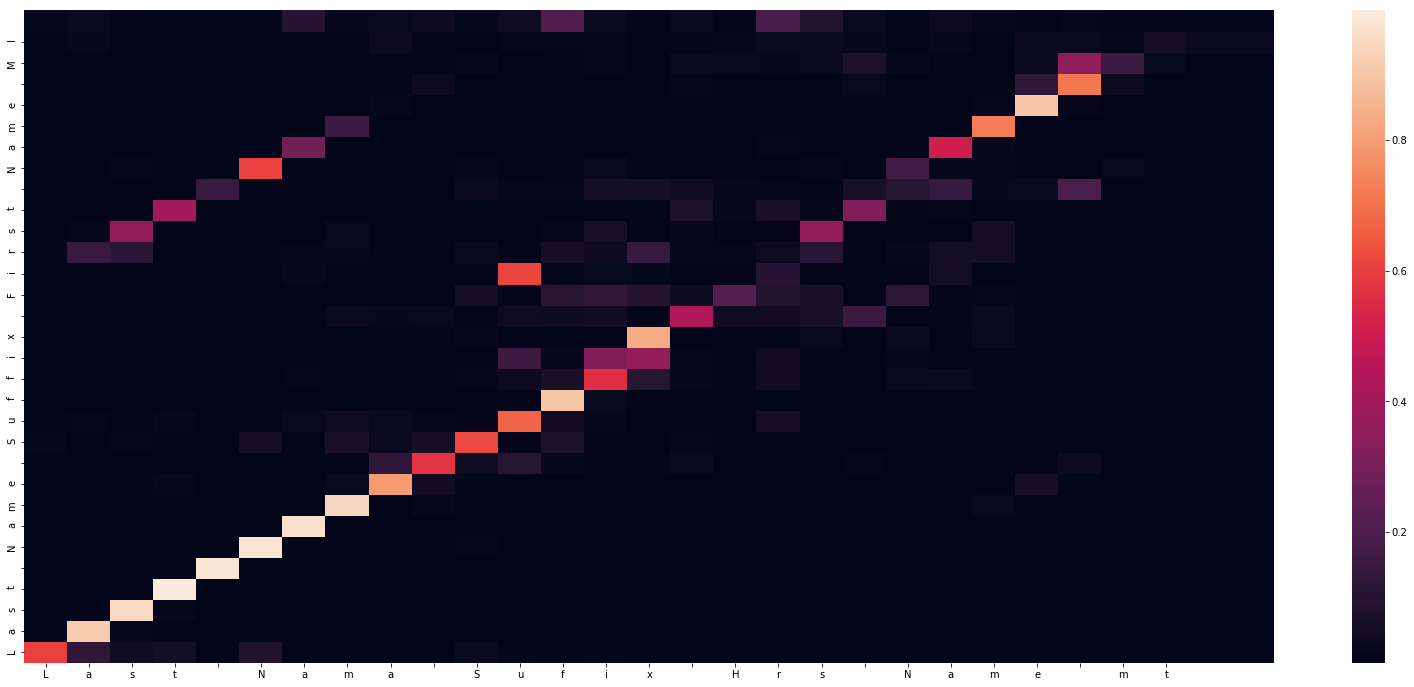

-
Input sentence: Last Nama Sufix Hrs Name mt
GT sentence: Last Name Suffix First Name MI

Decoded sentence: Last Name Suffix First Name MI


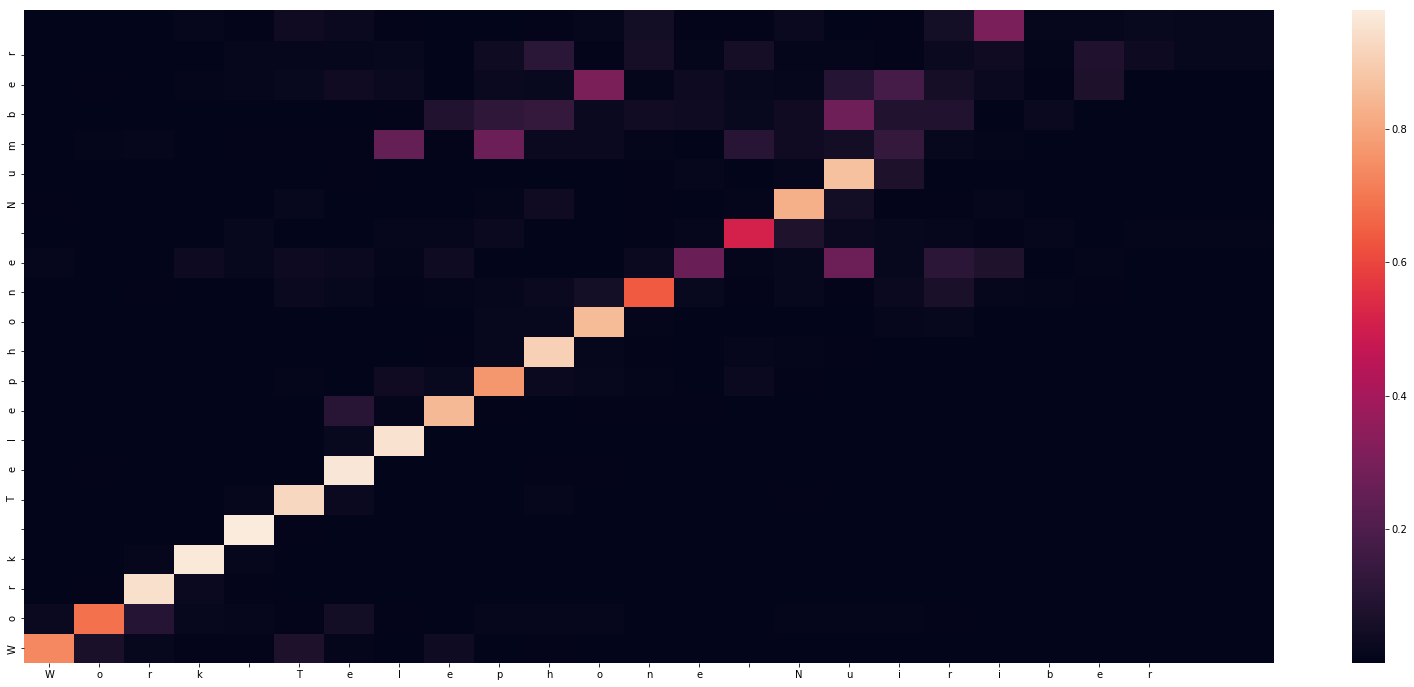

-
Input sentence: Work Telephone Nuiriber
GT sentence: Work Telephone Number

Decoded sentence: Work Telephone Number


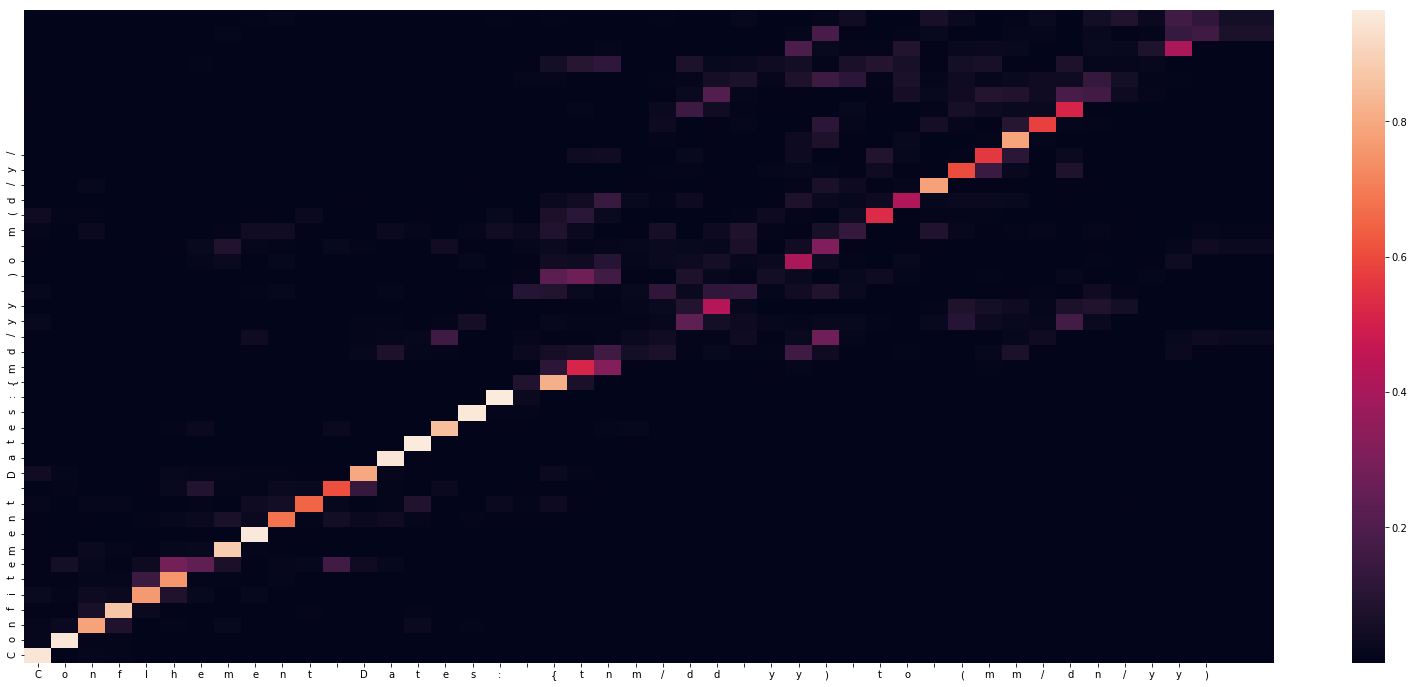

-
Input sentence: Conflhement Dates: {tnm/dd yy) to (mm/dn/yy)
GT sentence: Confinement Dates: (mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Confitement Dates:{md/yy )o m(d/y/


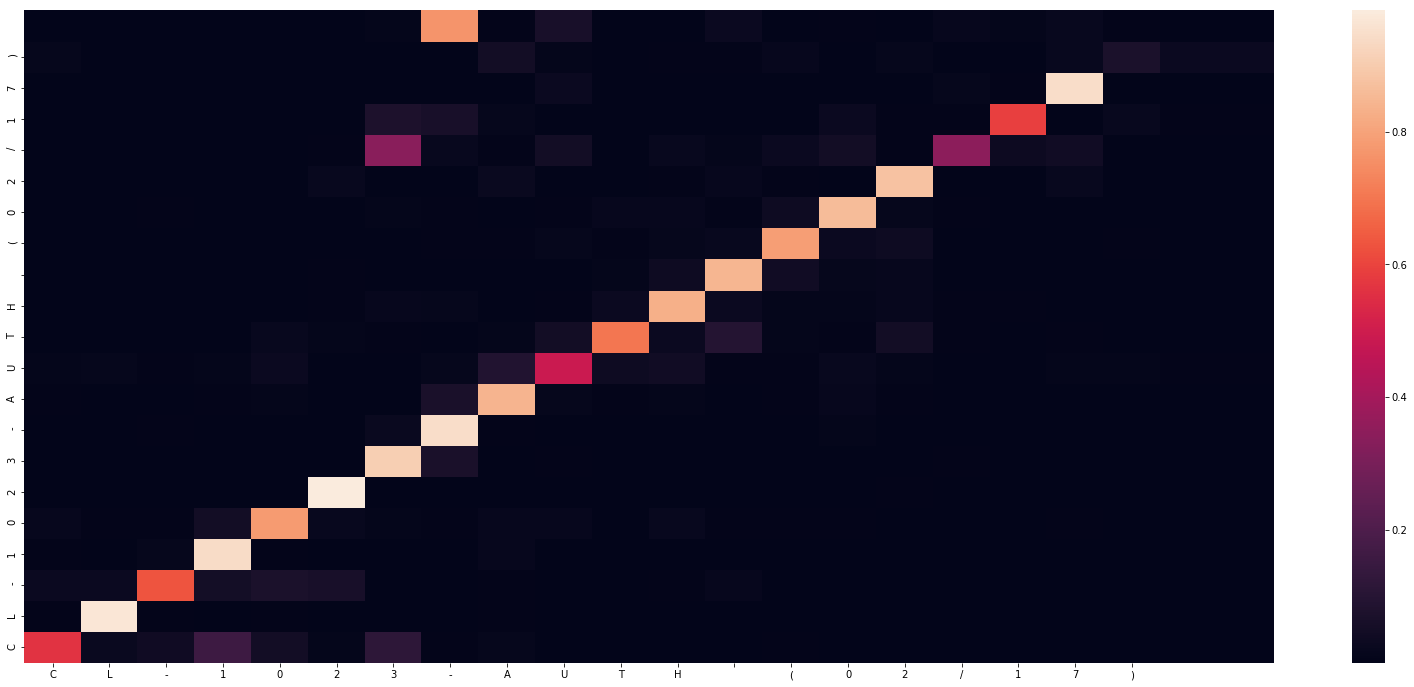

-
Input sentence: CL-1023-AUTH (02/17)
GT sentence: CL-1023-AUTH (02/17) 

Decoded sentence: CL-1023-AUTH (02/17)


In [46]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


# Test data

In [47]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: ☐ Long Term Disability
GT sentence: ☐ Long Term Disability

Decoded sentence: ☐ Long Term Disability
-
Input sentence: Physi Ex
GT sentence: Physical Exam

Decoded sentence: Physiciax
-
Input sentence: :A. Continue PT/hore exercise program
GT sentence: 3. Continue PT/home exercise program

Decoded sentence: :.Continue PT/ore exercise programa
-
Input sentence: Pat Pmt
GT sentence: Pat. Pmt.

Decoded sentence: Pat Pat Pat Pat Pat Pat Pat Pat Pat Pat Pat Pat Pa
-
Input sentence: [ ] Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [ ] Full work duties
-
Input sentence: Customer #
GT sentence: Customer #

Decoded sentence: Customer #
-
Input sentence: (Name / Relationship)
GT sentence: (Name / Relationship)

Decoded sentence: (Name / Relationship)
-
Input sentence: MyDCH Patlent Portal Info,
GT sentence: MyDCH Patient Portal Info,

Decoded sentence: MyDCH Patient Portal Info,
-
Input sentence: E11113] arm en t In formation
GT sentence: Employment Inf

-
Input sentence: Claim No: ' _"
GT sentence: Claim No:

Decoded sentence: Claim No: No
-
Input sentence: » Pain in thoracic spine
GT sentence: • Pain in thoracic spine

Decoded sentence: * Pain in thoracic spine
-
Input sentence: Insured’s Sigigture
GT sentence: Insured’s Signature

Decoded sentence: Insured’s Signature
-
Input sentence: Dhe Diagnoj
GT sentence: Primary Diagnosis: 

Decoded sentence: Dhe Diagnojis
-
Input sentence: Cottinetnent Pales:mmidd/yy) to (mmidd/yy} _
GT sentence: Confinement Dates:(mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Cottine Numberaice: mm/d)y t( mm/d}y
-
Input sentence: C mm’rry',
GT sentence: Country:

Decoded sentence: Country
-
Input sentence: S lute riProx-inee:
GT sentence: State/Province:

Decoded sentence: State rime
-
Input sentence: Medication Disposal
GT sentence: Medication Disposal

Decoded sentence: Medication Disposal
-
Input sentence: » swelling of eyelids, throat, lips
GT sentence: • swelling of eyelids, throat, lips

Decoded sentence:

-
Input sentence: ,, on 02/20/2018 at 1122 Ld
GT sentence: on 02/20/2018 at 1122

Decoded sentence: ,,r 02/20/2018t 1122d
-
Input sentence: Employee (Applicant)
GT sentence: Employee (Applicant)

Decoded sentence: Employee (Applicant)
-
Input sentence: Results
GT sentence: Results

Decoded sentence: Results
-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:
-
Input sentence: estimado paciente
GT sentence: Estimado Paciente:

Decoded sentence: Estestimado Paciente
-
Input sentence: Print Date/Time:
GT sentence: Print Date/Time:

Decoded sentence: Print Date/Time:
-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:
-
Input sentence: Date of Birth (mmfadiyy!
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mmddyy
-
Input sentence: CREDIT CARD
GT sentence: CREDIT CARD

Decoded sentence: CREDIT CARD
-
Input sentence: INITIAL EVALUATION
GT sentence: INITIAL EVALUATION

Decoded sentence: IN

-
Input sentence: DOB : ’
GT sentence: DOB:

Decoded sentence: DOB
-
Input sentence: Grade 2b Lachman's
GT sentence: Grade 2b Lachman's

Decoded sentence: Grade 2  Lachiane
-
Input sentence: | DISCH. DATE 07/30/2017
GT sentence: DISCH. DATE 07/30/2017 

Decoded sentence: DISCH . 07/30/2017
-
Input sentence: Back mom tender
GT sentence: Back non tender

Decoded sentence: Back Momothender
-
Input sentence: accident work related
GT sentence: Accident Work Related:

Decoded sentence: Accident work related
-
Input sentence: ☐ Shoit ‘term Glaablity
GT sentence: ☐ Short Term Disability

Decoded sentence: ☐ Short Term Glaablity
-
Input sentence: PATIENT‘S NAME
GT sentence: PATIENT'S NAME

Decoded sentence: PATIENT NAME
-
Input sentence: Social Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number
-
Input sentence: December 18, 2012
GT sentence: December 18, 2012

Decoded sentence: December 18, 2012
-
Input sentence: Date of Encounter; 03/06/2018
GT sente

-
Input sentence: Date i j 312/18
GT sentence: Date 3/2/18

Decoded sentence: Date if 312/18
-
Input sentence: History or W mm:
GT sentence: History of Present Illness:

Decoded sentence: History or W mm:
-
Input sentence: Extremities PAONM DORSUM RT H☒HAND
GT sentence: Extremities PAON DORSUM RT HAND

Decoded sentence: Extremities PAONM DORSUM RT HAND
-
Input sentence: please send payments to
GT sentence: please send payments to:

Decoded sentence: please send payments toon
-
Input sentence: Employee Off-Job Acc July 1, 2017
GT sentence: Employee Off-Job Acc July 1, 2017

Decoded sentence: Employee Off-Job Acc July 1, 2017
-
Input sentence: Assessment/Plar. I v Theo oC oh ooo] o-
GT sentence: Assessment/Plan:

Decoded sentence: Assessment/Plar. Inviceat on oc on ]
-
Input sentence: Birth
GT sentence: Birth

Decoded sentence: Birth
-
Input sentence: . Restrictions (list):
GT sentence: Restrictions (list):

Decoded sentence: . Restrictions (list):
-
Input sentence: Time of Accident ☑☒ a

-
Input sentence: 800-366-0449 ext. 5734731
GT sentence: 800-366-0449 EXT. 5734731

Decoded sentence: 800-366-0449 .5734731
-
Input sentence: Sunday: N0
GT sentence: Sunday: No

Decoded sentence: Sunday: N0
-
Input sentence: 2. Intormatton About Your Condition '
GT sentence: D. Information About Your Condition

Decoded sentence: 2. Intormation About Your Condition
-
Input sentence: Medical Provider Specialty, l Inknown
GT sentence: Medical Provider Specialty: Unknown

Decoded sentence: Medical Provider Specialty, Instoown
-
Input sentence: Claim filed — yes
GT sentence: Claim filed - yes

Decoded sentence: Claim Filed — yes
-
Input sentence: appropriate. Growth plates ara normal For age.
GT sentence: appropriate. Growth plates are normal for age.

Decoded sentence: appropriate. Growth plates aro normal For age.
-
Input sentence: Postal Code: 49202
GT sentence: Postal Code: 49202

Decoded sentence: Postal Code: 49202
-
Input sentence: Procedure
GT sentence: Procedure

Decoded sentence: 

-
Input sentence: Diagnosis Code: SONLATIC RIB DYSELNCTION
GT sentence: Diagnosis Code: SOMATIC RIB DYSFUNCTION

Decoded sentence: Diagnosis Code: SONLATIC RIB DYSELNCTION
-
Input sentence: Address:
GT sentence: Address:

Decoded sentence: Address:
-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:
-
Input sentence: chief complaint icd=cc ems
GT sentence: Chief Complaint ICD=CC EMS

Decoded sentence: Chief complaint icd cc en
-
Input sentence: Electronically Sioned By:
GT sentence: Electronically Signed By:

Decoded sentence: Electronically Sioned By:
-
Input sentence: CL-1023 (v2/17) H
GT sentence: CL-1023 (02/17) 6

Decoded sentence: CL-1023 (2/17) H
-
Input sentence: 0p Note signed by Larkin; John J. MD at
GT sentence: Op Note signed by Larkin, John J, MD at

Decoded sentence: 0p Note signed by Larkin; Jonn J. MD at
-
Input sentence: Confirmation of Coverage
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage
-
Input sentence: 

-
Input sentence: 1“ r V r T Coverage Enema: 
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: 1nsured Coverage Type Cov:rage Effective Date
-
Input sentence: State:
GT sentence: State:

Decoded sentence: State:
-
Input sentence: hours or ___ 
GT sentence:  hours or

Decoded sentence: Hours or pro
-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postal Code:
-
Input sentence: patient accounting departmentq
GT sentence: Patient Accounting Department

Decoded sentence: Patient Accounting Department
-
Input sentence: Silage
GT sentence: State

Decoded sentence: Silage
-
Input sentence: 1 Total Amount Paid By Plan
GT sentence: Total Amount Paid By Plan

Decoded sentence: 1 Total Amount Paid By Plant
-
Input sentence: Ifyss. ahatis ihe relationship?
GT sentence: If yes, what is the relationship?

Decoded sentence: If ye. ahe relationship?
-
Input sentence: Lze: H☒.ER
GT sentence: Loc: H. ER

Decoded sentence: ☐ E:ect.on
-
Input sentenc

-
Input sentence: av 4% ; .. ~ pestle Surgery aT soo. mote
GT sentence: Plastic Surgery

Decoded sentence: av 4% ;v..&~Pestie Surgery at soo.mote
-
Input sentence: Neauhe :
GT sentence: Name:

Decoded sentence: Neaule
-
Input sentence: Total Monthly Premium: $11.38
GT sentence: Total Monthly Premium: $11.38

Decoded sentence: Total Monthly Premium: $11.38
-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:
-
Input sentence: Time missed 7 no
GT sentence: Time missed - no

Decoded sentence: Time on Cono7 noon
-
Input sentence: hor term disabliity
GT sentence: Short Term Disability

Decoded sentence: Hor term disablity
-
Input sentence: feeling suicidal? call for help now - 911
GT sentence: Feeling Suicidal? Call For Help Now - 911

Decoded sentence: Feeeling suicidal? Call For Help Now-911
-
Input sentence: . j . ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: .CCI.ENT CLAIM FORM
-
Input sentence: Date of Mext|Visil (mm/dasyy)
GT sentence:

-
Input sentence: Tobacco Use: never smoker
GT sentence: Tobacco Use: never smoker

Decoded sentence: Tobacco Use: never smoker
-
Input sentence: FAX #: B12-237-9520
GT sentence: FAX #: 812-237-9520

Decoded sentence: FAX #: 12-237-9520
-
Input sentence: Surgical History:
GT sentence: Surgical History:

Decoded sentence: Surgical History:
-
Input sentence: Full extension
GT sentence: Full extension

Decoded sentence: Extel extension
-
Input sentence: Fax: I-R00 -L -7UN § 
GT sentence: Fax: 1-800-447-2498 Pages:

Decoded sentence: Fax: -n00- -7 N
-
Input sentence: Impression:
GT sentence: Impression:

Decoded sentence: Impression:
-
Input sentence: Expected Delivery Date (mm/dd/yy)
GT sentence: Expected Delivery Date (mm/dd/yy)

Decoded sentence: Expected Delivery Date (mm/dd/yy)
-
Input sentence: C) Rehira
GT sentence: ☐ Rehire

Decoded sentence: C) Rehiral
-
Input sentence: Richmond Hill ☒Y 11418-2820
GT sentence: Richmond Hill NY 11418-2820

Decoded sentence: Richmond Hillty N11418-


-
Input sentence: Mar. 6. 2018 4:26PM
GT sentence: Mar. 8. 2018 4:26PM

Decoded sentence: Mar. 6. 2018 4:26PM
-
Input sentence: account number
GT sentence: Account number:

Decoded sentence: Account number
-
Input sentence: Returned to Work?: No
GT sentence: Returned to Work?: No

Decoded sentence: Returned to Work?: No
-
Input sentence: Gender ☐ Male ☐ Female
GT sentence: Gender ☐ Male ☐ Female

Decoded sentence: Gender ☐ Male ☐ Female
-
Input sentence: * clgarette smoker
GT sentence: • cigarette smoker

Decoded sentence: • clarette smoker
-
Input sentence: SPECIAL NOTES
GT sentence: SPECIAL NOTES

Decoded sentence: SPECIAL NOTES
-
Input sentence: Socral Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number
-
Input sentence: Primary beneficiary Relationship Child 60%
GT sentence: Primary beneficiary Relationship Child 60%

Decoded sentence: Primary beneficiary Relationship Child 60%
-
Input sentence: Cavs ut oi (il rauryy)
GT sentence: Date of B

-
Input sentence: __] Employee, Spouse
GT sentence: ☐ Employee, Spouse

Decoded sentence: ☐ ]mployee ,pouse
-
Input sentence: Insured Coverme TIE Elfective Coverage Date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Coverage Type Coverage Effective Date
-
Input sentence: Fiberglass;gaunt1et Cast;11 Yrs +
GT sentence: Fiberglass; gauntlet Cast; 11 Yrs +

Decoded sentence: Fibergiss;Reunt1er Cast;11 You
-
Input sentence: EEFU'I Date
GT sentence: Birth Date

Decoded sentence: EE UCPUy
-
Input sentence: Completed Orders (this encounter)
GT sentence: Completed Orders (this encounter)

Decoded sentence: Completed Orders (This encounter)
-
Input sentence: Providen'Facility: ProMedicn Tole do Hospital
GT sentence: Provider/Facility: ProMedica Toledo Hospital

Decoded sentence: Provident Provide:t Provedicn Tole do Hospital
-
Input sentence: total monthly premium $21.14
GT sentence: Total Monthly Premium: $21.14

Decoded sentence: Total Monthly Premium $2

-
Input sentence: CL-1023-AUTH {02/17)
GT sentence: CL-1023-AUTH (02/17)

Decoded sentence: CL-1023-AUTH {02/17)
-
Input sentence: ☒| Wellness
GT sentence: ☒ Wellness

Decoded sentence: ☐ Wellness
-
Input sentence: Initial Greet Date/Time D2/20/18 1031
GT sentence: Initial Greet Date/Time 02/20/18 1031

Decoded sentence: Initial Greet Date/Time 2/20/18 1031
-
Input sentence: sDecieiopn te Admit Date/Time
GT sentence: Decision to Admit Date/Time

Decoded sentence: Secielonof te Admit Date/Time
-
Input sentence: If patient hospitalized,give name of hospitat
GT sentence: If patient hospitalized, give name of hospital

Decoded sentence: If yeient hospitalized,gione nome of hospitato
-
Input sentence: 505-641-0141
GT sentence: 805-641-0141

Decoded sentence: 505-641-0141
-
Input sentence: birth date
GT sentence: Birth Date:

Decoded sentence: Birth Date
-
Input sentence: Address Line 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:
-
Input sentence: Date ef Birth (mm/dd/yy

-
Input sentence: number indicated above.
GT sentence: number indicated above.

Decoded sentence: number indicated above.
-
Input sentence: Telephone No.
GT sentence: Telephone No.

Decoded sentence: Telephone No.
-
Input sentence: Body mass index is 31.12 kgfmz.
GT sentence: Body mass index is 31.12 kg/m2.

Decoded sentence: Body index is 31.12 kg .
-
Input sentence: Kenneth B. Barnes, MD, MSc, CAQSM, FACSM
GT sentence: Kenneth B. Barnes, MD, MSc, CAQSM, FACSM

Decoded sentence: Kenneth B. Barnes, MD, MSc, CAQSM, FACSM
-
Input sentence: Pulse ' L 74 02/70 1140
GT sentence: Pulse 74 02/70 1140

Decoded sentence: Pulse  7402/701
-
Input sentence: - MAKE CHECKS PHASE “3' "
GT sentence: MAKE CHECKS PAYABLE TO:

Decoded sentence: -AKE CHECKS PHASE 3
-
Input sentence: Telephone Number
GT sentence: Telephone Number

Decoded sentence: Telephone Number
-
Input sentence: Dare Hospitalized :mmidciryy):
GT sentence: Date Hospitalized (mm/dd/yy):

Decoded sentence: Date Hospitalized :mmddyy):
-
In

-
Input sentence: Sales Tax:
GT sentence: Sales Tax:

Decoded sentence: Sales Tax:
-
Input sentence: DESCRIBE:
GT sentence: DESCRIBE:

Decoded sentence: DESCRIBE:
-
Input sentence: 73630 - x-ray foot min three views
GT sentence: 73630-X-RAY FOOT MIN THREE VIEWS

Decoded sentence: 73630 - X-ray foot min three views
-
Input sentence: Go-Insurance
GT sentence: Co-Insurance

Decoded sentence: Go-Insurance
-
Input sentence: Oral BID
GT sentence: Oral, BID

Decoded sentence: Oral BID
-
Input sentence: Page 5 of 5
GT sentence: Page 5 of 5

Decoded sentence: Page 5 of 5
-
Input sentence: For:Knee injury; Ordered By:Felvor. David;
GT sentence: For:Knee injury; Ordered By:Feivor, David;

Decoded sentence: For: ne injury;By Ordered:By Bo.kelvor;
-
Input sentence: Confirmation of Coveraae
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage
-
Input sentence: Electronically Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electr

-
Input sentence: CERVICAL SPINE
GT sentence: CERVICAL SPINE

Decoded sentence: CERVICAL SPINE
-
Input sentence: TE ais 30 - 2095
GT sentence: TEL: (352) 350-2095

Decoded sentence: TE als 30 - 2095
-
Input sentence: claim number
GT sentence: CLAIM NUMBER:

Decoded sentence: Claim Number
-
Input sentence: ] Employee, Dependent Child{ren)
GT sentence: ☐ Employee, Dependent Child(ren)

Decoded sentence: ] Employee, Dependent Child{ren)
-
Input sentence: Address Line 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:
-
Input sentence: Electronic Submis sion
GT sentence: Electronic Submission

Decoded sentence: Electronic Submission
-
Input sentence: Is Surgery Required:
GT sentence: Is Surgery Required: No

Decoded sentence: Is Surgery Required:
-
Input sentence: Group Policy #
GT sentence: Group Policy #

Decoded sentence: Group Policy #
-
Input sentence: Surgical rocedure CPT Code:
GT sentence: Surgical Procedure CPT Code:

Decoded sentence: Surgical rocedure CPT Code:
-

-
Input sentence: nonTTP along the lateral joint line
GT sentence: nonTTP along the lateral joint line

Decoded sentence: nonuTP along the lateral joint line
-
Input sentence:  PATIENT STATUS: REG ER
GT sentence: PATIENT STATUS: REG ER

Decoded sentence: PATIENT STATUS:REG ER
-
Input sentence: Social Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number
-
Input sentence: Leave Type Reporred
GT sentence: Leave Type Reported

Decoded sentence: Leave Type  Reported
-
Input sentence: 1. Right elbow contusion.
GT sentence: 1. Right elbow contusion.

Decoded sentence: 1. Right elbow contusion.
-
Input sentence: Relationship Daighrer
GT sentence: Relationship: Daughter

Decoded sentence: Relationship Dater Dater
-
Input sentence: Employee Name (First, Viddle, Last}
GT sentence: Employee Name (First, Middle, Last)

Decoded sentence: Employee Name (First, Videle, Last}
-
Input sentence: Provider: Jasmlnder Slngh Dev, PA
GT sentence: Provider: Jasminder Si

-
Input sentence: TIER 2 lndlvidual MOOP Max
GT sentence: TIER 2 Individual MOOP Max

Decoded sentence: TIER 2 Individual MOOP Max
-
Input sentence: REPORT# ;: 0220-0094 REPORT STATUS: Signed
GT sentence: REPORT#: 0220-0094 REPORT STATUS: Signed

Decoded sentence: REPORT# ;: 0220-0094RTATUST STATUS: Signed
-
Input sentence: ED Course and Treatment:
GT sentence: ED Course and Treatment:

Decoded sentence: ED Course and Treatment:
-
Input sentence: of diaghosis
GT sentence: Date of Diagnosis

Decoded sentence: of diaghosis
-
Input sentence: Service; (none)
GT sentence: Service: (none)

Decoded sentence: Service; (None)
-
Input sentence: spouse on & off-job acc january
GT sentence: Spouse On & Off-Job Acc January 

Decoded sentence: spouse On & off-Job Acc January
-
Input sentence: Work from home — no
GT sentence: Work from home - no

Decoded sentence: Work Trom home — no
-
Input sentence: For Payments Please Call
GT sentence: For Payments Please Call:

Decoded sentence: For Payments Plea

-
Input sentence: Ordered By:
GT sentence: Ordered By:

Decoded sentence: Electere
-
Input sentence: AMOUNT BlLLED
GT sentence: AMOUNT BILLED

Decoded sentence: AMOUNT Blain
-
Input sentence: Report Date: D3/01/2018 20:23
GT sentence: Report Date: 03/01/2018 20:23

Decoded sentence: Report Date: 3/01/2018 20:23
-
Input sentence: Home Phone #
GT sentence: Home Phone #

Decoded sentence: Home Phone #
-
Input sentence: Mailing Address
GT sentence: Mailing Address

Decoded sentence: Mailing Address
-
Input sentence: Procedure: Left wrist arthiscopic surgery
GT sentence: Procedure: Left wrist arthiscopic surgery

Decoded sentence: Procedure: Left wrist arthiscopic surgery
-
Input sentence: : Ecnocardiograrn
GT sentence: : Echocardiogram

Decoded sentence: :CCOCURdiog Contar
-
Input sentence: Chief Complaint
GT sentence: Chief Complaint

Decoded sentence: Chief Complaint
-
Input sentence: ha dapendent child
GT sentence: Dependent Child

Decoded sentence: Ha dapendent child
-
Input sentence: 

In [ ]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


In [48]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.0811584663485


In [49]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.0796116504854


## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107